# 1. Problem formulation

In [1]:
from cmdstanpy import CmdStanModel
import arviz as az
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [2]:
stan_file_linear = r"C:\Studia\Data-Analytics\Projekt-Proper\Inflation_model_linear.stan"
model_linear = CmdStanModel(stan_file=stan_file_linear)

INFO:cmdstanpy:found newer exe file, not recompiling


In [3]:
stan_file_phillips = r"C:\Studia\Data-Analytics\Projekt-Proper\Inflation_model_phillips.stan"
model_phillips = CmdStanModel(stan_file=stan_file_phillips)

INFO:cmdstanpy:found newer exe file, not recompiling


In [10]:
#Translates a string in a form of yyyy-mm to a date
def translate_date(string: str):
    date = string.split("-")
    return datetime.date(int(date[0]), int(date[1]), 1)

def translate_all(dataframe):
    for i in range(len(dataframe)):
        dataframe.loc[i, "TIME"] = translate_date(dataframe.loc[i, "TIME"])
    return dataframe

def truncate_dates(inflation_df, unemployment_df):
    inflation_date_start = inflation_df["TIME"][:1].values[0]
    unemployment_date_start = unemployment_df["TIME"][:1].values[0]
    inflation_date_end = inflation_df["TIME"][-1:].values[0]
    unemployment_date_end = unemployment_df["TIME"][-1:].values[0]

    # print("inflation dates: " + str(inflation_date_start) + " - " + str(inflation_date_end))
    # print("unemployment dates: " + str(unemployment_date_start) + " - " + str(unemployment_date_end))


    if inflation_date_start > unemployment_date_start:
        unemployment_df = unemployment_df.loc[unemployment_df["TIME"] >= inflation_date_start]
    else:
        inflation_df = inflation_df.loc[inflation_df["TIME"] >= unemployment_date_start]
    
    if inflation_date_end < unemployment_date_end:
        unemployment_df = unemployment_df.loc[unemployment_df["TIME"] <= inflation_date_end]
    else:
        inflation_df = inflation_df.loc[inflation_df["TIME"] <= unemployment_date_end]

    return [inflation_df, unemployment_df]



inflation = pd.read_csv("inflacja.csv")
inflation = translate_all(inflation)

unemployment = pd.read_csv("unemployment.csv")
unemployment = translate_all(unemployment)

In [30]:
def sample_models(country, span, span_start_idx, model1, model2):
    # 1 month = 1 sample
    infl_value = np.array(country[0]["Value"][span_start_idx:span_start_idx + span])
    unemp_value = np.array(country[1]["Value"][span_start_idx:span_start_idx + span])
    comp = np.array([infl_value, unemp_value]).T
    comp = comp[comp[:, 1].argsort()].T

    data = {
    "N": span,
    "x": comp[1, :],
    "y": comp[0, :]
    }

    fit1 = model1.sample(data = data, iter_sampling = 1000, iter_warmup=500)
    fit2 = model2.sample(data = data, iter_sampling = 1000, iter_warmup=500)
    return fit1, fit2    

In [29]:
def concatenate_all_data(country_list):
    infl_value_all = np.array([])
    unemp_value_all = np.array([])
    for country in country_list:
        infl_value = np.array(country[0]["Value"][:])
        unemp_value = np.array(country[1]["Value"][:])
        infl_value_all = np.append(infl_value, infl_value_all)
        unemp_value_all = np.append(unemp_value, unemp_value_all)
    comp = np.array([infl_value_all, unemp_value_all]).T
    comp = comp[comp[:, 1].argsort()].T
    return comp

In [49]:
def plot_results(country, fit1, fit2, fig_nr, span):

    infl_value = np.array(country[0]["Value"][span_start_idx:span_start_idx + span])
    unemp_value = np.array(country[1]["Value"][span_start_idx:span_start_idx + span])

    comp = np.array([infl_value, unemp_value]).T
    comp = comp[comp[:, 1].argsort()].T

    df1 = fit1.draws_pd()
    df2 = fit2.draws_pd()

    time = country[0]["TIME"][span_start_idx:span_start_idx + span]

    model1_med5 = np.zeros(span)
    model1_med50 = np.zeros(span)
    model1_med95 = np.zeros(span)
    model2_med5 = np.zeros(span)
    model2_med50 = np.zeros(span)
    model2_med95 = np.zeros(span)
    model1_data_idx = 10
    model2_data_idx = 11
    lin_params = ["alpha", "beta", "sigma"]
    phil_params = ["alpha", "beta", "gamma", "sigma"]
    country_name = country[0].iloc[0, 0]

    for i in range(span):
        model1_med5[i] = np.quantile(df1.iloc[:, i + model1_data_idx], 0.05)
        model1_med50[i] = np.quantile(df1.iloc[:, i + model1_data_idx], 0.5)
        model1_med95[i] = np.quantile(df1.iloc[:, i + model1_data_idx], 0.95)
        model2_med5[i] = np.quantile(df2.iloc[:, i + model2_data_idx], 0.05)
        model2_med50[i] = np.quantile(df2.iloc[:, i + model2_data_idx], 0.5)
        model2_med95[i] = np.quantile(df2.iloc[:, i + model2_data_idx], 0.95)

    fig, axis = plt.subplots(1, 4, figsize=(28, 6))
    axis[0].plot(time, infl_value)
    axis[0].plot(time, unemp_value)
    axis[0].legend(["Inflation", "Unemployment"])
    axis[0].set_title(country_name + " ")

    axis[1].plot(comp[1, :], comp[0, :], 'o')
    axis[1].set_xlabel("Unemployment", fontsize=14)
    axis[1].set_ylabel("Inflation", fontsize=14)
    axis[1].plot(comp[1, :], model1_med5, '#8B0000', linewidth=1.75)
    axis[1].plot(comp[1, :], model1_med50, '#DC143C', linewidth=1.75)
    axis[1].plot(comp[1, :], model1_med95, '#FF0000', linewidth=1.75)
    axis[1].legend(["Real data", "quantile 5%", "quantile 50%", "quantile 95%"])
    axis[1].set_title(country_name + " Linear ")


    axis[2].plot(comp[1, :], comp[0, :], 'o')
    axis[2].set_xlabel("Unemployment", fontsize=14)
    axis[2].set_ylabel("Inflation", fontsize=14)
    axis[2].plot(comp[1, :], model2_med5, '#013220', linewidth=1.75)
    axis[2].plot(comp[1, :], model2_med50, '#32CD32', linewidth=1.75)
    axis[2].plot(comp[1, :], model2_med95, '#00FF00', linewidth=1.75)
    axis[2].legend(["Real data", "quantile 5%", "quantile 50%", "quantile 95%"])
    axis[2].set_title(country_name + " Phillips curve")


    axis[3].plot(comp[1, :], comp[0, :], 'o')
    axis[3].set_xlabel("Unemployment", fontsize=14)
    axis[3].set_ylabel("Inflation", fontsize=14)
    axis[3].plot(comp[1, :], model1_med50, '#DC143C', linewidth=1.75)
    axis[3].plot(comp[1, :], model2_med50, '#32CD32', linewidth=1.75)
    axis[3].legend(["Real data", "quantile 50% linear", "quantile 50% phillips"])
    axis[3].set_title("Model comparison")

    # plt.figure(figsize=(8, 8))
    # plt.plot(time, infl_value)
    # plt.plot(time, unemp_value)
    # plt.legend(["Inflation", "Unemployment"])
    # plt.title(country_name + " " + str(fig_nr + 1))
    # plt.show()

    # plt.figure(figsize=(8, 8))
    # plt.plot(comp[1, :], comp[0, :], 'o')
    # plt.xlabel("Unemployment", fontsize=14)
    # plt.ylabel("Inflation", fontsize=14)
    # plt.title(country_name + " Linear " + str(fig_nr + 1))

    # plt.plot(comp[1, :], model1_med5, '#8B0000', linewidth=1.75)
    # plt.plot(comp[1, :], model1_med50, '#DC143C', linewidth=1.75)
    # plt.plot(comp[1, :], model1_med95, '#FF0000', linewidth=1.75)
    # plt.title("Real data and quantiles 5%, 50% and 95%")
    # plt.legend(["Real data", "quantile 5%", "quantile 50%", "quantile 95%"])
    # plt.show()

    _, axis = plt.subplots(1, 3, figsize = (21, 6))
    for j, param in enumerate(lin_params):
        axis[j].hist(fit1.stan_variable(param), bins = 15, edgecolor='k')
        axis[j].set_title(param)
    plt.show()

    # plt.figure(figsize=(8, 8))
    # plt.plot(comp[1, :], comp[0, :], 'o')
    # plt.xlabel("Unemployment", fontsize=14)
    # plt.ylabel("Inflation", fontsize=14)
    # plt.title(country_name + " Phillips " + str(fig_nr + 1))

    # plt.plot(comp[1, :], model2_med5, '#013220', linewidth=1.75)
    # #013220 
    # #008000
    # plt.plot(comp[1, :], model2_med50, '#32CD32', linewidth=1.75)
    # plt.plot(comp[1, :], model2_med95, '#00FF00', linewidth=1.75)
    # plt.title("Real data and quantiles 5%, 50% and 95%")
    # plt.legend(["Real data", "quantile 5%", "quantile 50%", "quantile 95%"])
    # # plt.plot(comp[1, :], model2_med5, linewidth=1.75)
    # # plt.plot(comp[1, :], model2_med50, linewidth=1.75)
    # # plt.plot(comp[1, :], model2_med95, linewidth=1.75)
    # plt.show()

    fig, axis = plt.subplots(1, 4, figsize = (28, 6))
    for j, param in enumerate(phil_params):
        axis[j].hist(fit2.stan_variable(param), bins = 15, edgecolor='k')
        axis[j].set_title(param)
    plt.show()

    # plt.figure(figsize=(8, 8))
    # plt.plot(comp[1, :], comp[0, :], 'o')
    # plt.xlabel("Unemployment", fontsize=14)
    # plt.ylabel("Inflation", fontsize=14)
    # plt.title("Model comparison")
    # plt.plot(comp[1, :], model1_med50, '#DC143C', linewidth=1.75)
    # plt.plot(comp[1, :], model2_med50, '#32CD32', linewidth=1.75)
    # plt.legend(["Real data", "Model linear", "Model Phillips curve"])
    # plt.show()

In [48]:
def plot_results_all_data(country, fit1, fit2, fig_nr, span):
    infl_value = country[0]
    unemp_value = country[1]

    comp = np.array([infl_value, unemp_value]).T
    comp = comp[comp[:, 1].argsort()].T

    df1 = fit1.draws_pd()
    df2 = fit2.draws_pd()

    model1_med5 = np.zeros(span)
    model1_med50 = np.zeros(span)
    model1_med95 = np.zeros(span)
    model2_med5 = np.zeros(span)
    model2_med50 = np.zeros(span)
    model2_med95 = np.zeros(span)
    model1_data_idx = 10
    model2_data_idx = 11
    lin_params = ["alpha", "beta", "sigma"]
    phil_params = ["alpha", "beta", "gamma", "sigma"]
    country_name = 'All countries'

    for i in range(span):
        model1_med50[i] = np.quantile(df1.iloc[:, i + model1_data_idx], 0.05)
        model1_med50[i] = np.quantile(df1.iloc[:, i + model1_data_idx], 0.5)
        model1_med95[i] = np.quantile(df1.iloc[:, i + model1_data_idx], 0.95)
        model2_med50[i] = np.quantile(df2.iloc[:, i + model2_data_idx], 0.05)
        model2_med50[i] = np.quantile(df2.iloc[:, i + model2_data_idx], 0.5)
        model2_med95[i] = np.quantile(df2.iloc[:, i + model2_data_idx], 0.95)


    fig, axis = plt.subplots(1, 3, figsize=(21, 6))
    axis[0].plot(comp[1, :], comp[0, :], 'o')
    axis[0].set_xlabel("Unemployment", fontsize=14)
    axis[0].set_ylabel("Inflation", fontsize=14)
    axis[0].plot(comp[1, :], model1_med5, '#8B0000', linewidth=1.75)
    axis[0].plot(comp[1, :], model1_med50, '#DC143C', linewidth=1.75)
    axis[0].plot(comp[1, :], model1_med95, '#FF0000', linewidth=1.75)
    axis[0].legend(["Real data", "quantile 5%", "quantile 50%", "quantile 95%"])
    axis[0].set_title(country_name + " Linear ")


    axis[1].plot(comp[1, :], comp[0, :], 'o')
    axis[1].set_xlabel("Unemployment", fontsize=14)
    axis[1].set_ylabel("Inflation", fontsize=14)
    axis[1].plot(comp[1, :], model2_med5, '#013220', linewidth=1.75)
    axis[1].plot(comp[1, :], model2_med50, '#32CD32', linewidth=1.75)
    axis[1].plot(comp[1, :], model2_med95, '#00FF00', linewidth=1.75)
    axis[1].legend(["Real data", "quantile 5%", "quantile 50%", "quantile 95%"])
    axis[1].set_title(country_name + " Phillips curve")


    axis[2].plot(comp[1, :], comp[0, :], 'o')
    axis[2].set_xlabel("Unemployment", fontsize=14)
    axis[2].set_ylabel("Inflation", fontsize=14)
    axis[2].plot(comp[1, :], model1_med50, '#DC143C', linewidth=1.75)
    axis[2].plot(comp[1, :], model2_med50, '#32CD32', linewidth=1.75)
    axis[2].legend(["Real data", "quantile 50% linear", "quantile 50% phillips"])
    axis[2].set_title("Model comparison")


    # plt.figure(figsize=(8, 8))
    # plt.plot(comp[1, :], comp[0, :], 'x', linewidth=0.1)
    # plt.xlabel("Unemployment", fontsize=14)
    # plt.ylabel("Inflation", fontsize=14)
    # plt.title(country_name + " Linear " + str(fig_nr + 1))

    # plt.plot(comp[1, :], model1_med5, '#8B0000', linewidth=1.75)
    # plt.plot(comp[1, :], model1_med50, '#DC143C', linewidth=1.75)
    # plt.plot(comp[1, :], model1_med95, '#FF0000', linewidth=1.75)
    # plt.title("Real data and quantiles 5%, 50% and 95%")
    # plt.legend(["Real data", "quantile 5%", "quantile 50%", "quantile 95%"])
    # plt.show()

    _, axes = plt.subplots(1, 3, figsize = (21, 6))
    for j, param in enumerate(lin_params):
        axes[j].hist(fit1.stan_variable(param), bins = 15, edgecolor='k')
        axes[j].set_title(param)
    plt.show()

    # plt.figure(figsize=(8, 8))
    # plt.plot(comp[1, :], comp[0, :], 'x', linewidth=0.1)
    # plt.xlabel("Unemployment", fontsize=14)
    # plt.ylabel("Inflation", fontsize=14)
    # plt.title(country_name + " Phillips " + str(fig_nr + 1))

    # plt.plot(comp[1, :], model2_med5, '#013220', linewidth=1.75)
    # plt.plot(comp[1, :], model2_med50, '#32CD32', linewidth=1.75)
    # plt.plot(comp[1, :], model2_med95, '#00FF00', linewidth=1.75)
    # plt.title("Real data and quantiles 5%, 50% and 95%")
    # plt.legend(["Real data", "quantile 5%", "quantile 50%", "quantile 95%"])
    # plt.show()

    _, axes = plt.subplots(1, 4, figsize = (28, 6))
    for j, param in enumerate(phil_params):
        axes[j].hist(fit2.stan_variable(param), bins = 15, edgecolor='k')
        axes[j].set_title(param)
    plt.show()

    # plt.figure(figsize=(8, 8))
    # plt.plot(comp[1, :], comp[0, :], 'x', linewidth=0.1)
    # plt.xlabel("Unemployment", fontsize=14)
    # plt.ylabel("Inflation", fontsize=14)
    # plt.title("Model comparison")
    # plt.plot(comp[1, :], model1_med50, '#DC143C', linewidth=2)
    # plt.plot(comp[1, :], model2_med50, '#32CD32', linewidth=2)
    # plt.legend(["Real data", "Model linear", "Model Phillips curve"])
    # plt.show()

In [6]:
def sample_models_all_data(country, span, span_start_idx, model1, model2):
    # 1 month = 1 sample
    infl_value = country[0]
    unemp_value = country[1]
    comp = np.array([infl_value, unemp_value]).T
    comp = comp[comp[:, 1].argsort()].T

    data = {
    "N": span,
    "x": comp[1, :],
    "y": comp[0, :]
    }

    fit1 = model1.sample(data = data, iter_sampling = 1000, iter_warmup=500)
    fit2 = model2.sample(data = data, iter_sampling = 1000, iter_warmup=500)
    return fit1, fit2

In [7]:
def plot_prior(df_prior):
    y_lin_05 = np.array([])
    y_lin_50 = np.array([])
    y_lin_95 = np.array([])
    y_phil_05 = np.array([])
    y_phil_50 = np.array([])
    y_phil_95 = np.array([])
    for i in range(1, 1001):
        y_lin_05 = np.append(y_lin_05, np.quantile(df_prior.loc[:, "y_l[" + str(i) + "]"], 0.05))
        y_lin_50 = np.append(y_lin_50, np.quantile(df_prior.loc[:, "y_l[" + str(i) + "]"], 0.5))
        y_lin_95 = np.append(y_lin_95, np.quantile(df_prior.loc[:, "y_l[" + str(i) + "]"], 0.95))
        y_phil_05 = np.append(y_phil_05, np.quantile(df_prior.loc[:, "y_p[" + str(i) + "]"], 0.05))
        y_phil_50 = np.append(y_phil_50, np.quantile(df_prior.loc[:, "y_p[" + str(i) + "]"], 0.5))
        y_phil_95 = np.append(y_phil_95, np.quantile(df_prior.loc[:, "y_p[" + str(i) + "]"], 0.95))
        
    x = np.linspace(2, 30, 1000)

    fig, axis = plt.subplots(1, 2, figsize=(16, 8))
    axis[0].plot(x, df_prior.iloc[0, 5:1005], 'o')
    axis[0].plot(x, y_lin_05, 'r')
    axis[0].plot(x, y_lin_50, '#00FF00', linewidth = 2)
    axis[0].plot(x, y_lin_95)
    axis[0].set_xlabel("unemployment")
    axis[0].set_ylabel("inflation")
    axis[0].legend(["Expected data points", "quantile 5%", "quantile 50%", "quantile 95%"])
    axis[0].set_title("model 1")
    # plt.plot(x, y_lin_05)
    # plt.plot(x, y_lin_50)
    # plt.plot(x, y_lin_95)
    # plt.title("model 1")
    # plt.legend(["quantile 5%", "quantile 50%", "quantile 95%"])
    # plt.show()

    axis[1].plot(x, df_prior.iloc[0, 1008:2008], 'o')
    axis[1].plot(x, y_phil_05, 'r')
    axis[1].plot(x, y_phil_50, '#00FF00', linewidth = 2)
    axis[1].plot(x, y_phil_95)
    axis[1].set_xlabel("unemployment")
    axis[1].set_ylabel("inflation")
    axis[1].legend(["Expected data points", "quantile 5%", "quantile 50%", "quantile 95%"])
    axis[1].set_title("model 2")
    # plt.plot(x, y_phil_05)
    # plt.plot(x, y_phil_50)
    # plt.plot(x, y_phil_95)
    # plt.title("model 2")
    # plt.legend(["quantile 5%", "quantile 50%", "quantile 95%"])
    # plt.show()

In [11]:
locations = ["POL", "HUN", "CZE", "DEU", "ESP", "FRA", "USA", "CAN", "CHL", "JPN"]
infl_list = []
unemp_list = []
country_list = []
for count, location in enumerate(locations):
    infl, unemp = truncate_dates(inflation.loc[inflation["LOCATION"] == location], unemployment.loc[unemployment["LOCATION"] == location])
    # infl_list.append(infl)
    # unemp_list.append(unemp)
    country = infl, unemp
    country_list.append(country)

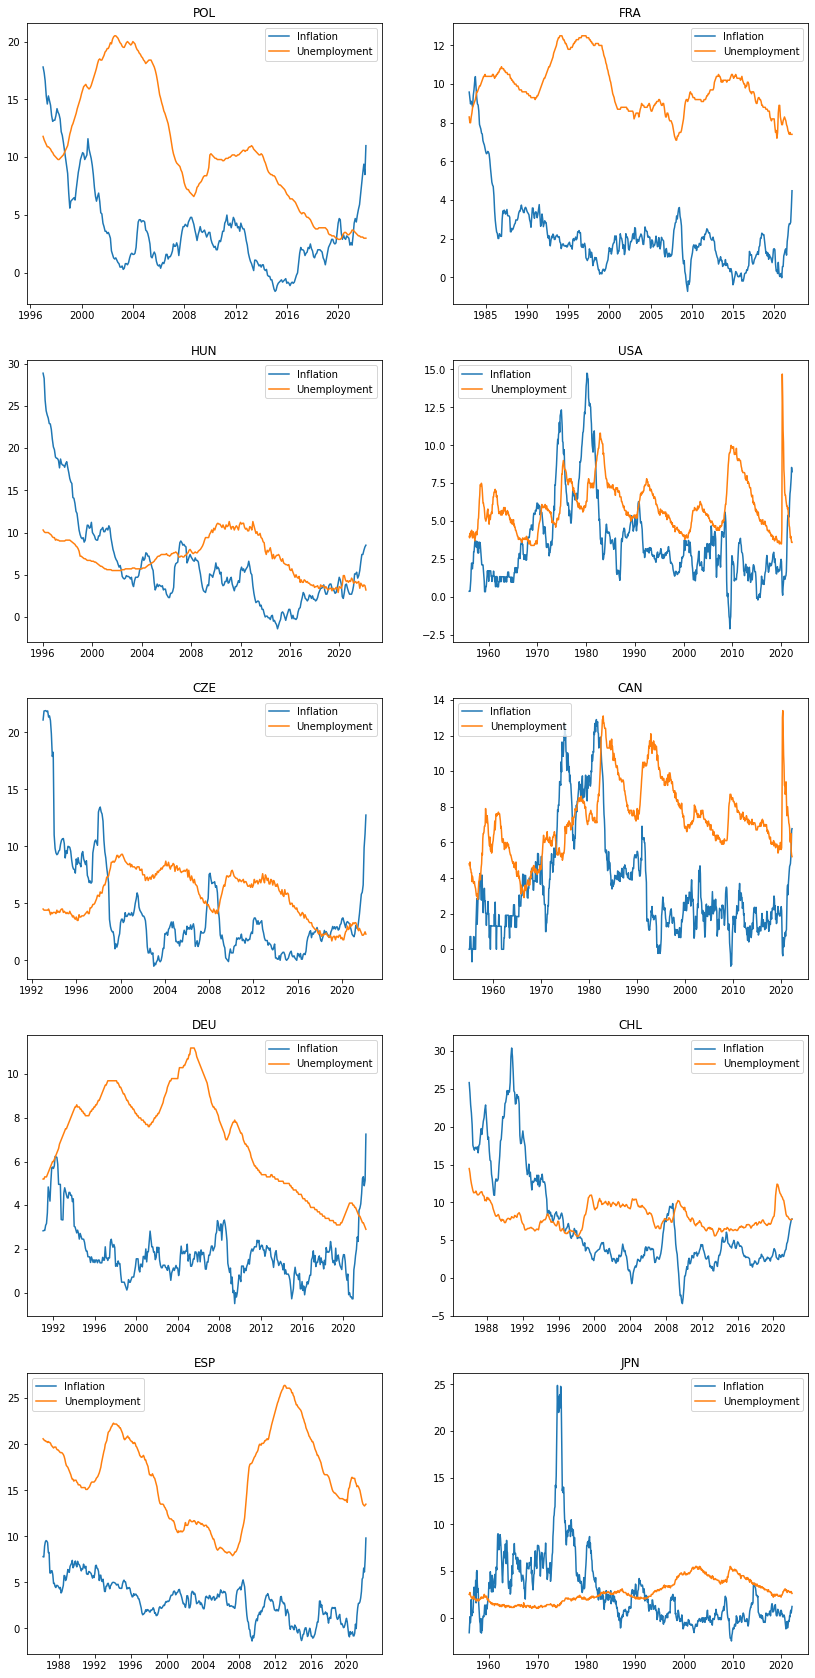

In [12]:
subplt_idx = [[0, 0], [1, 0], [2, 0], [3, 0], [4, 0], [0, 1], [1, 1], [2, 1], [3, 1], [4, 1]]
fig, axis = plt.subplots(5, 2, figsize=(14, 30))
for i, country in enumerate(country_list):
    axis[subplt_idx[i][0], subplt_idx[i][1]].plot(country[0]["TIME"], country[0]["Value"])
    axis[subplt_idx[i][0], subplt_idx[i][1]].plot(country[1]["TIME"], country[1]["Value"])
    axis[subplt_idx[i][0], subplt_idx[i][1]].legend(["Inflation", "Unemployment"])
    axis[subplt_idx[i][0], subplt_idx[i][1]].set_title(locations[i])

In [13]:
stan_file_prior = r"C:\Studia\Data-Analytics\Projekt-Proper\generated_quantities.stan"
model_prior = CmdStanModel(stan_file=stan_file_prior)

INFO:cmdstanpy:found newer exe file, not recompiling


In [109]:
data = {
"N": 1000,
"x": np.linspace(2, 30, 1000)
}

fit_prior = model_prior.sample(data = data, iter_sampling = 1000, iter_warmup=500)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▏        | 00:00 Iteration:   1 / 1000 [  0%]  (Sampling)



chain 1 |█▊        | 00:00 Iteration: 100 / 1000 [ 10%]  (Sampling)

chain 1 |██▎       | 00:01 Iteration: 200 / 1000 [ 20%]  (Sampling)



chain 1 |██▉       | 00:01 Iteration: 300 / 1000 [ 30%]  (Sampling)



chain 1 |███▌      | 00:01 Iteration: 400 / 1000 [ 40%]  (Sampling)
chain 1 |████      | 00:02 Iteration: 500 / 1000 [ 50%]  (Sampling)


chain 1 |████▋     | 00:02 Iteration: 600 / 1000 [ 60%]  (Sampling)





chain 1 |█████▎    | 00:03 Iteration: 700 / 1000 [ 70%]  (Sampling)


chain 1 |█████▉    | 00:03 Iteration: 800 / 1000 [ 80%]  (Sampling)


chain 1 |██████████| 00:03 Sampling completed                      
chain 2 |██████████| 00:03 Sampling completed                      

chain 3 |██████████| 00:03 Sampling completed
chain 4 |██████████| 00:03 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


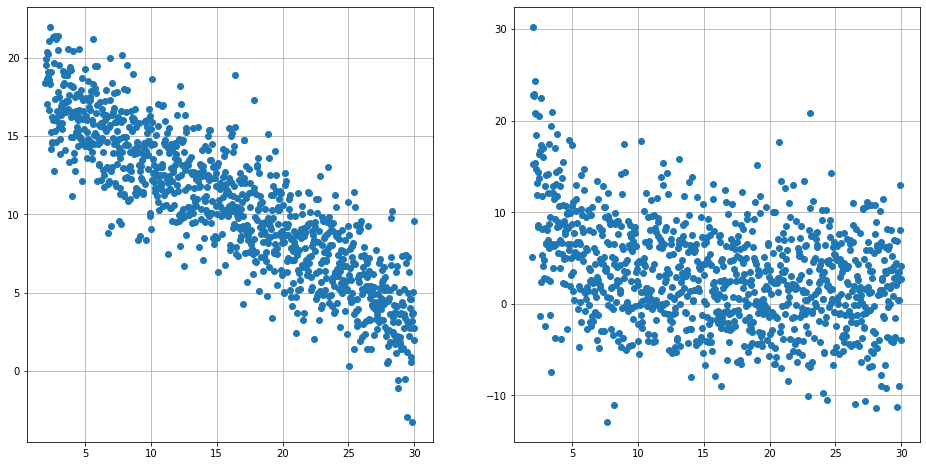

In [118]:
df_prior = fit_prior.draws_pd()
# df_prior = df_prior[:][df_prior[:] != 0]
# df_prior.dropna(subset = ["alpha_l"], inplace=True)
example_run_lin = df_prior.iloc[0, 5:1005]
example_run_phil = df_prior.iloc[0, 1008:2008]
fig, axis = plt.subplots(1, 2, figsize=(16, 8))
axis[0].plot(np.linspace(2, 30, 1000), example_run_lin, 'o')
axis[0].grid()
axis[1].plot(np.linspace(2, 30, 1000), example_run_phil, 'o')
axis[1].grid()
plt.show()

# plt.plot(np.linspace(2, 30, 1000), example_run_lin)
# plt.show()
# plt.plot(np.linspace(2, 30, 1000), example_run_phil)
# plt.show()

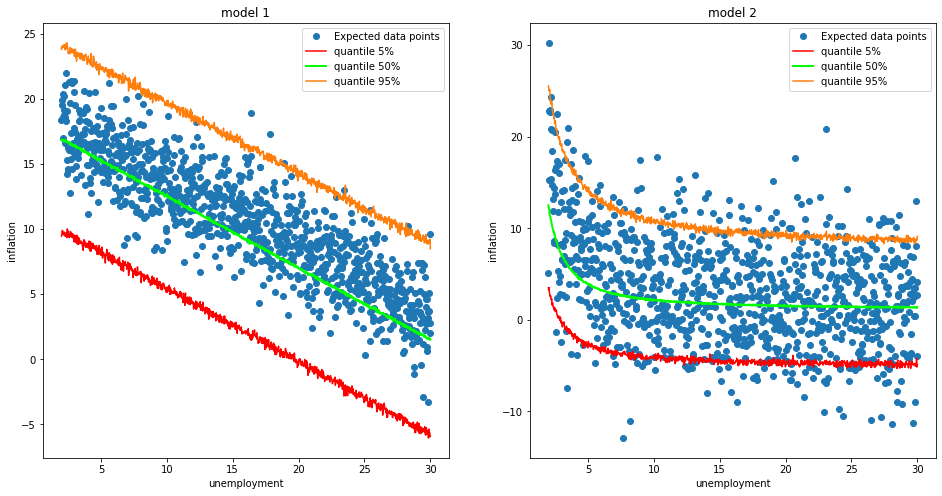

In [129]:
plot_prior(df_prior)

In [15]:
all_countries = concatenate_all_data(country_list=country_list)
span_start_idx = 0
span = len(all_countries[1])

In [16]:
fit1_all, fit2_all = sample_models_all_data(country=all_countries, span=span, span_start_idx=span_start_idx, model1=model_linear, model2=model_phillips)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status























chain 1 |██▎       | 00:04 Iteration:  200 / 1500 [ 13%]  (Warmup)


chain 1 |███▌      | 00:05 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |████▋     | 00:06 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:07 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |█████▉    | 00:08 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:10 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:11 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:12 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |██████████| 00:16 Sampling completed                       
chain 2 |██████████| 00:16 Sampling completed                       
chain 3 |██████████| 00:16 Sampling completed                       
chain 4 |██████████| 00:16 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status









chain 1 |█▏        | 00:08 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |█▊        | 00:09 Iteration:  100 / 1500 [  6%]  (Warmup)



chain 1 |██▎       | 00:10 Iteration:  200 / 1500 [ 13%]  (Warmup)
chain 1 |██▉       | 00:13 Iteration:  300 / 1500 [ 20%]  (Warmup)

chain 1 |███▌      | 00:14 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |████▋     | 00:15 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:19 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |█████▉    | 00:21 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:25 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:26 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:28 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:30 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:33 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 


INFO:cmdstanpy:CmdStan done processing.


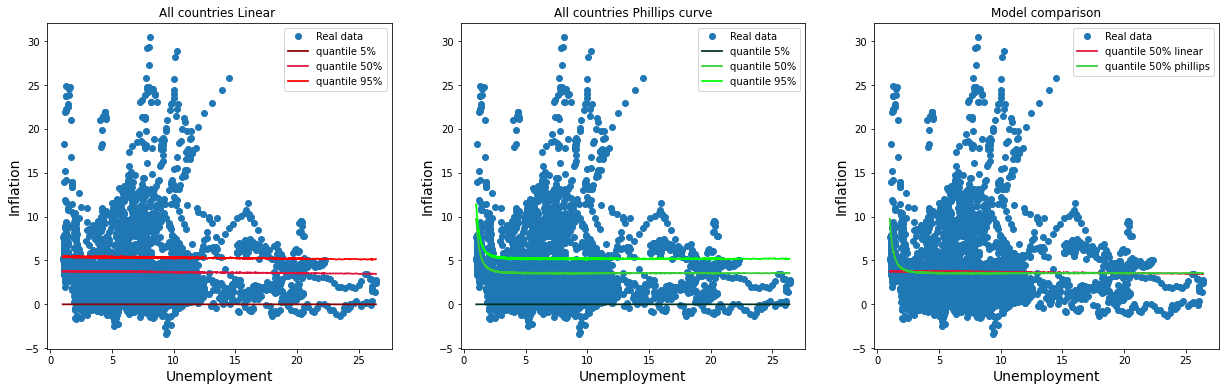

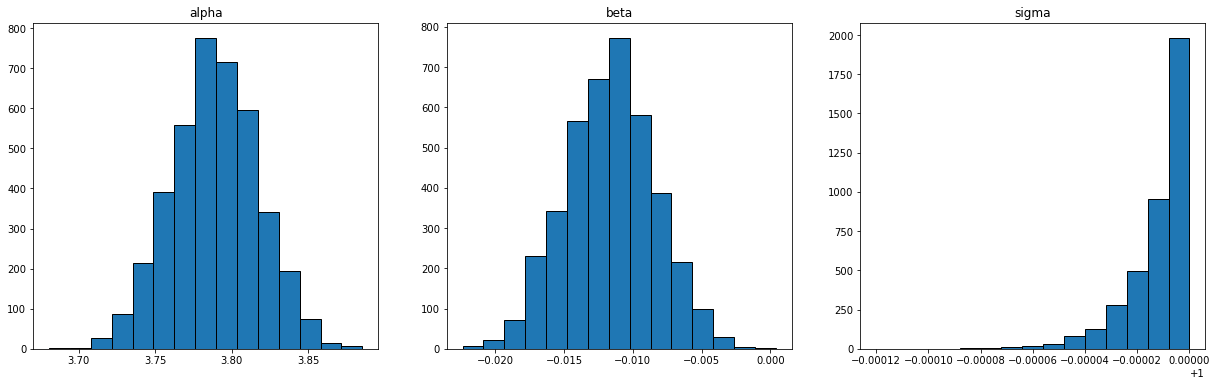

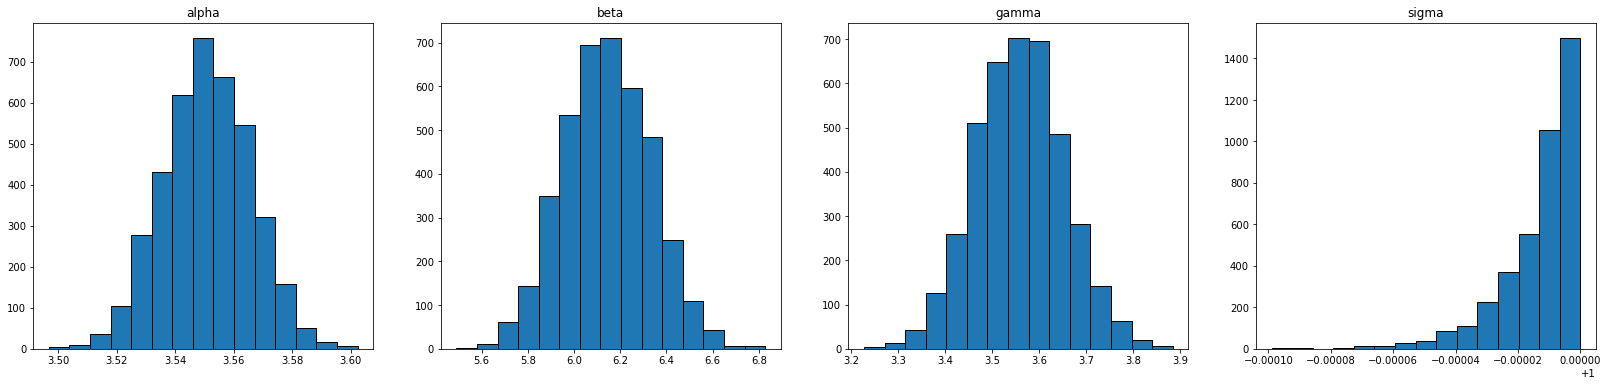

In [50]:
span = len(all_countries[1])
plot_results_all_data(country = all_countries, fit1 = fit1_all, fit2 = fit2_all, fig_nr = 0, span=span)

C:\Users\Maciej\AppData\Local\Temp/ipykernel_6580/3079895504.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(plt_num, figsize=(8, 8))


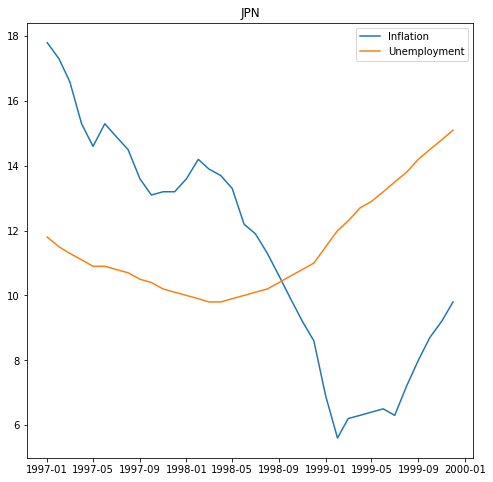

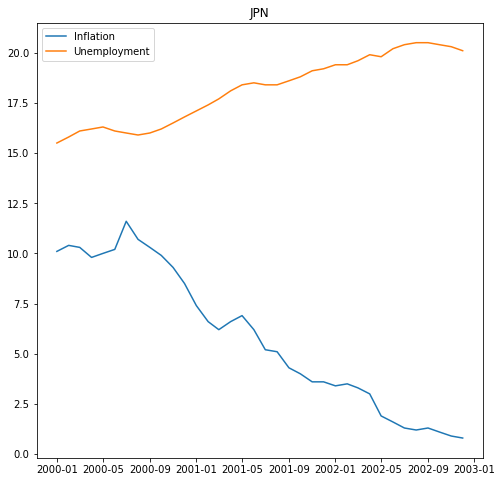

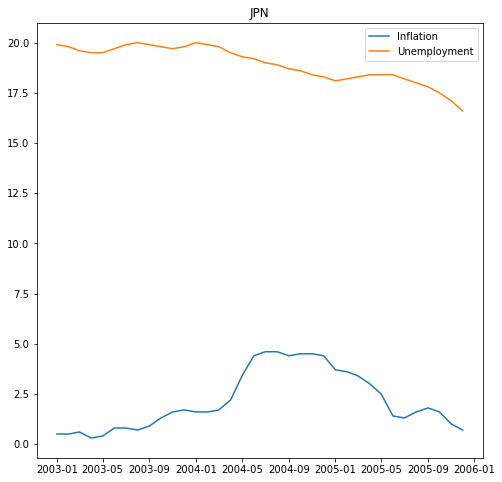

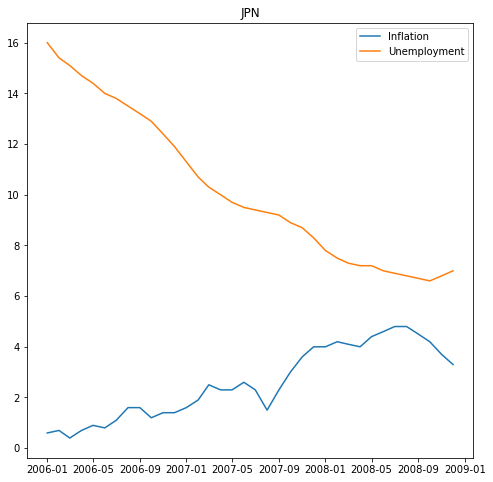

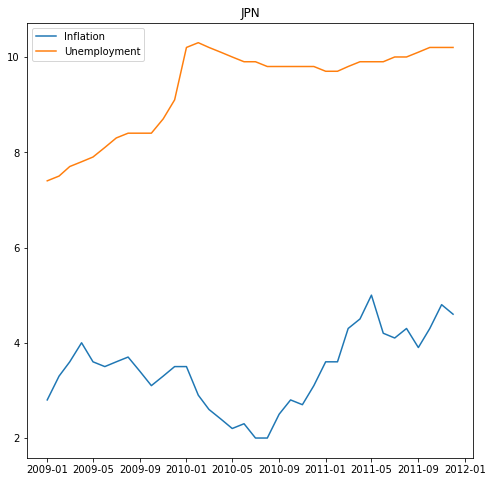

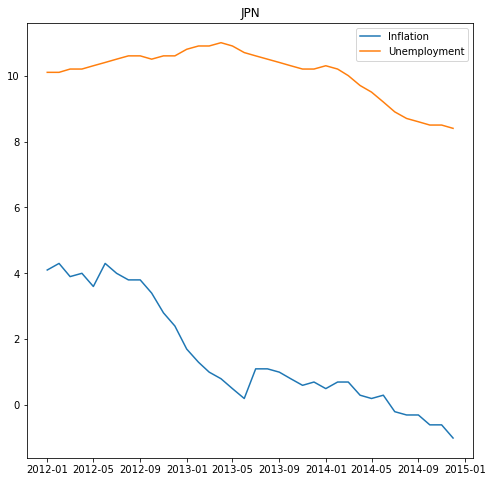

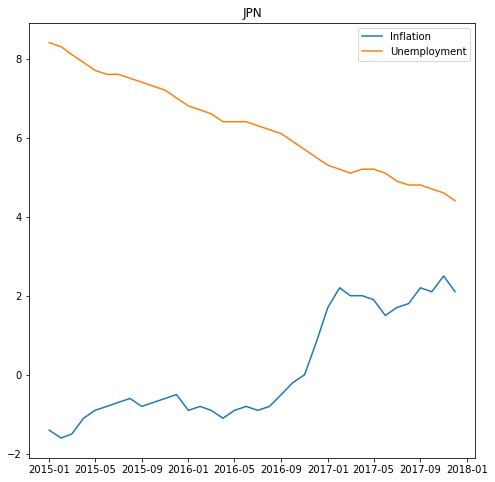

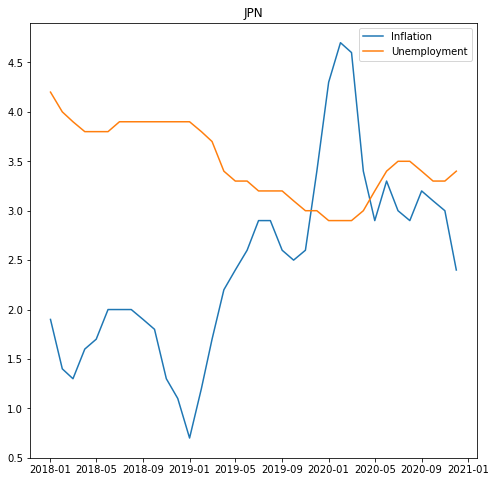

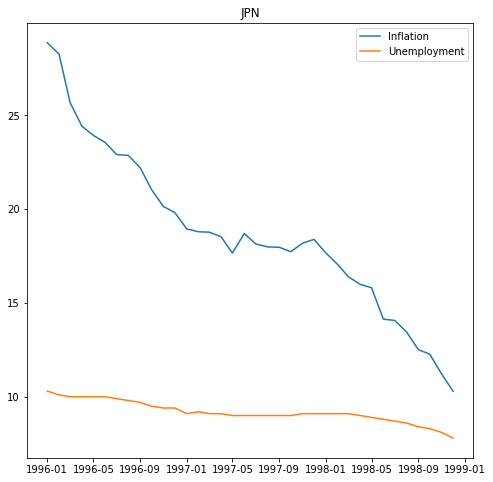

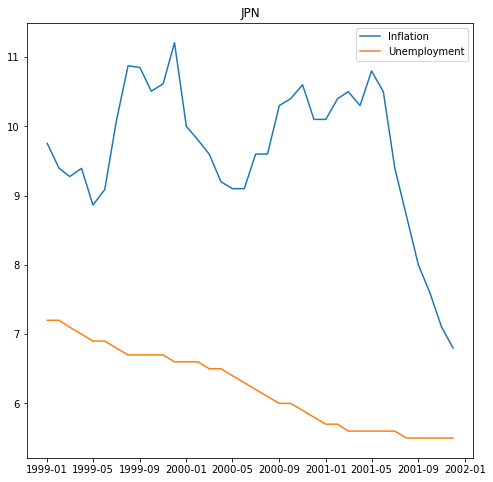

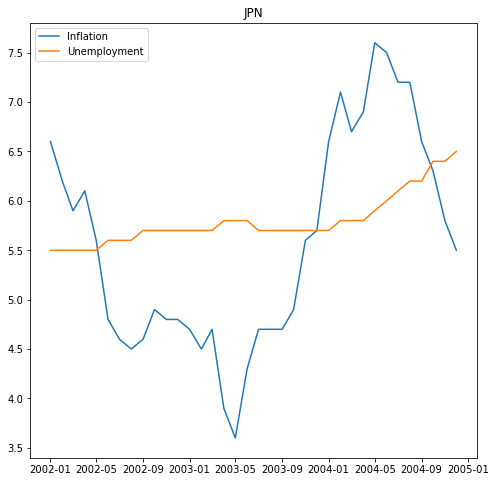

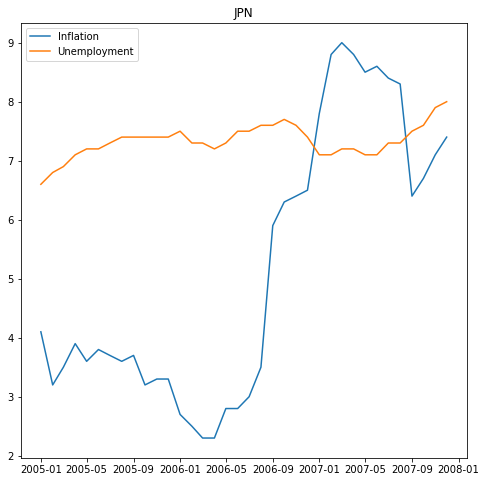

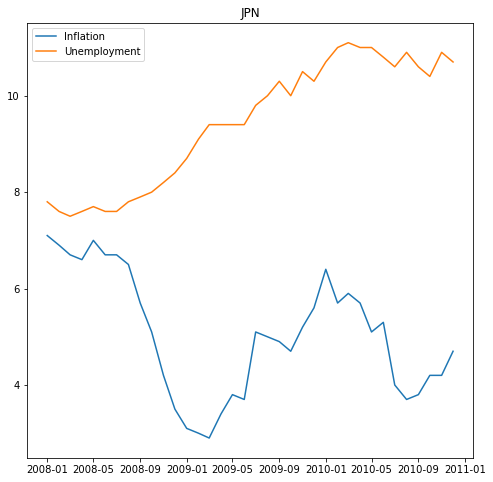

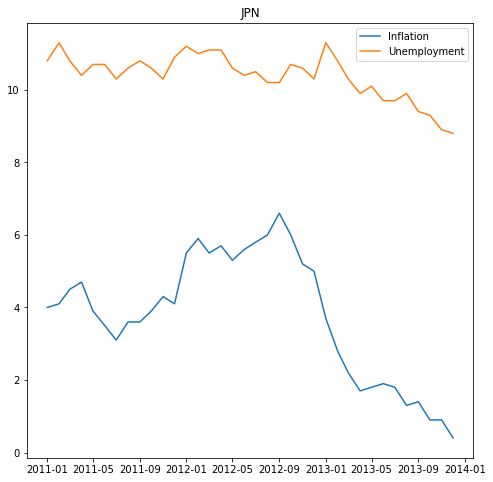

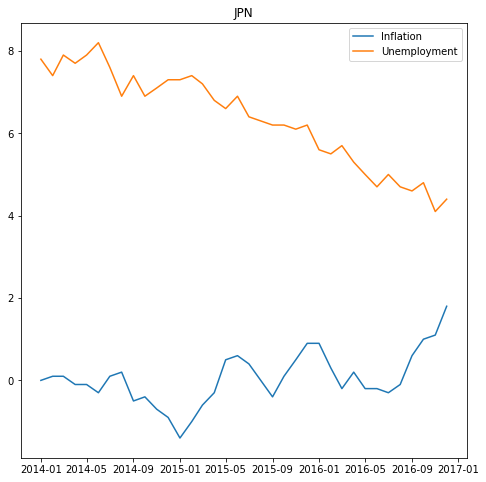

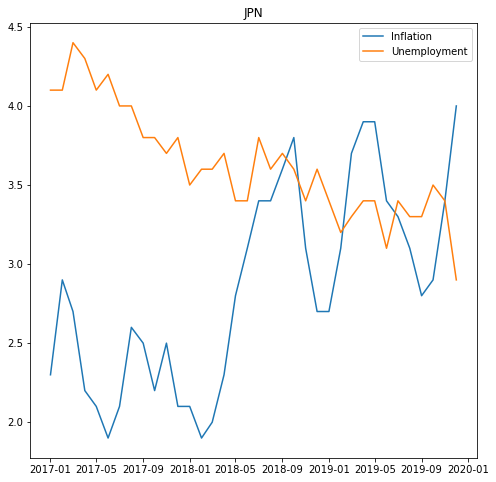

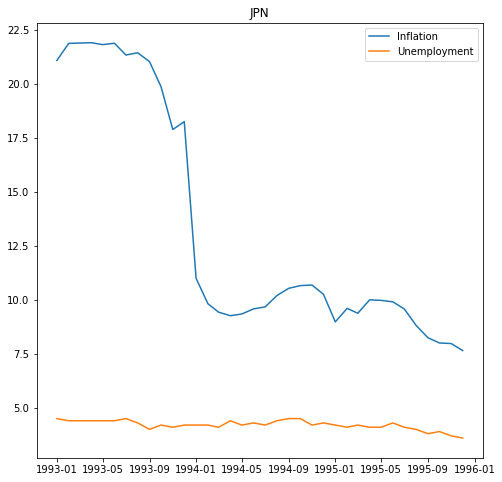

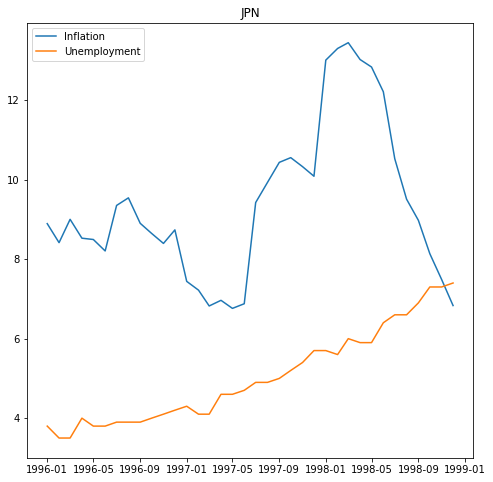

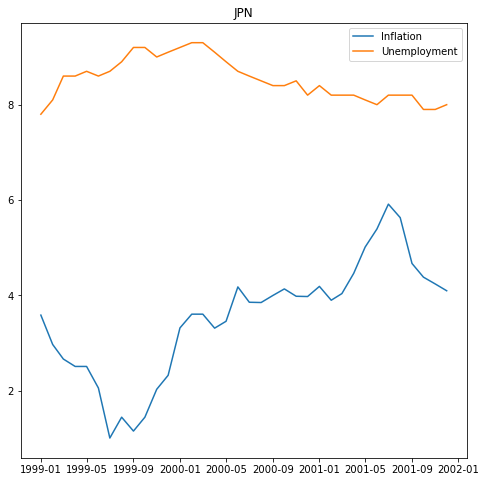

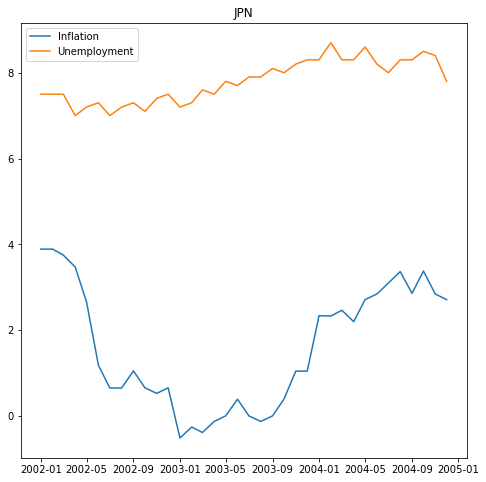

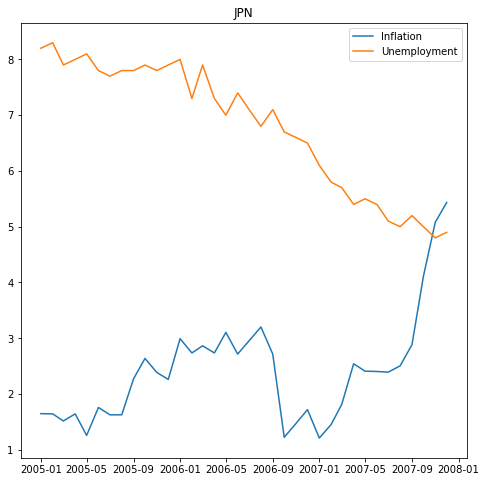

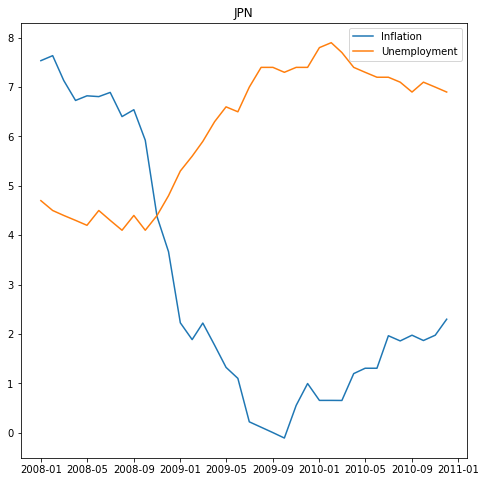

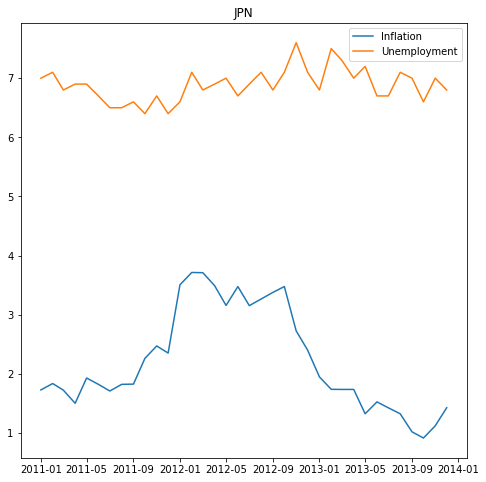

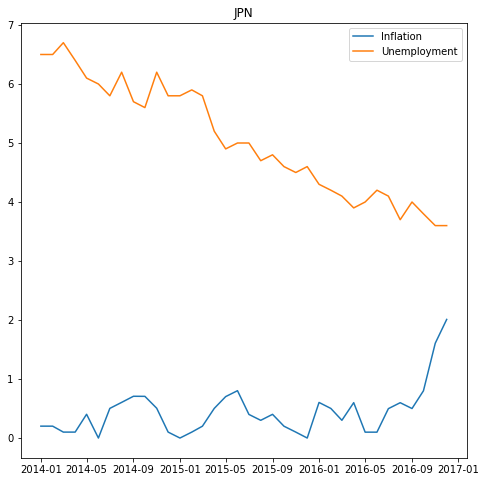

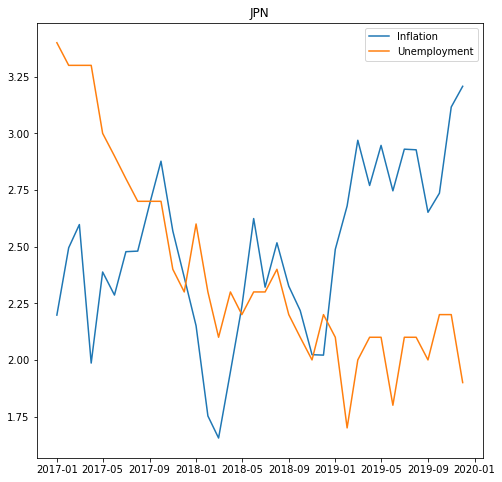

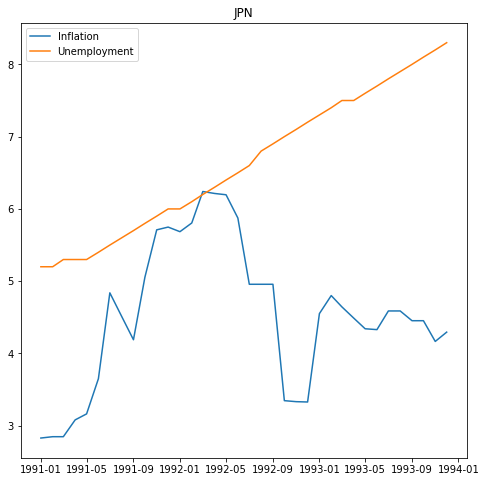

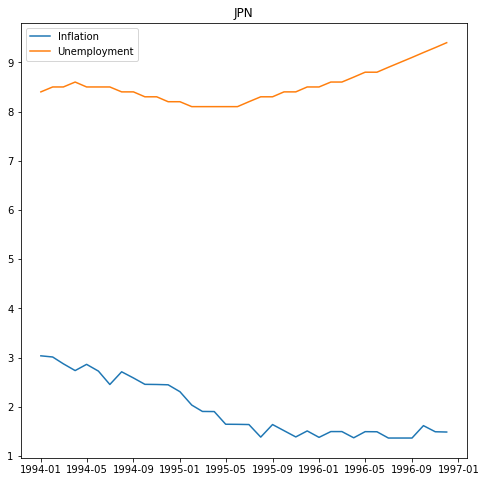

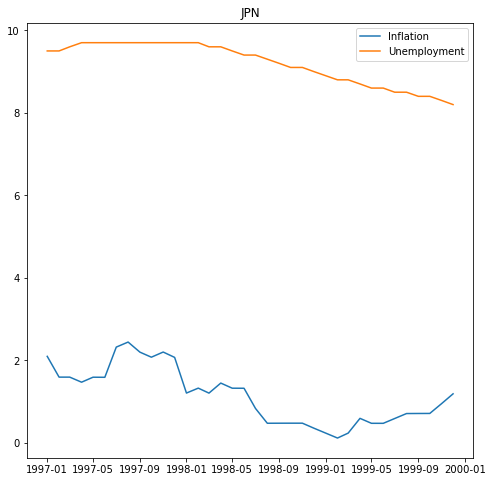

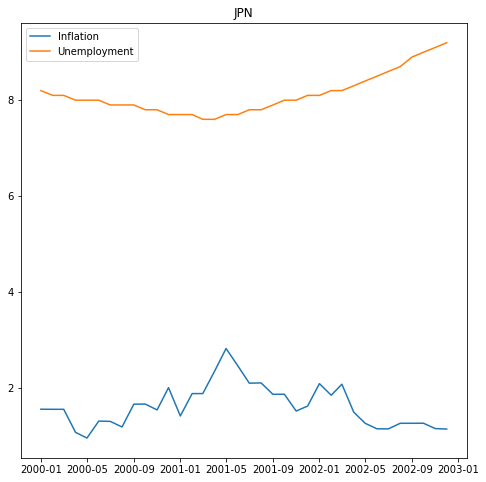

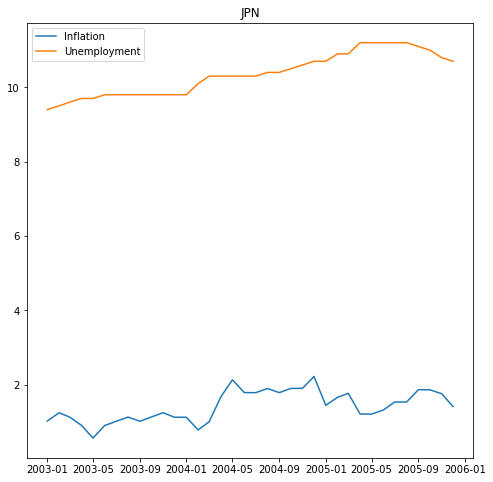

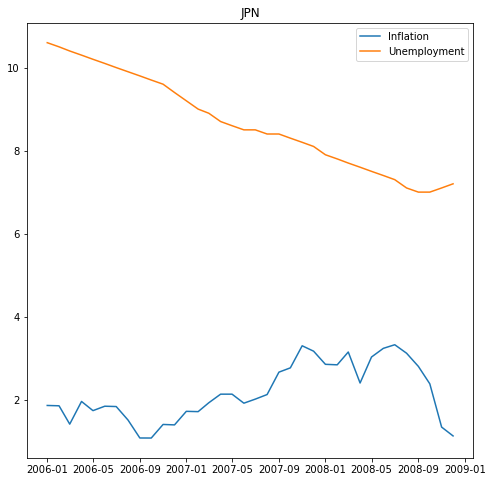

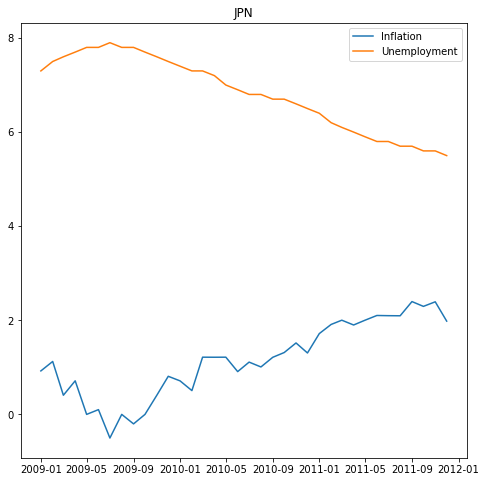

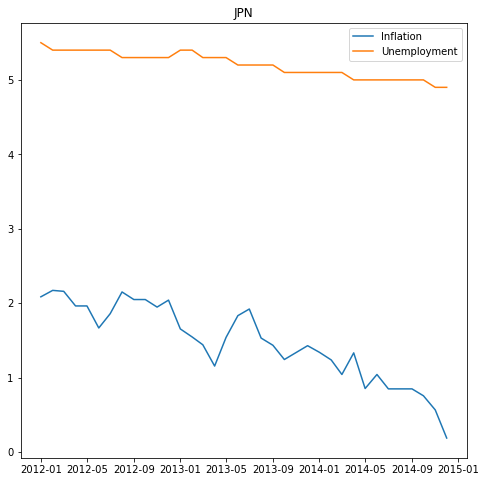

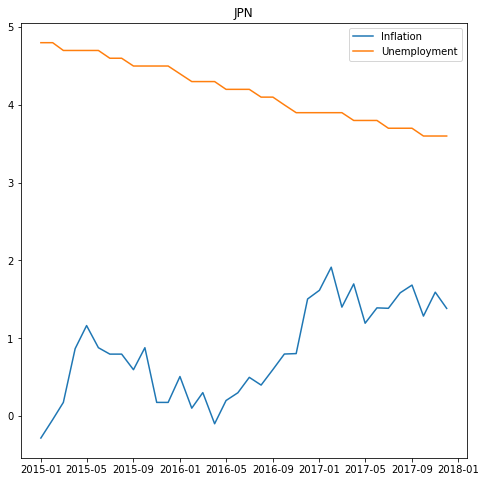

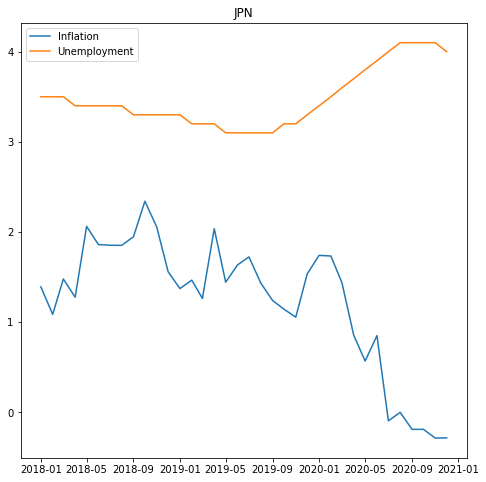

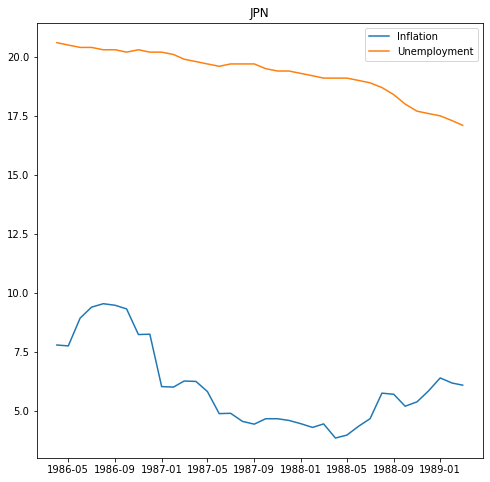

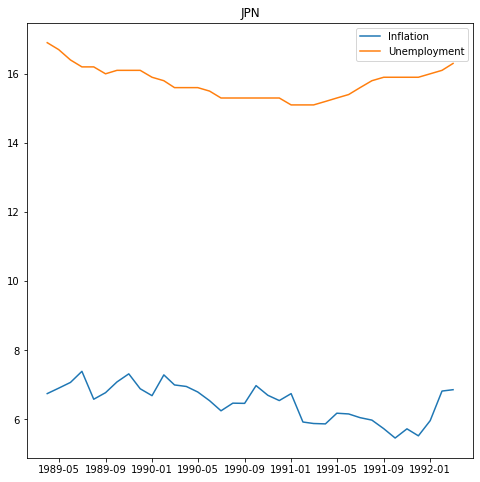

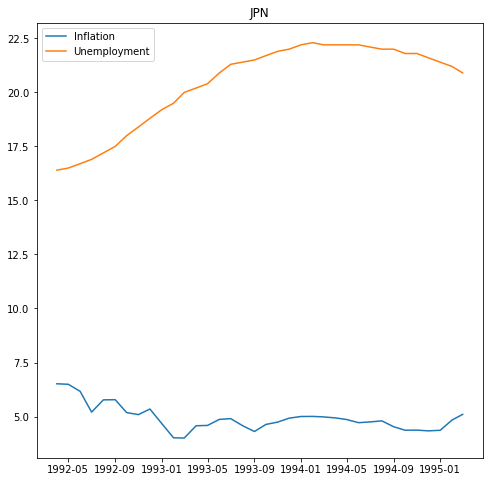

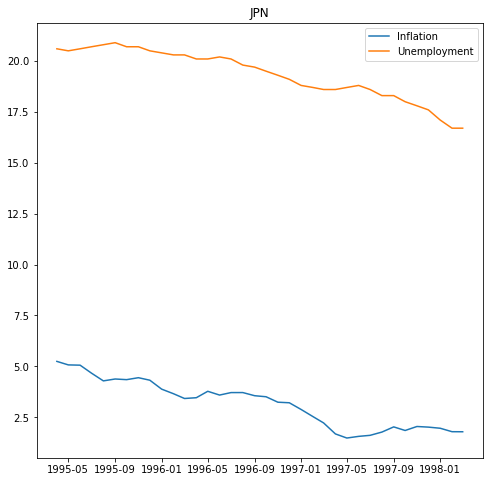

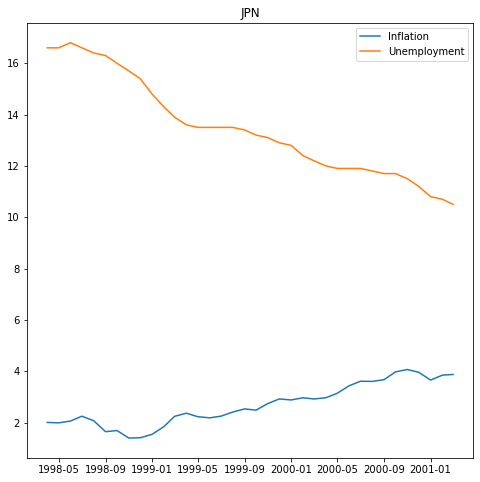

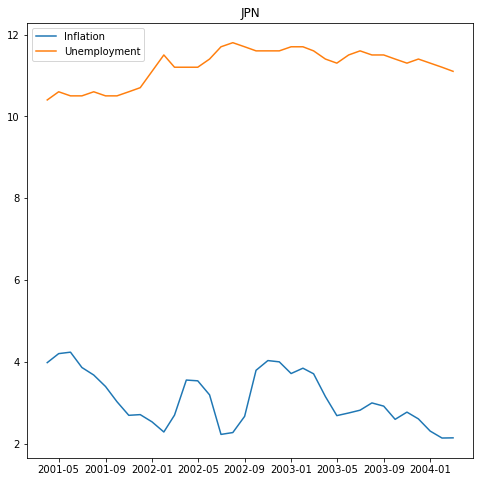

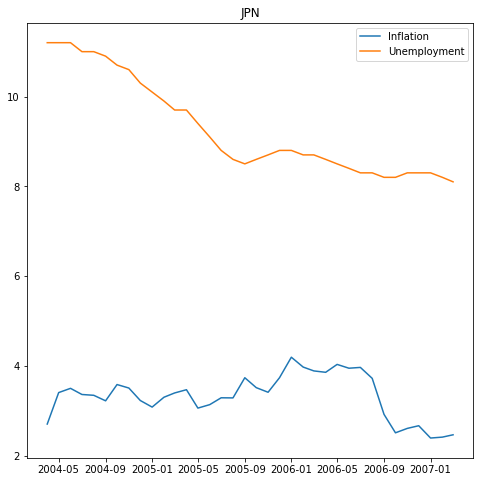

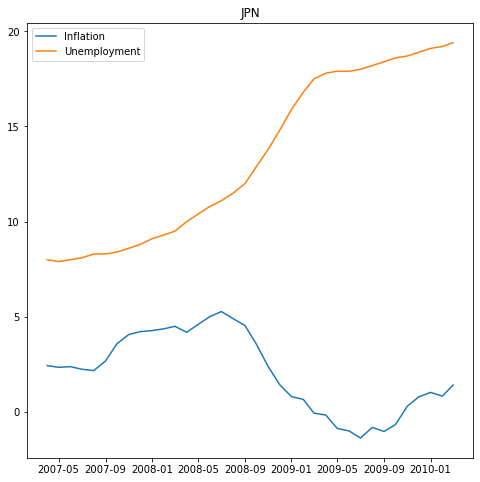

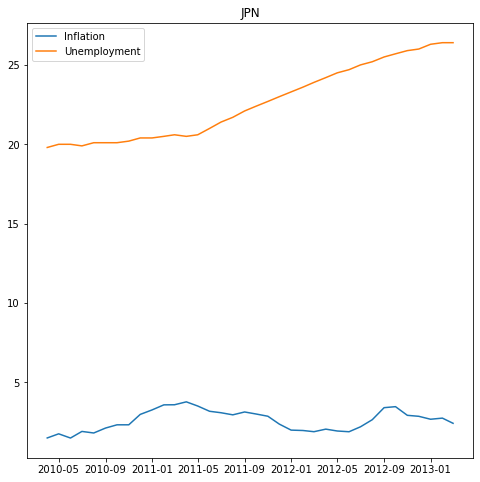

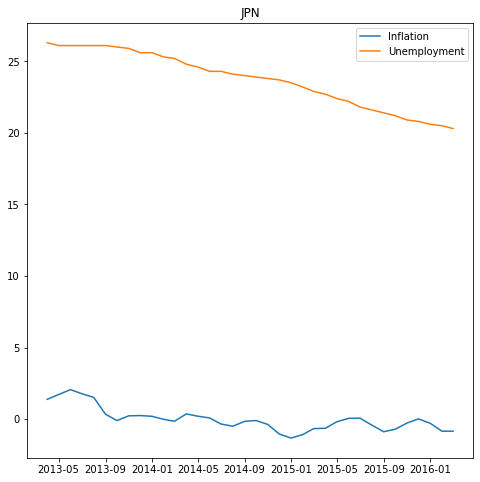

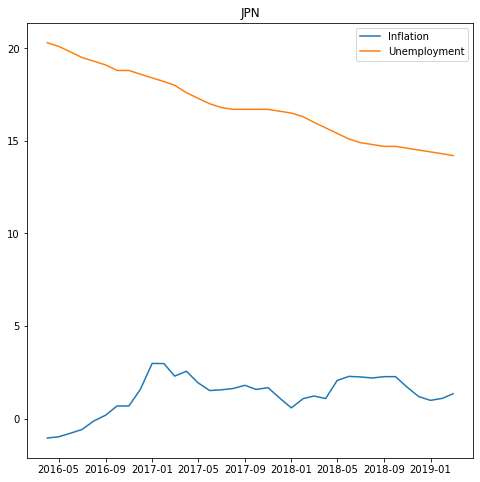

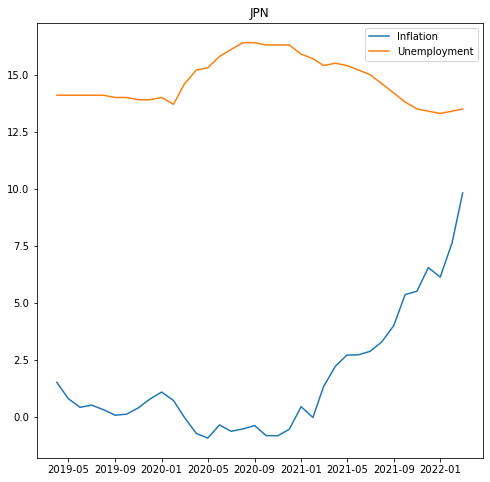

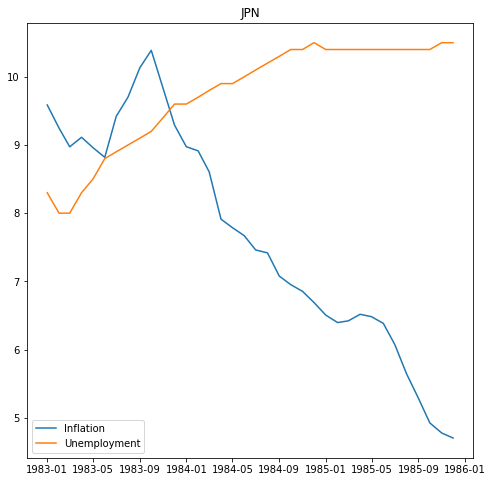

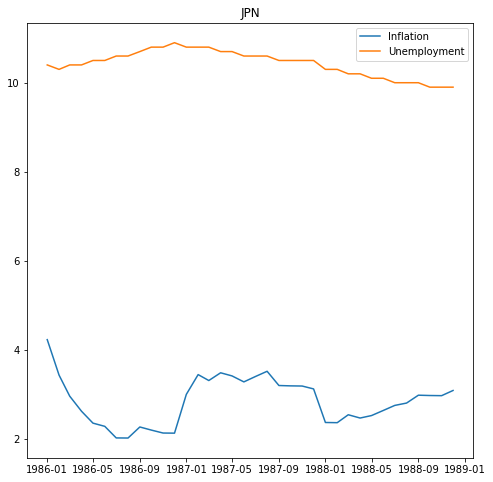

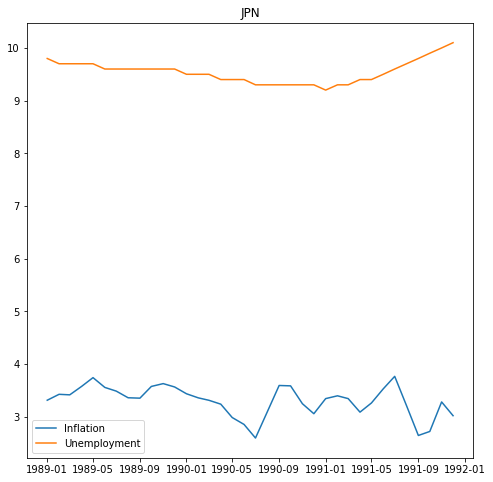

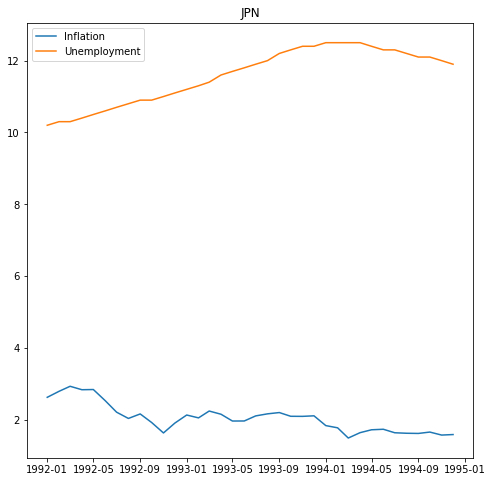

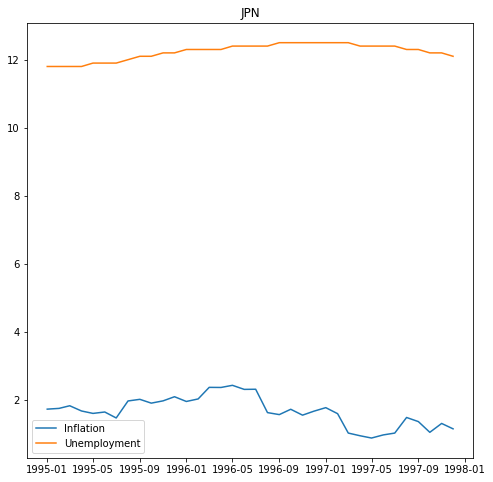

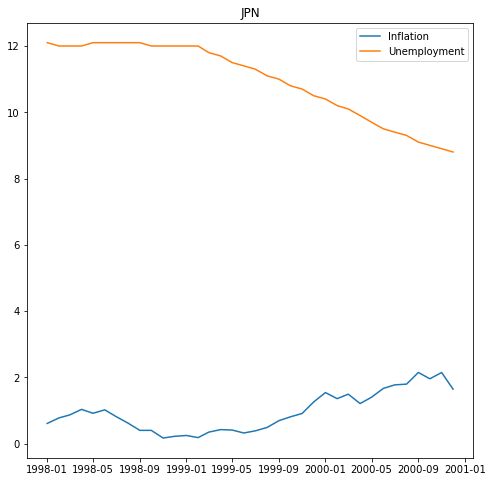

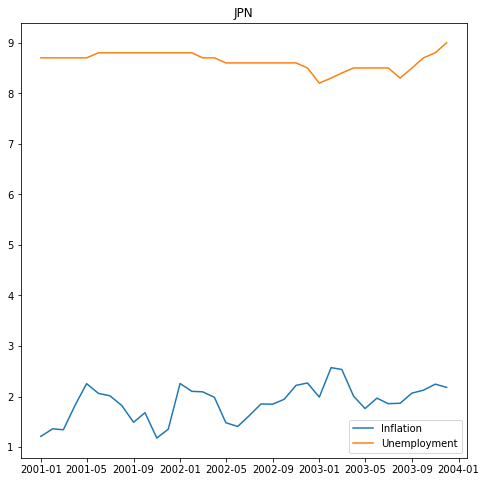

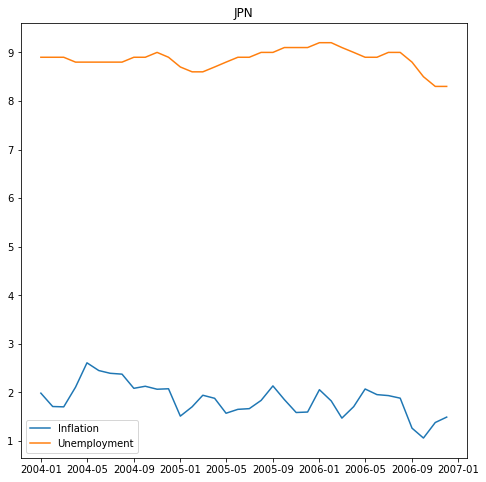

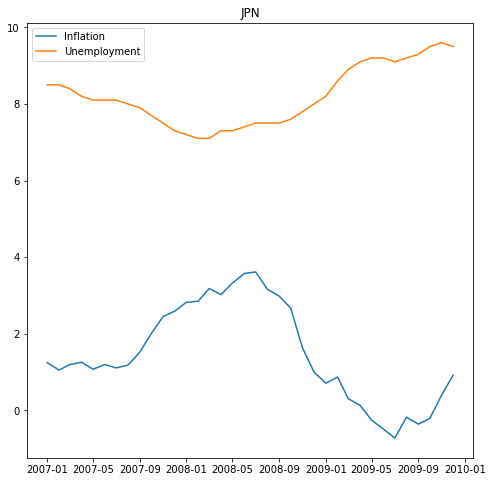

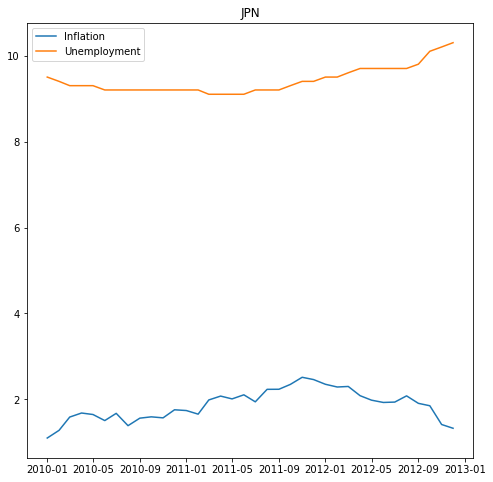

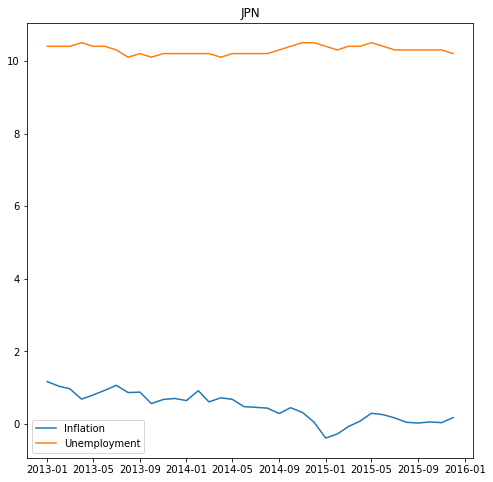

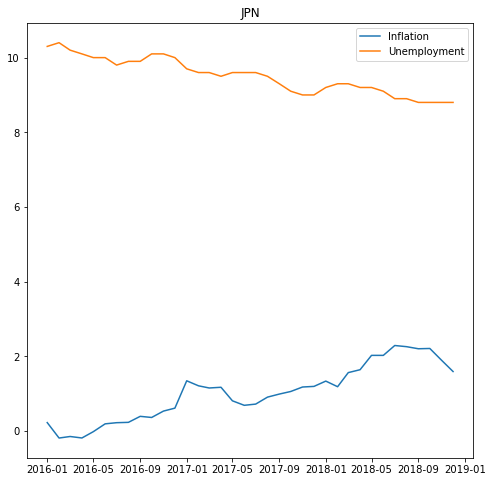

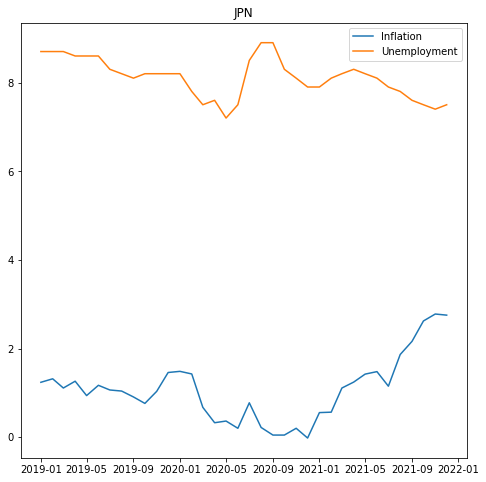

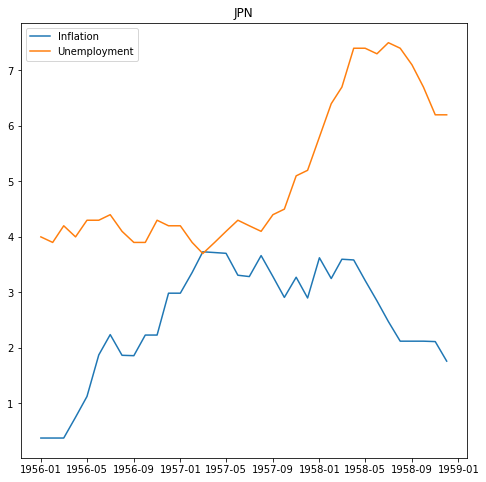

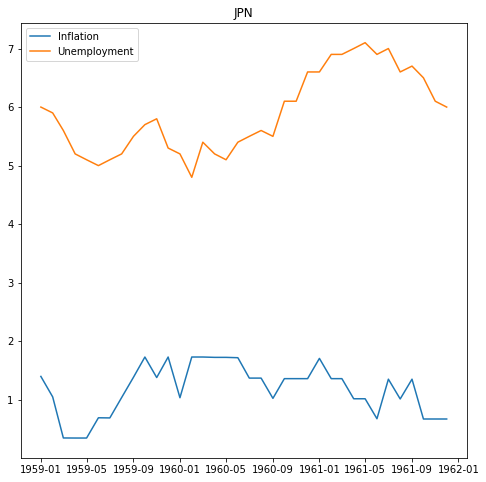

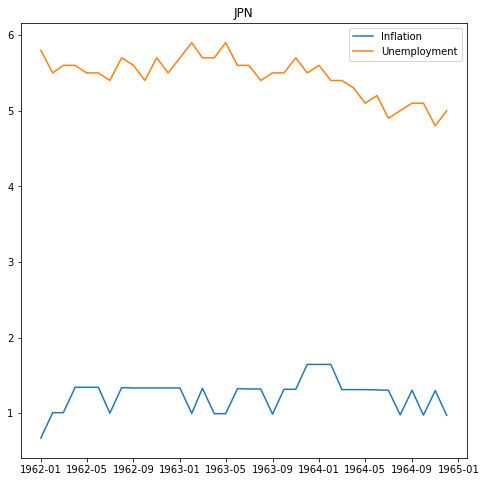

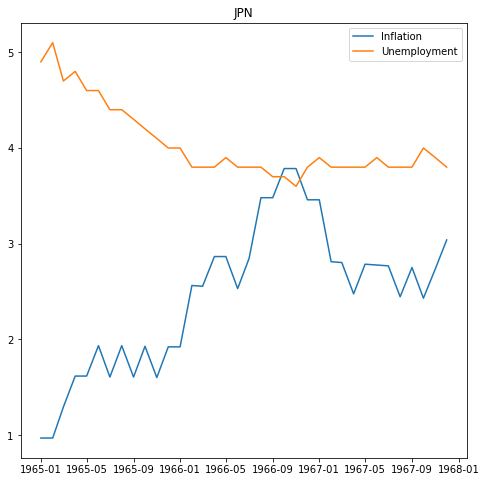

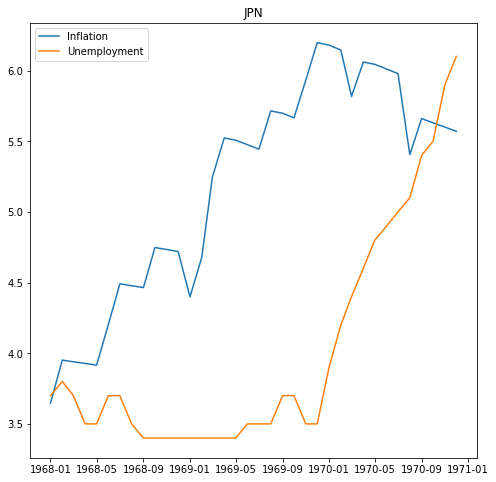

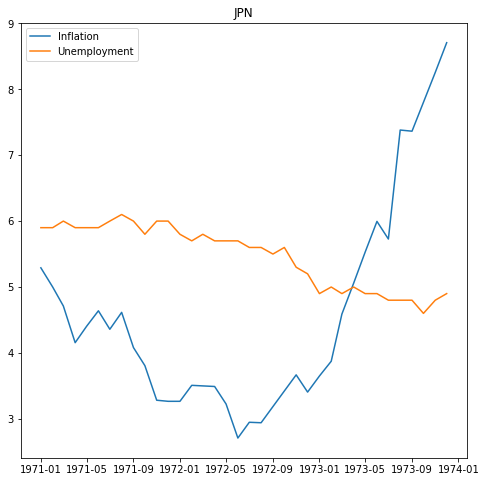

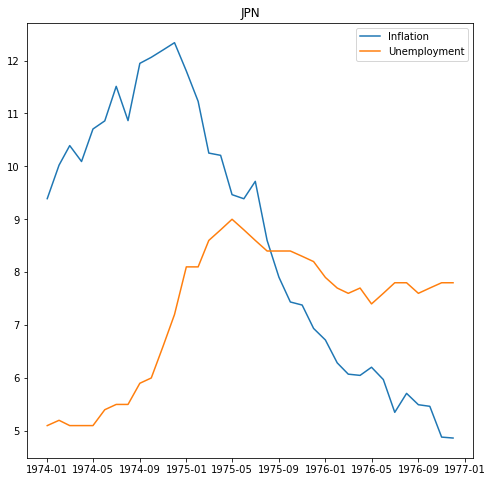

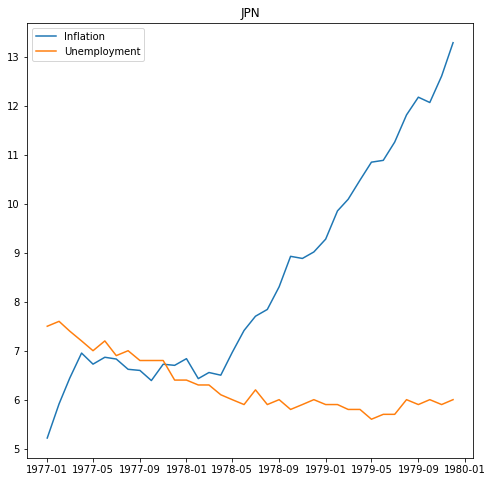

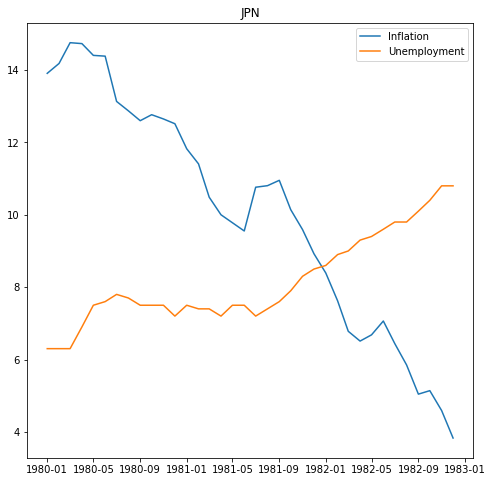

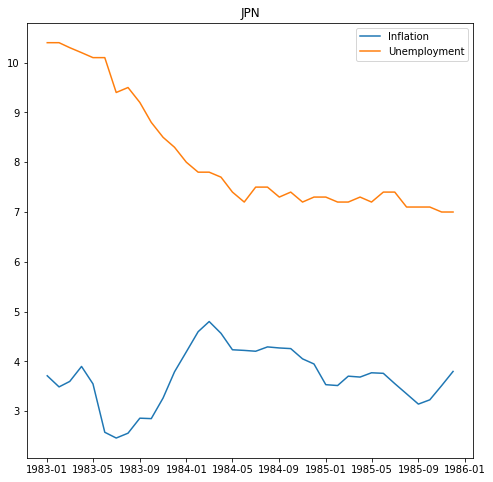

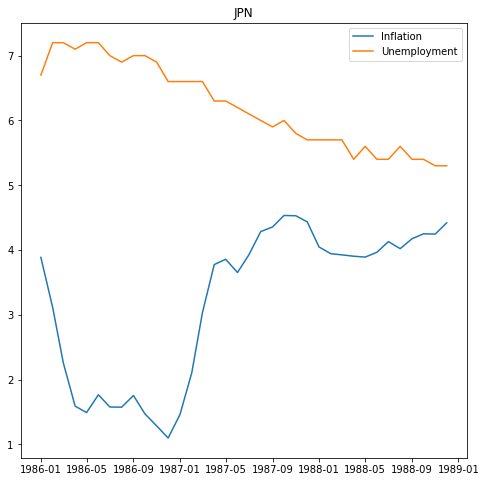

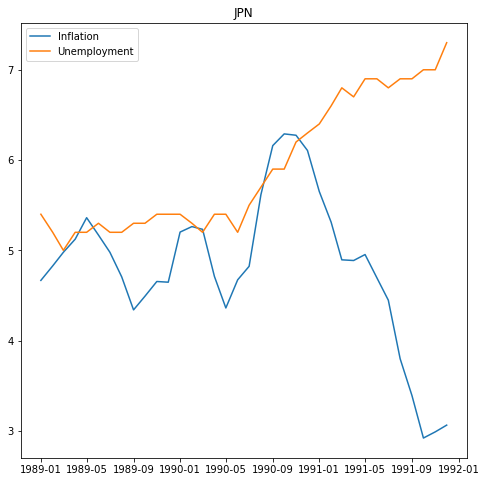

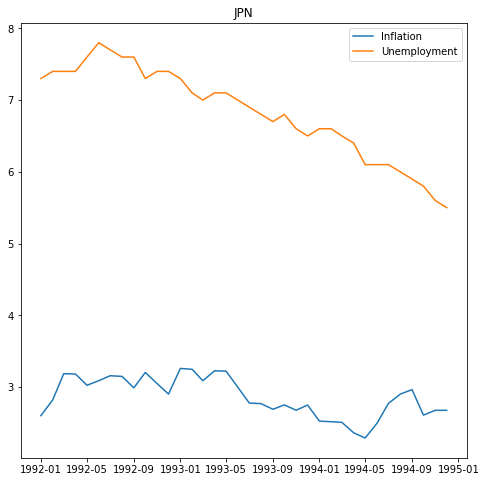

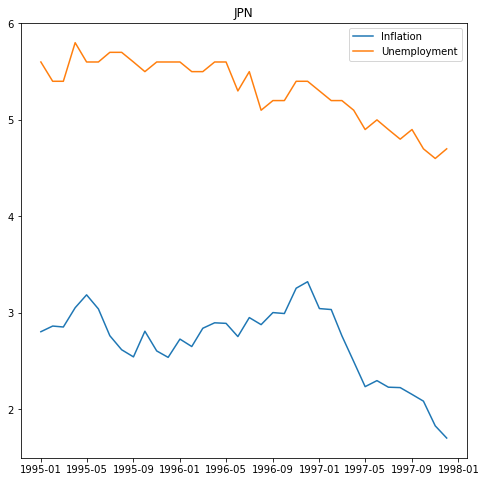

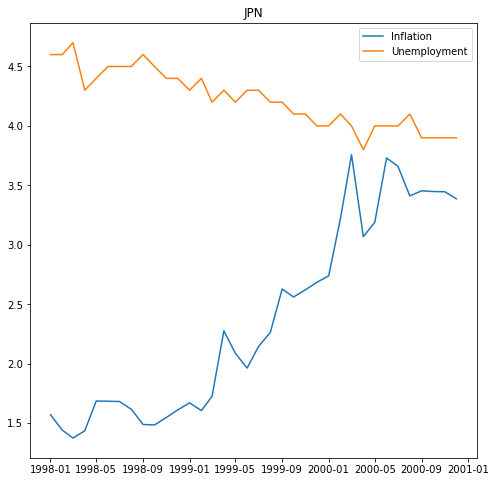

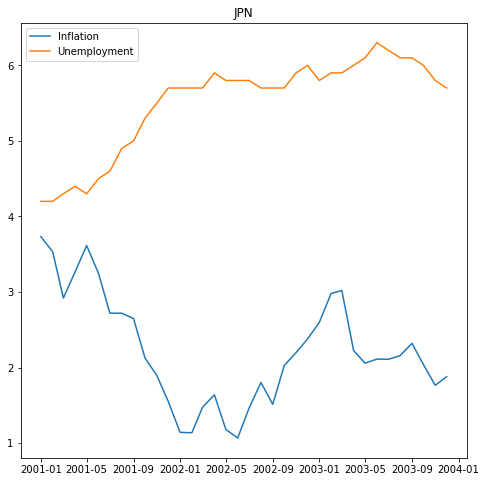

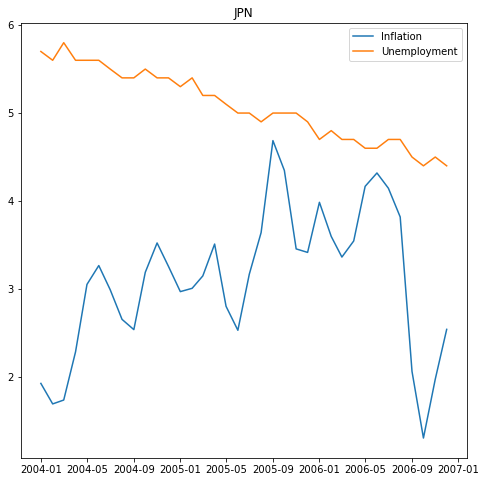

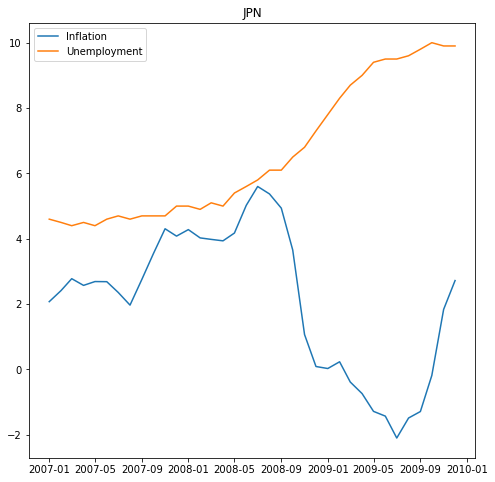

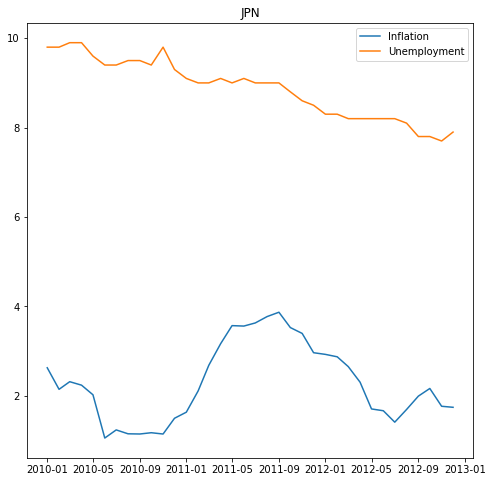

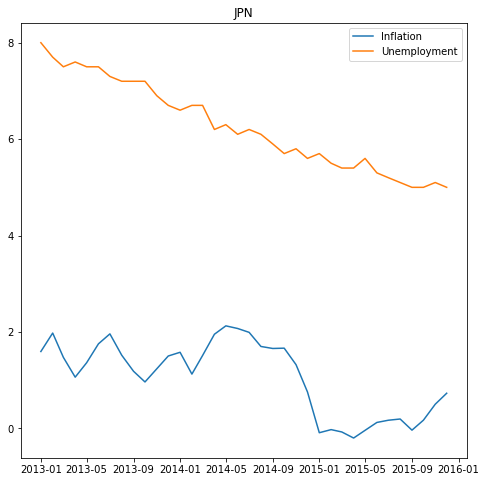

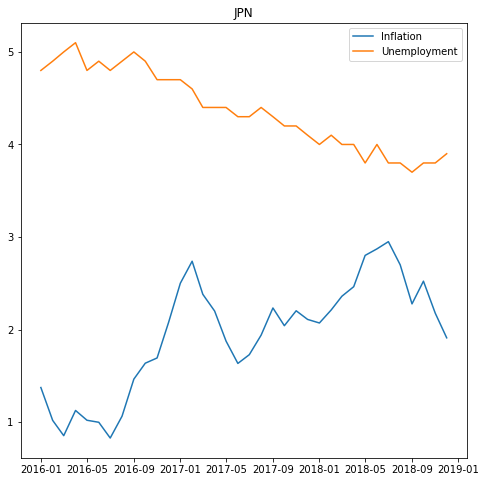

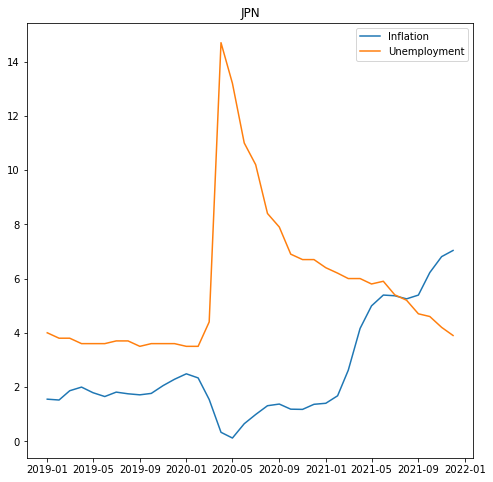

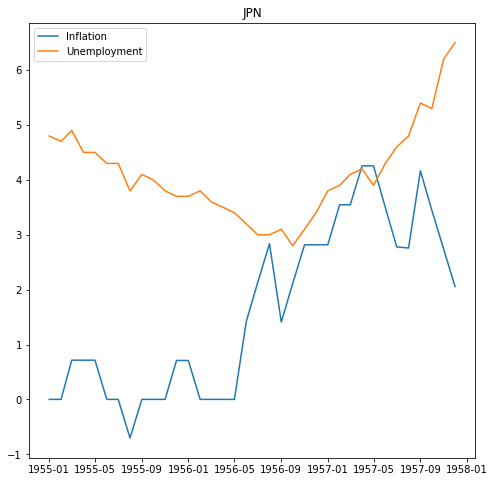

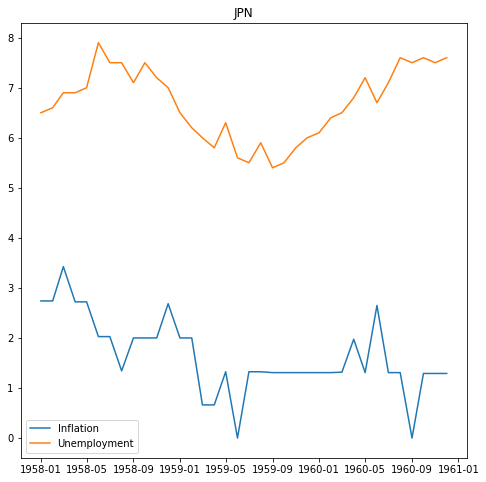

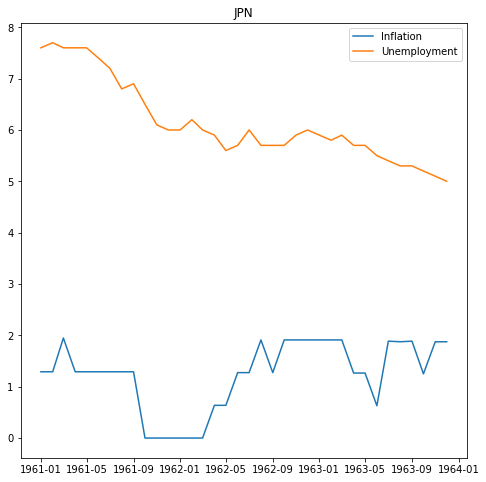

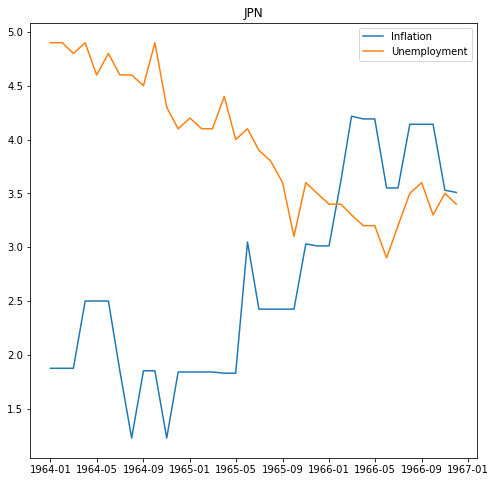

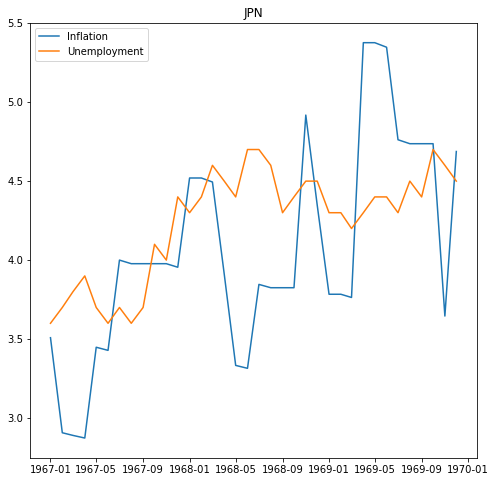

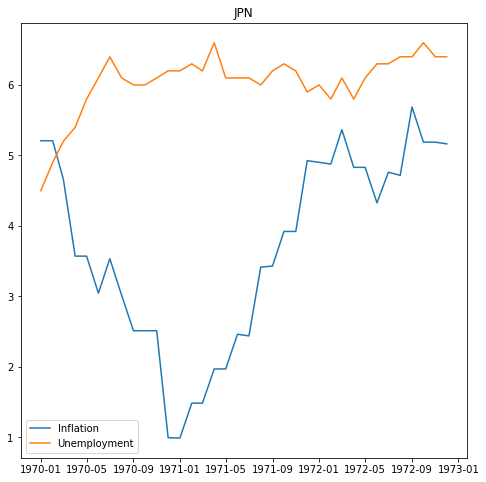

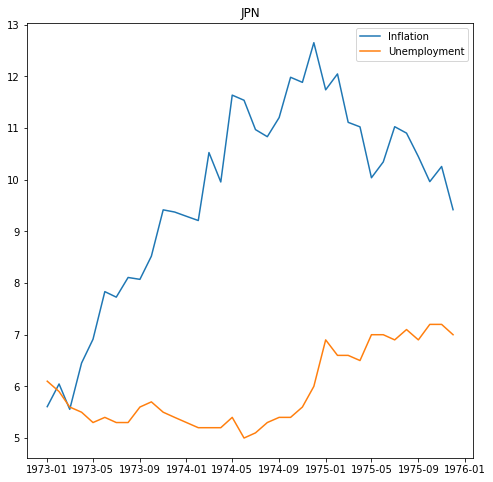

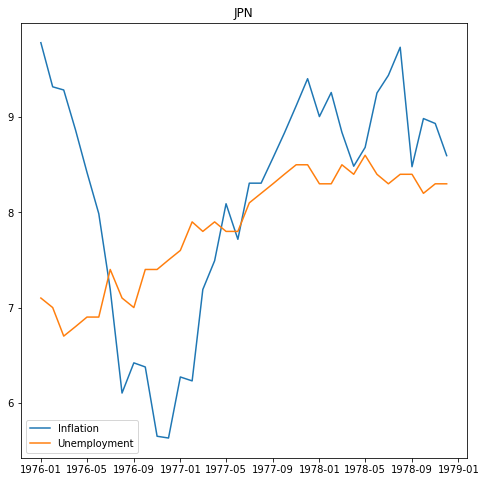

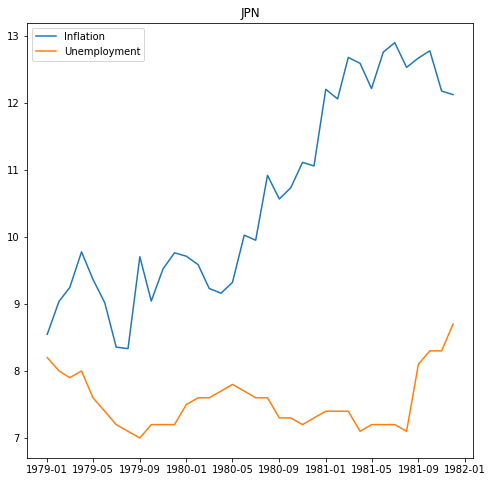

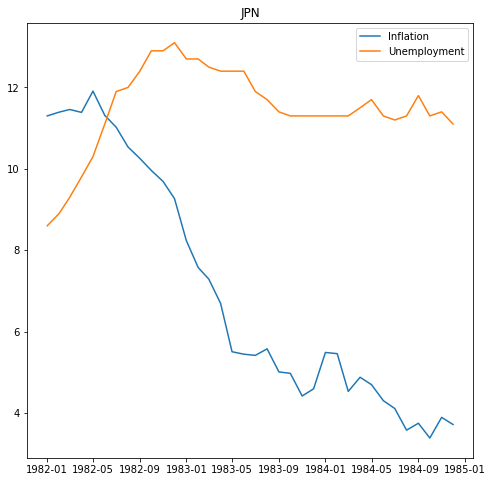

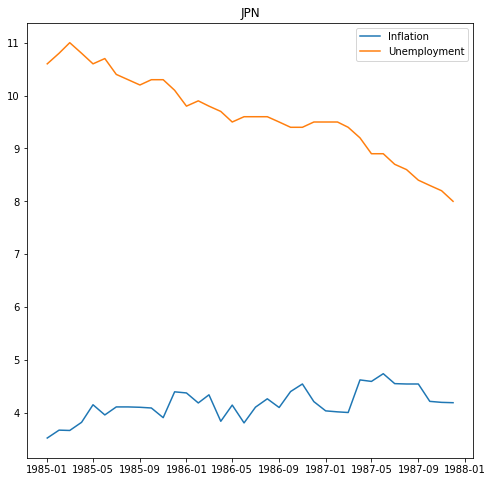

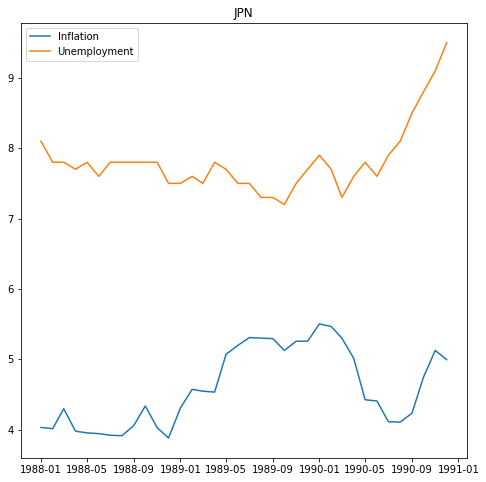

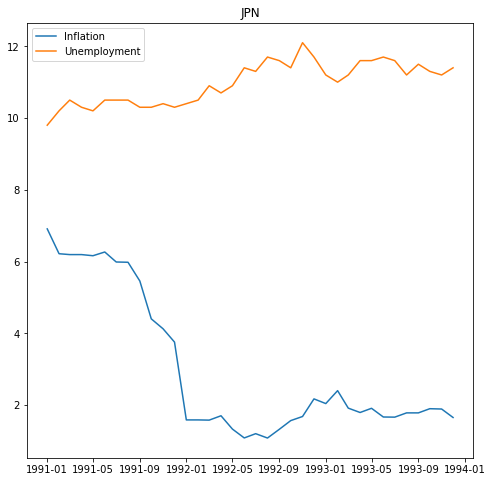

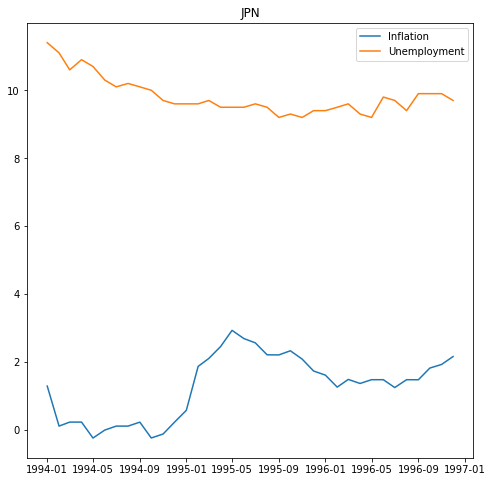

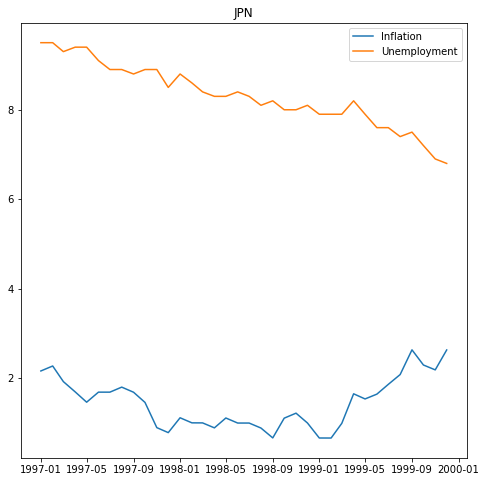

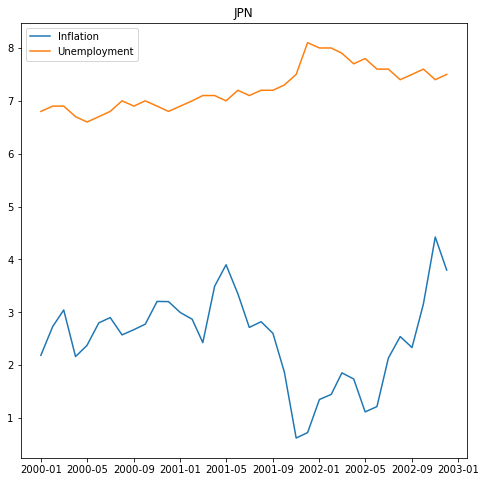

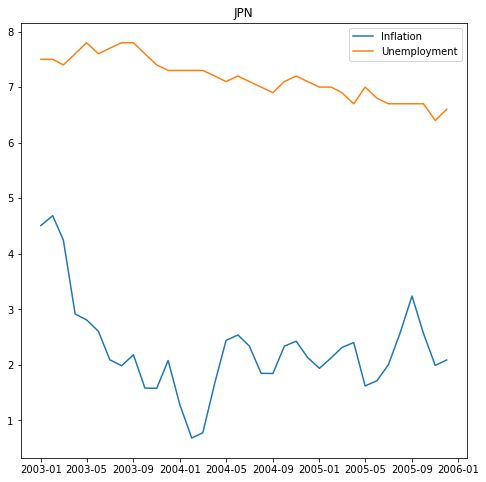

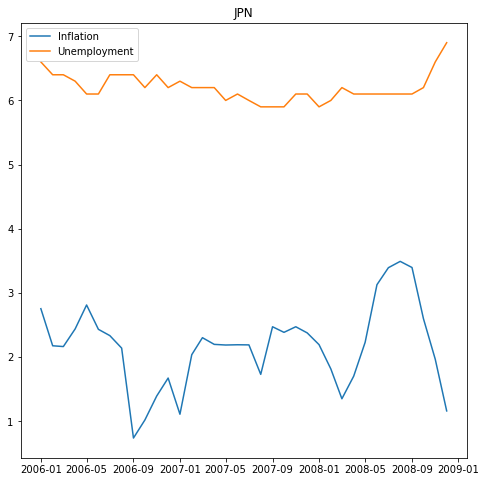

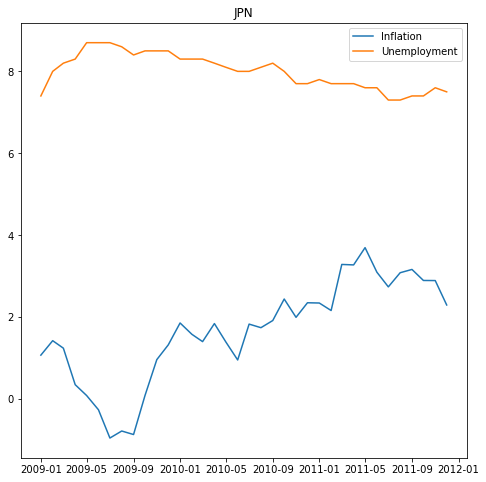

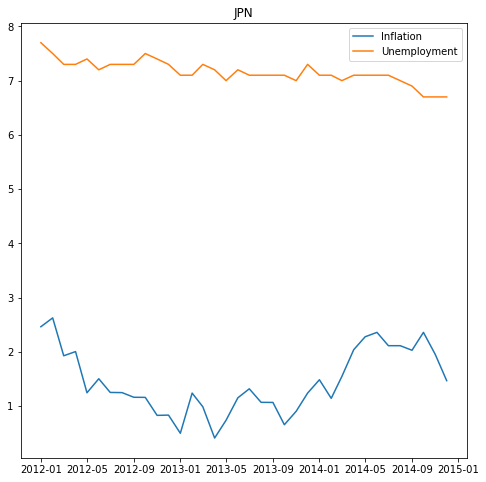

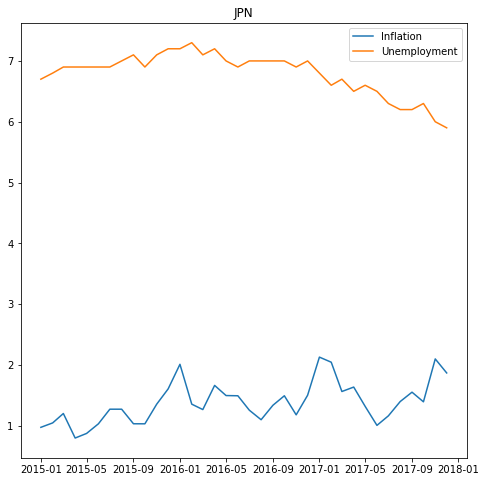

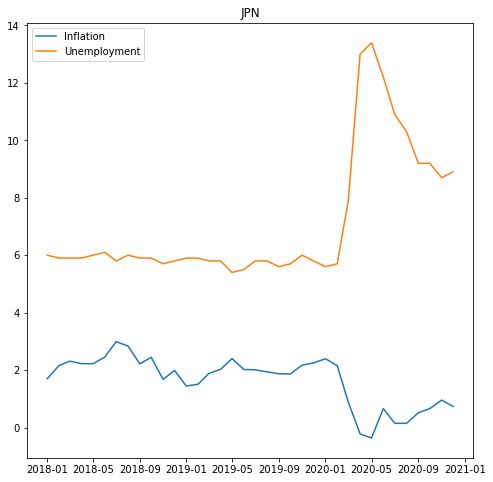

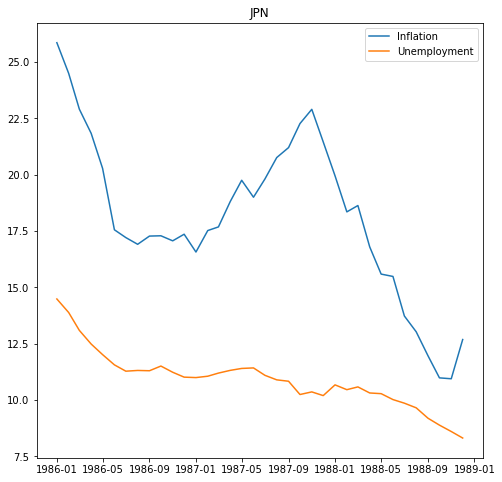

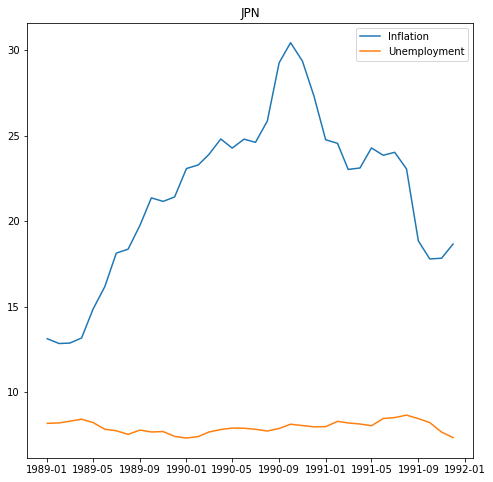

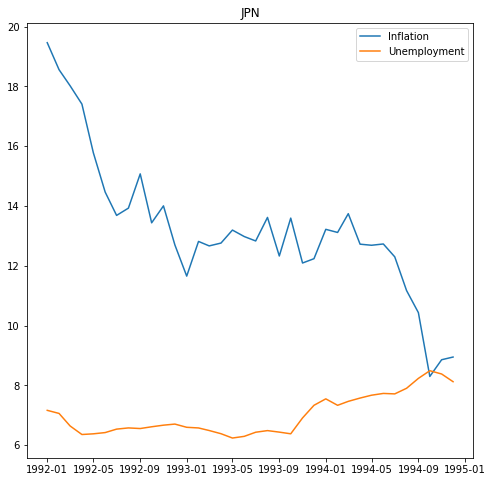

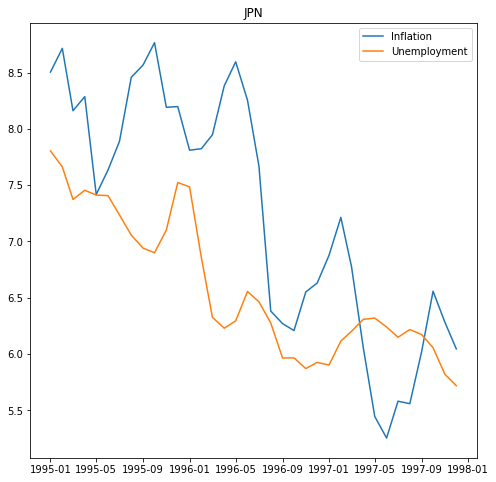

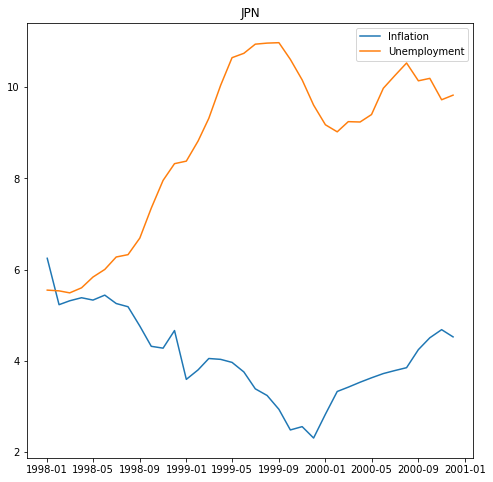

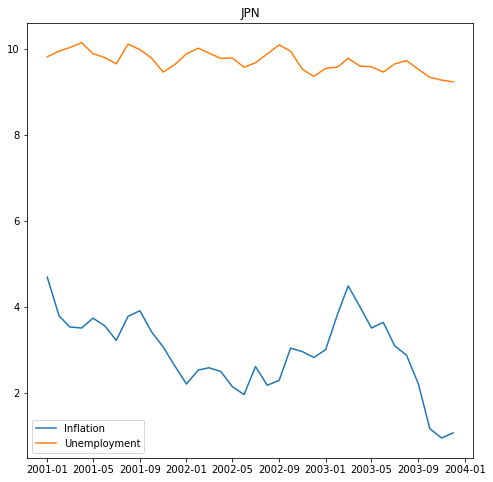

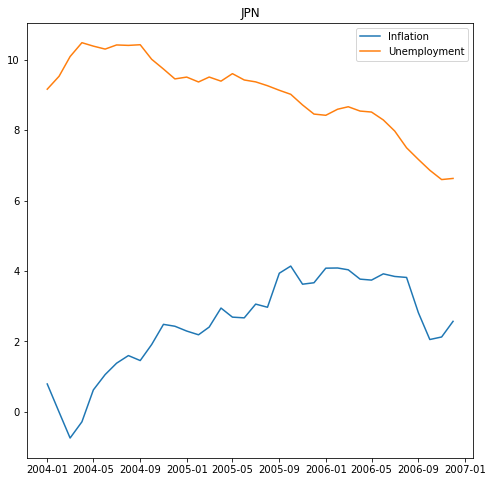

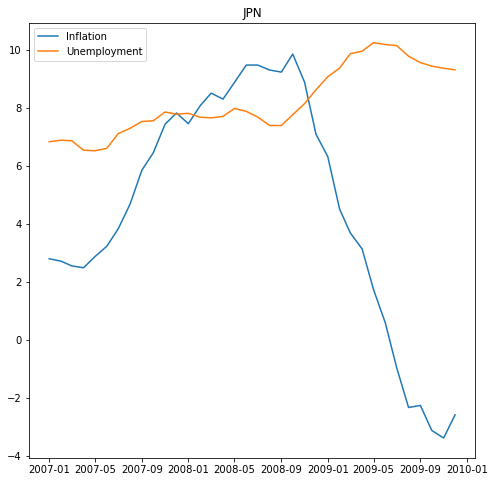

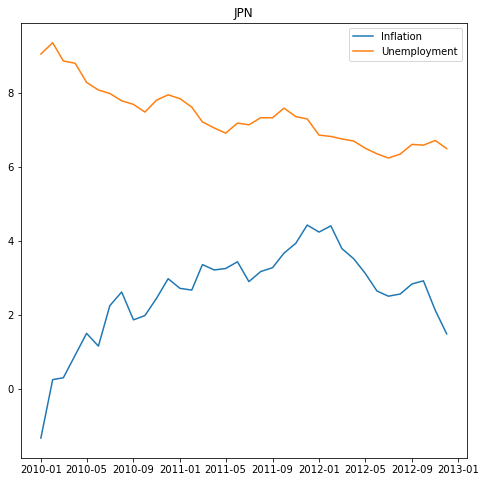

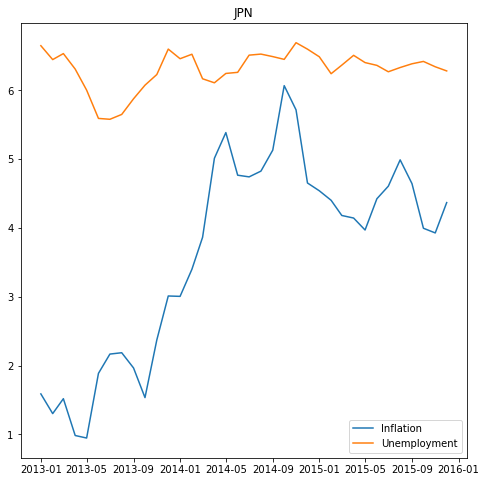

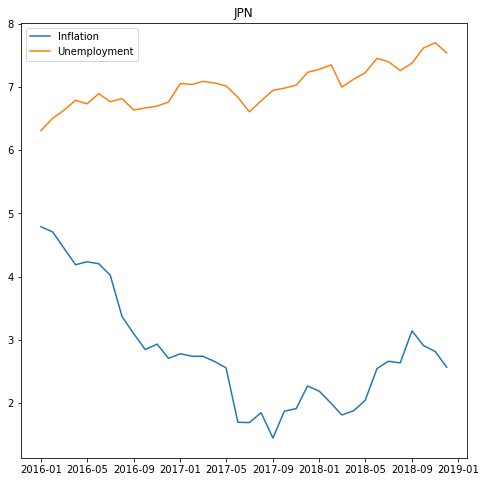

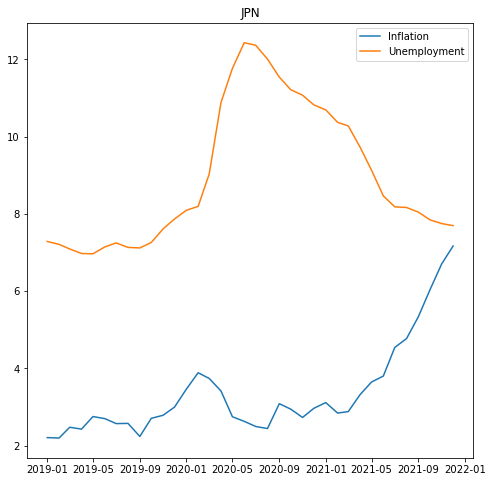

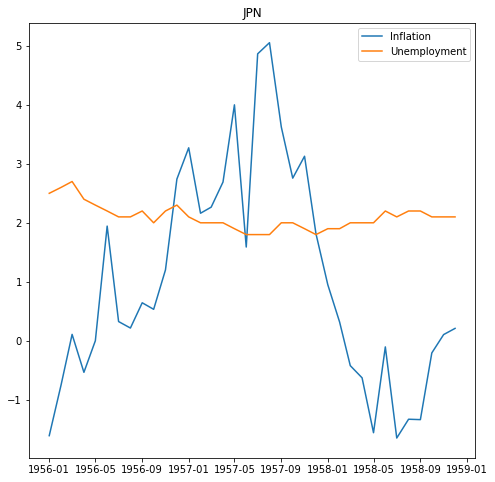

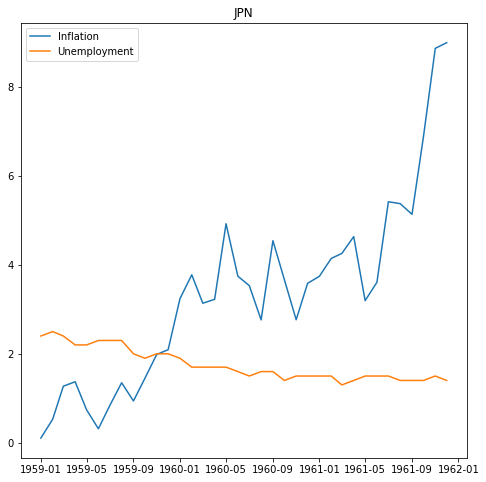

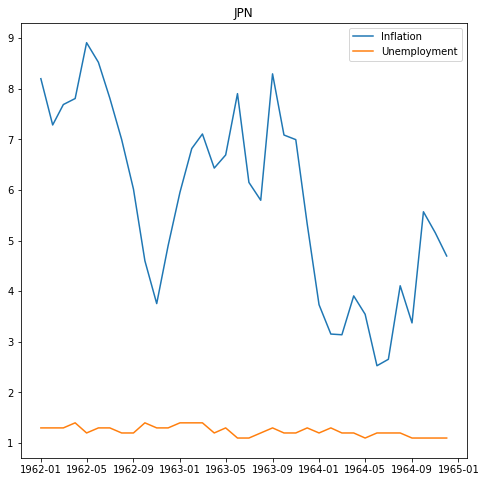

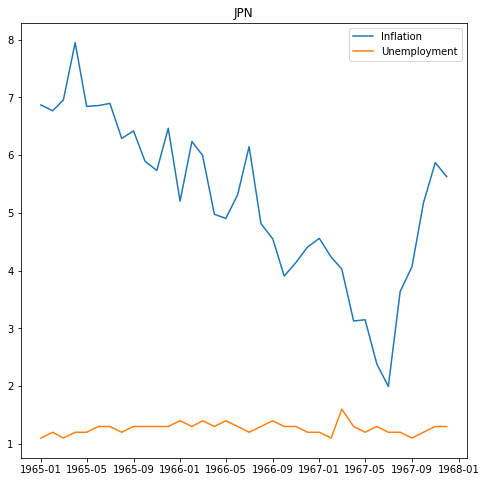

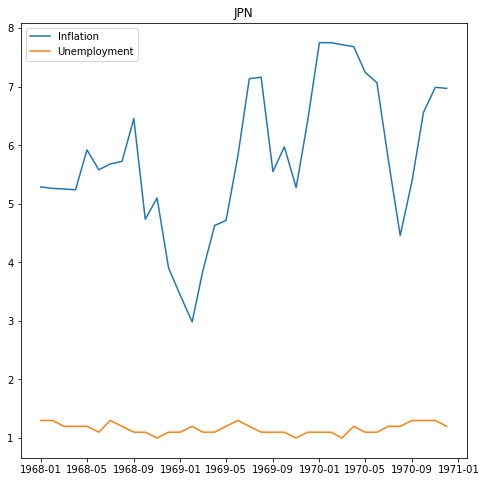

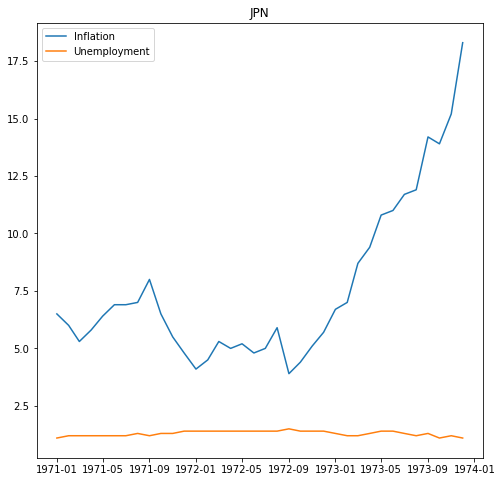

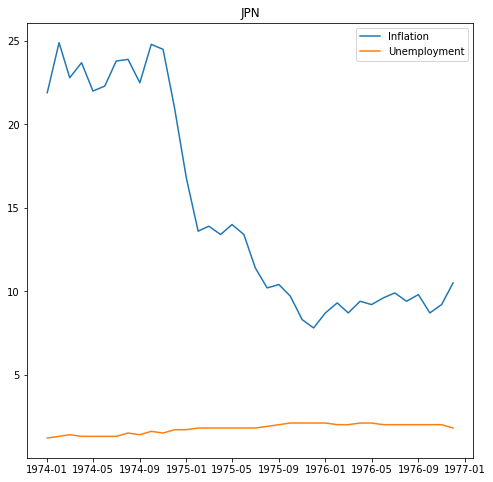

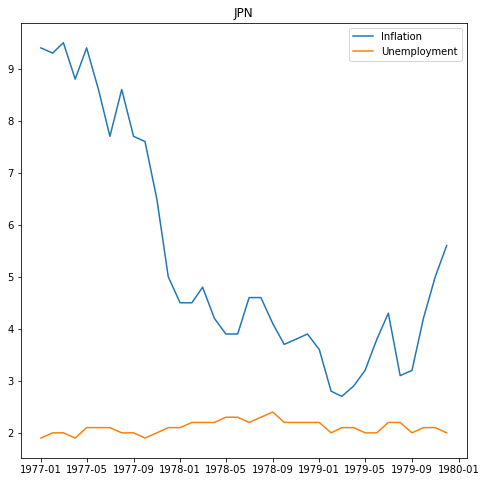

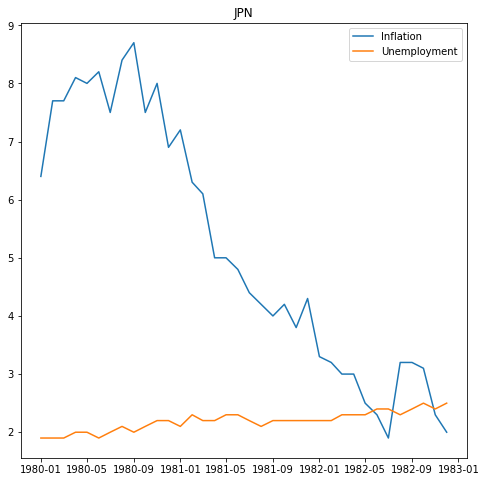

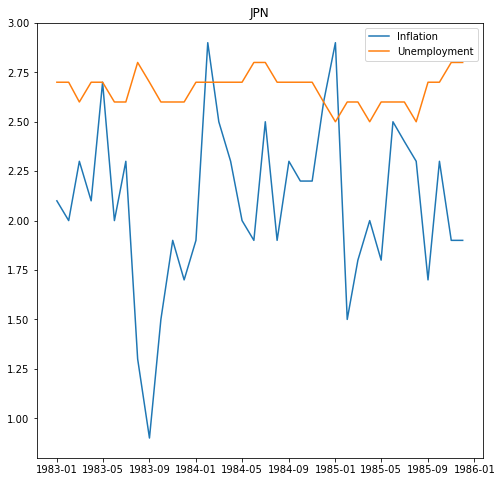

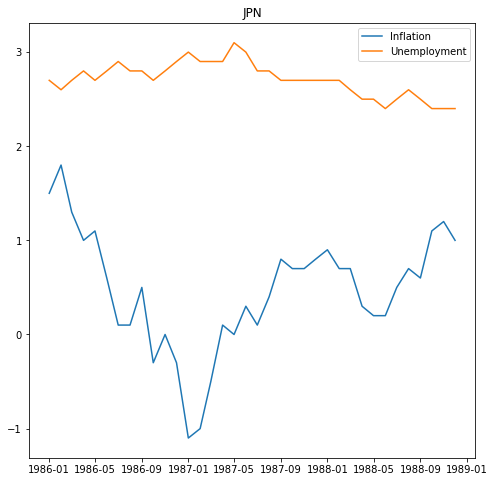

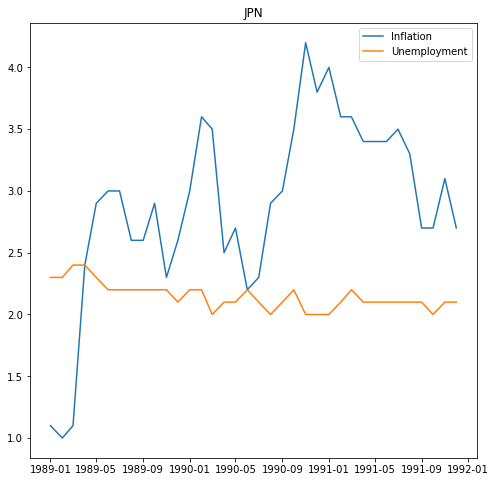

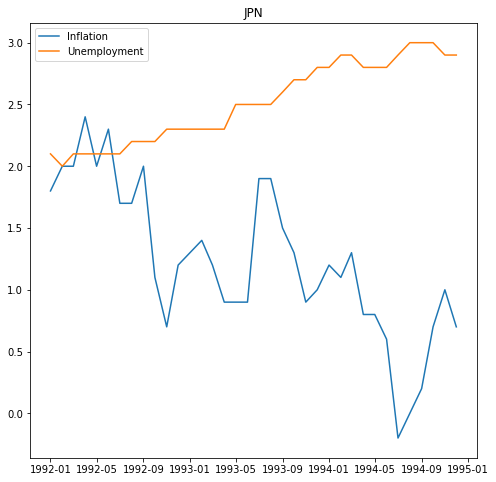

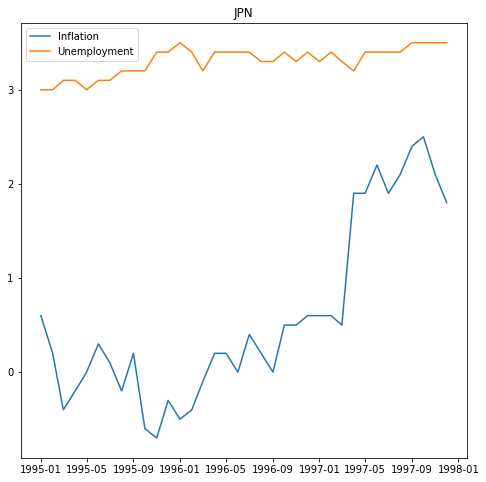

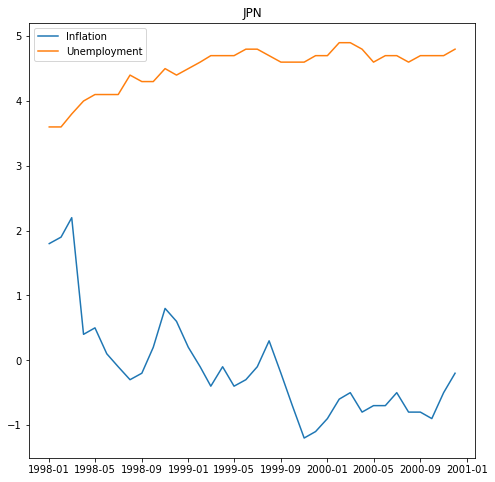

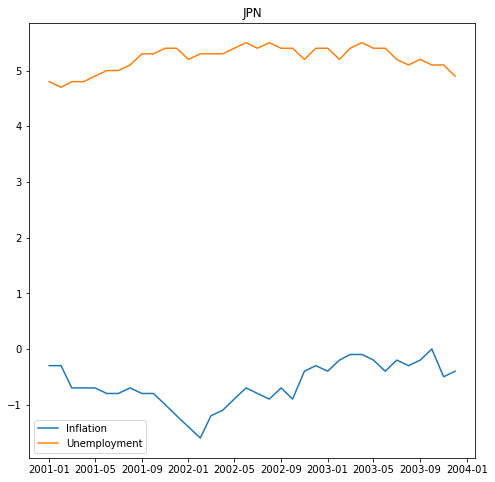

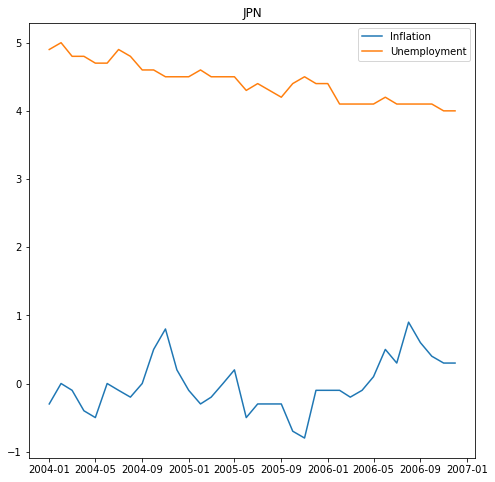

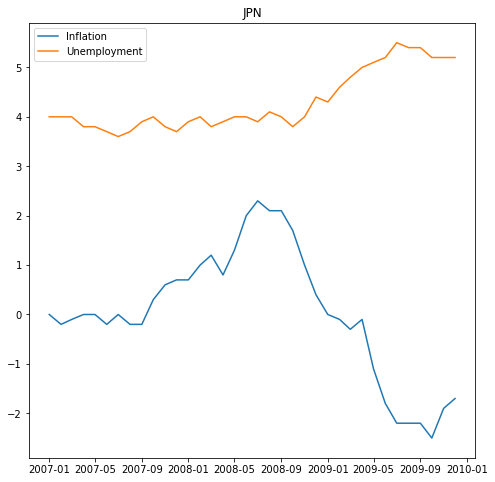

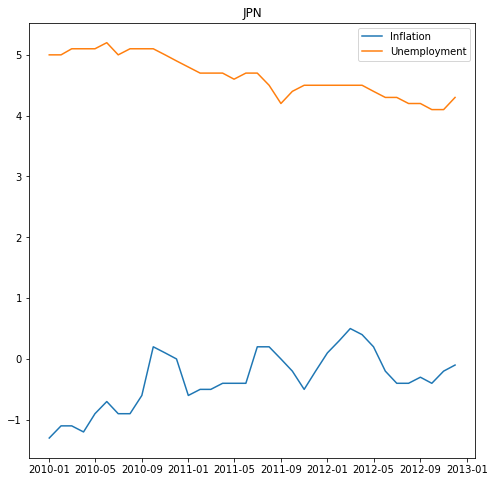

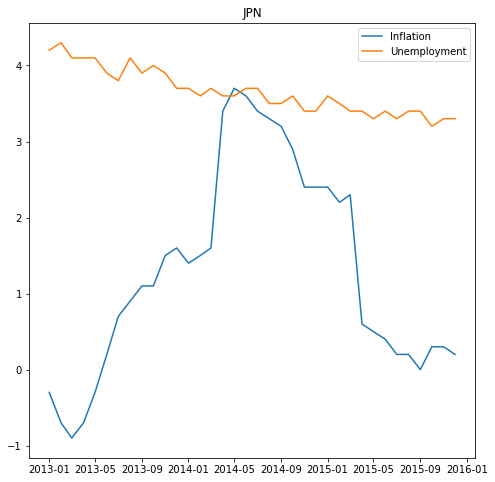

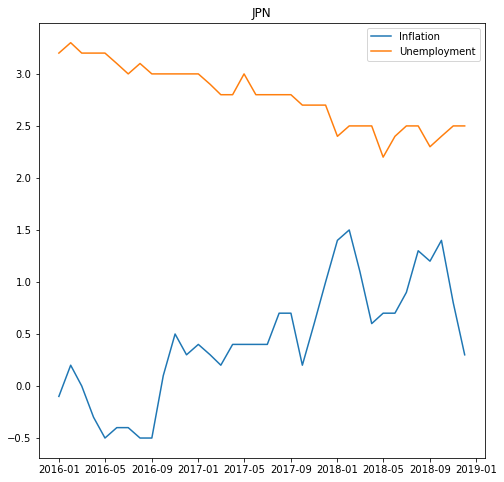

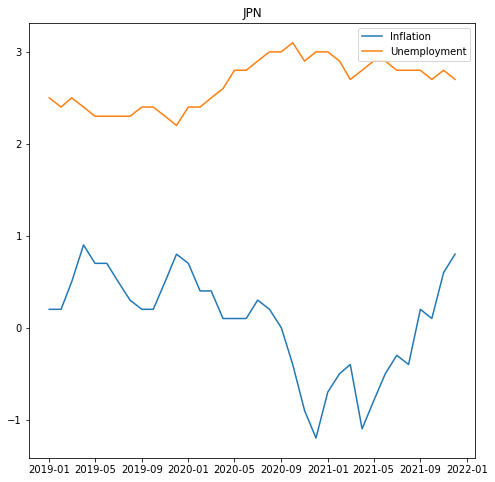

In [140]:
plt_num = 0
for country in country_list:
    for span in range(int(len(country[0])/36)):
        # 3 years = 36 samples
        span = span * 36
        plt.figure(plt_num, figsize=(8, 8))
        plt.plot(country[0]["TIME"][span:span + 36], country[0]["Value"][span:span + 36])
        plt.plot(country[1]["TIME"][span:span + 36], country[1]["Value"][span:span + 36])
        plt.legend(["Inflation", "Unemployment"])
        plt.title(location)
        plt.show
        plt_num += 1

In [27]:
span_start_idx = 0
country_and_fits = []
for country in country_list:
    span = len(country[0])
    fit1, fit2 = sample_models(country=country, span=span, span_start_idx=span_start_idx, model1=model_linear, model2=model_phillips)
    data = country, fit1, fit2
    country_and_fits.append(data)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status







chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)
chain 1 |████▋     | 00:00 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |██████▍   | 00:00 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |████████▏ | 00:00 Iteration: 1100 / 1500 [ 73%]  (Sampling)
chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)

chain 1 |█▊        | 00:00 Iteration:  100 / 1500 [  6%]  (Warmup)
chain 1 |██▎       | 00:00 Iteration:  200 / 1500 [ 13%]  (Warmup)

chain 1 |███▌      | 00:01 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |████▋     | 00:01 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:01 Iteration:  600 / 1500 [ 40%]  (Sampling)




chain 1 |█████▉    | 00:01 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:01 Iteration:  800 / 1500 [ 53%]  (Sampling)




chain 1 |███████   | 00:02 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:02 Iteration: 1000 / 1500 [ 66%]  (Sampling)

chain 1 |████████▏ | 00:02 Iteration: 1100 / 1500 [ 73%]  (Sampling)




chain 1 |████████▊ | 00:02 Iteration: 1200 / 1500 [ 80%]  (Sampling)
chain 1 |█████████▍| 00:02 Iteration: 1300 / 1500 [ 86%]  (Sampling)
chain 1 |███


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |████▋     | 00:00 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |██████▍   | 00:00 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |████████▏ | 00:00 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)








chain 1 |█▊        | 00:01 Iteration:  100 / 1500 [  6%]  (Warmup)





chain 1 |██▎       | 00:01 Iteration:  200 / 1500 [ 13%]  (Warmup)




chain 1 |██▉       | 00:02 Iteration:  300 / 1500 [ 20%]  (Warmup)






chain 1 |███▌      | 00:02 Iteration:  400 / 1500 [ 26%]  (Warmup)






chain 1 |████▋     | 00:02 Iteration:  501 / 1500 [ 33%]  (Sampling)
chain 1 |█████▎    | 00:03 Iteration:  600 / 1500 [ 40%]  (Sampling)
chain 1 |█████▉    | 00:03 Iteration:  700 / 1500 [ 46%]  (Sampling)
chain 1 |██████▍   | 00:04 Iteration:  800 / 1500 [ 53%]  (Sampling)
chain 1 |███████   | 00:04 Iteration:  900 / 1500 [ 60%]  (Sampling)
chain 1 |███████▋  | 00:04 Iteration: 1000 / 1500 [ 66%]  (Sampling)
chain 1 |████████▏ | 00:05 Iteration: 1100 / 1500 [ 73%]  (Sampling)
chain 1 |████████▊ | 00:05 Iteration: 1200 / 1500 [ 80%]  (Sampling)
chain 


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)




chain 1 |████▋     | 00:00 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |██████▍   | 00:00 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |████████▏ | 00:00 Iteration: 1100 / 1500 [ 73%]  (Sampling)

chain 1 |█████████▍| 00:00 Iteration: 1300 / 1500 [ 86%]  (Sampling)

chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  100 / 1500 [  6%]  (Warmup)

chain 1 |██▎       | 00:00 Iteration:  200 / 1500 [ 13%]  (Warmup)
chain 1 |██▉       | 00:01 Iteration:  300 / 1500 [ 20%]  (Warmup)


chain 1 |███▌      | 00:01 Iteration:  400 / 1500 [ 26%]  (Warmup)




chain 1 |████▋     | 00:01 Iteration:  501 / 1500 [ 33%]  (Sampling)
chain 1 |█████▎    | 00:01 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |█████▉    | 00:02 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:02 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:02 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:02 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:03 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:03 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |█████


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |██▉       | 00:00 Iteration:  300 / 1500 [ 20%]  (Warmup)


chain 1 |████▋     | 00:00 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |██████▍   | 00:00 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▊ | 00:01 Iteration: 1200 / 1500 [ 80%]  (Sampling)
chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  100 / 1500 [  6%]  (Warmup)





chain 1 |██▎       | 00:01 Iteration:  200 / 1500 [ 13%]  (Warmup)











chain 1 |██▉       | 00:03 Iteration:  300 / 1500 [ 20%]  (Warmup)


chain 1 |███▌      | 00:03 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |████▋     | 00:04 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:04 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |█████▉    | 00:04 Iteration:  700 / 1500 [ 46%]  (Sampling)




chain 1 |██████▍   | 00:05 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:05 Iteration:  900 / 1500 [ 60%]  (Sampling)
chain 1 |██████████| 00:06 Sampling completed                       
chain 2 |██████████| 00:06 Sampling completed                       
chain 3 |██████████| 00:06 Sampling completed                       
ch


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  100 / 1500 [  6%]  (Warmup)
chain 1 |███▌      | 00:00 Iteration:  400 / 1500 [ 26%]  (Warmup)




chain 1 |█████▎    | 00:00 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |██████▍   | 00:00 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████▋  | 00:00 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▊ | 00:01 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |██████████| 00:01 Iteration: 1400 / 1500 [ 93%]  (Sampling)


chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▏        | 00:01 Iteration:    1 / 1500 [  0%]  (Warmup)

chain 1 |█▊        | 00:02 Iteration:  100 / 1500 [  6%]  (Warmup)




chain 1 |██▎       | 00:02 Iteration:  200 / 1500 [ 13%]  (Warmup)


chain 1 |██▉       | 00:03 Iteration:  300 / 1500 [ 20%]  (Warmup)


chain 1 |███▌      | 00:04 Iteration:  400 / 1500 [ 26%]  (Warmup)



chain 1 |████▋     | 00:05 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:06 Iteration:  600 / 1500 [ 40%]  (Sampling)




chain 1 |█████▉    | 00:06 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:07 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:07 Iteration:  900 / 1500 [ 60%]  (Sampling)

chain 1 |███████▋  | 00:08 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:08 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:09 Iteration: 1200 / 1500 [ 80%]  (Sampling)
chain 1 


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  200 / 1500 [ 13%]  (Warmup)
chain 1 |████      | 00:00 Iteration:  500 / 1500 [ 33%]  (Warmup)



chain 1 |█████▉    | 00:01 Iteration:  700 / 1500 [ 46%]  (Sampling)




chain 1 |███████   | 00:01 Iteration:  900 / 1500 [ 60%]  (Sampling)






chain 1 |████████▏ | 00:01 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:02 Iteration: 1200 / 1500 [ 80%]  (Sampling)
chain 1 |█████████▍| 00:03 Iteration: 1300 / 1500 [ 86%]  (Sampling)
chain 1 |██████████| 00:03 Sampling completed                       
chain 2 |██████████| 00:03 Sampling completed                       
chain 3 |██████████| 00:03 Sampling completed                       
chain 4 |██████████| 00:03 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |█▏        | 00:01 Iteration:    1 / 1500 [  0%]  (Warmup)
chain 1 |█▊        | 00:04 Iteration:  100 / 1500 [  6%]  (Warmup)


chain 1 |██▎       | 00:04 Iteration:  200 / 1500 [ 13%]  (Warmup)


chain 1 |██▉       | 00:04 Iteration:  300 / 1500 [ 20%]  (Warmup)


chain 1 |███▌      | 00:05 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |████▋     | 00:05 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:06 Iteration:  600 / 1500 [ 40%]  (Sampling)

chain 1 |█████▉    | 00:06 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:06 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:07 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:09 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:09 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:10 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |████


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)
chain 1 |██▎       | 00:00 Iteration:  200 / 1500 [ 13%]  (Warmup)

chain 1 |███▌      | 00:00 Iteration:  400 / 1500 [ 26%]  (Warmup)




chain 1 |████▋     | 00:00 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▉    | 00:01 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |███████   | 00:01 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:01 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:02 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |█████████▍| 00:02 Iteration: 1300 / 1500 [ 86%]  (Sampling)


chain 1 |██████████| 00:02 Iteration: 1400 / 1500 [ 93%]  (Sampling)

chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed                       
chain 3 |███


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▏        | 00:01 Iteration:    1 / 1500 [  0%]  (Warmup)






chain 1 |█▊        | 00:03 Iteration:  100 / 1500 [  6%]  (Warmup)


chain 1 |██▎       | 00:04 Iteration:  200 / 1500 [ 13%]  (Warmup)




chain 1 |██▉       | 00:05 Iteration:  300 / 1500 [ 20%]  (Warmup)


chain 1 |███▌      | 00:06 Iteration:  400 / 1500 [ 26%]  (Warmup)




chain 1 |████▋     | 00:07 Iteration:  501 / 1500 [ 33%]  (Sampling)




chain 1 |█████▎    | 00:08 Iteration:  600 / 1500 [ 40%]  (Sampling)




chain 1 |█████▉    | 00:10 Iteration:  700 / 1500 [ 46%]  (Sampling)



chain 1 |██████▍   | 00:11 Iteration:  800 / 1500 [ 53%]  (Sampling)
chain 1 |███████   | 00:12 Iteration:  900 / 1500 [ 60%]  (Sampling)
chain 1 |███████▋  | 00:13 Iteration: 1000 / 1500 [ 66%]  (Sampling)
chain 1 |████████▏ | 00:14 Iteration: 1100 / 1500 [ 73%]  (Sampling)
chain 1 |████████▊ | 00:15 Iteration: 1200 / 1500 [ 80%]  (Sampling)
chain 


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  200 / 1500 [ 13%]  (Warmup)


chain 1 |███▌      | 00:00 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |████▋     | 00:00 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▉    | 00:01 Iteration:  700 / 1500 [ 46%]  (Sampling)

chain 1 |██████▍   | 00:01 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:01 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:02 Iteration: 1000 / 1500 [ 66%]  (Sampling)
chain 1 |████████▏ | 00:03 Iteration: 1100 / 1500 [ 73%]  (Sampling)




chain 1 |████████▊ | 00:03 Iteration: 1200 / 1500 [ 80%]  (Sampling)
chain 1 |█████████▍| 00:03 Iteration: 1300 / 1500 [ 86%]  (Sampling)


chain 1 |██████████| 00:03 Iteration: 1400 / 1500 [ 93%]  (Sampling)

chain 1 |██████████| 00:03 Sampling completed                       
chain 2 |█


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▏        | 00:01 Iteration:    1 / 1500 [  0%]  (Warmup)













chain 1 |█▊        | 00:02 Iteration:  100 / 1500 [  6%]  (Warmup)







chain 1 |██▎       | 00:03 Iteration:  200 / 1500 [ 13%]  (Warmup)





chain 1 |██▉       | 00:04 Iteration:  300 / 1500 [ 20%]  (Warmup)







chain 1 |███▌      | 00:05 Iteration:  400 / 1500 [ 26%]  (Warmup)





chain 1 |████▋     | 00:06 Iteration:  501 / 1500 [ 33%]  (Sampling)

chain 1 |█████▎    | 00:07 Iteration:  600 / 1500 [ 40%]  (Sampling)
chain 1 |██████████| 00:13 Sampling completed                       
chain 2 |██████████| 00:13 Sampling completed                       
chain 3 |██████████| 00:13 Sampling completed                       
chain 4 |██████████| 00:13 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status







chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)
chain 1 |██▉       | 00:00 Iteration:  300 / 1500 [ 20%]  (Warmup)


chain 1 |████▋     | 00:00 Iteration:  501 / 1500 [ 33%]  (Sampling)

chain 1 |█████▉    | 00:00 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |███████   | 00:00 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |████████▏ | 00:01 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |█████████▍| 00:01 Iteration: 1300 / 1500 [ 86%]  (Sampling)
chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▏        | 00:01 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |█▊        | 00:03 Iteration:  100 / 1500 [  6%]  (Warmup)

chain 1 |██▎       | 00:04 Iteration:  200 / 1500 [ 13%]  (Warmup)


chain 1 |██▉       | 00:04 Iteration:  300 / 1500 [ 20%]  (Warmup)


chain 1 |███▌      | 00:05 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |████▋     | 00:06 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:07 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |█████▉    | 00:07 Iteration:  700 / 1500 [ 46%]  (Sampling)
chain 1 |██████▍   | 00:08 Iteration:  800 / 1500 [ 53%]  (Sampling)



chain 1 |███████   | 00:09 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:09 Iteration: 1000 / 1500 [ 66%]  (Sampling)




chain 1 |████████▏ | 00:10 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:12 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |██▉       | 00:00 Iteration:  300 / 1500 [ 20%]  (Warmup)


chain 1 |████▋     | 00:00 Iteration:  501 / 1500 [ 33%]  (Sampling)

chain 1 |█████▉    | 00:00 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |███████   | 00:01 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |████████▏ | 00:01 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:01 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |█████████▍| 00:01 Iteration: 1300 / 1500 [ 86%]  (Sampling)


chain 1 |██████████| 00:01 Iteration: 1400 / 1500 [ 93%]  (Sampling)


chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed                       
chain 3 |██████████| 00:02 Sampling completed                       
chain 4 |██████████| 00:02 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  100 / 1500 [  6%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  200 / 1500 [ 13%]  (Warmup)

chain 1 |██▉       | 00:02 Iteration:  300 / 1500 [ 20%]  (Warmup)



chain 1 |███▌      | 00:03 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |████▋     | 00:04 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:04 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |█████▉    | 00:05 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:05 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:06 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:06 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:06 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:07 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |


INFO:cmdstanpy:CmdStan done processing.


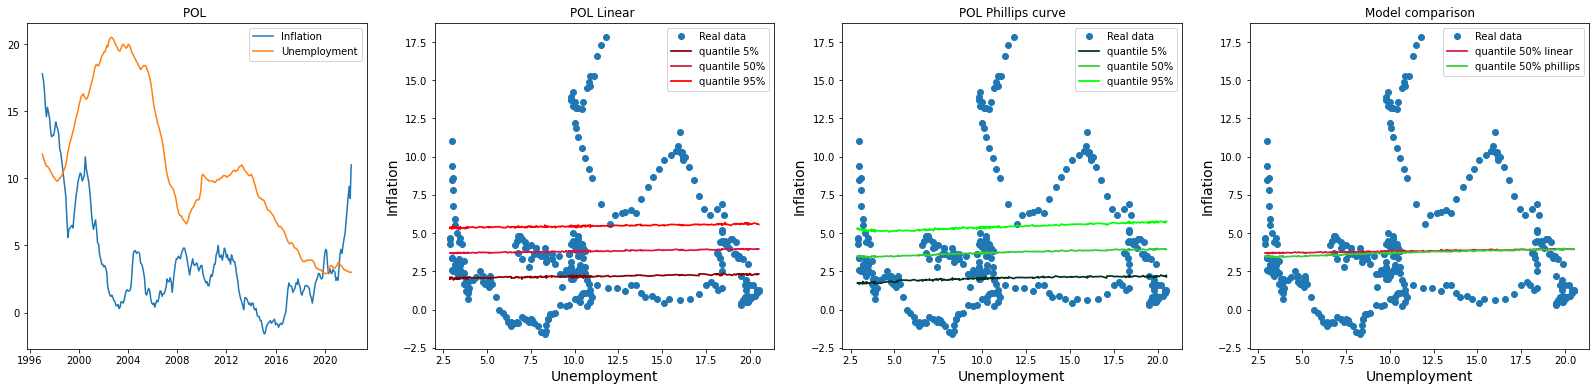

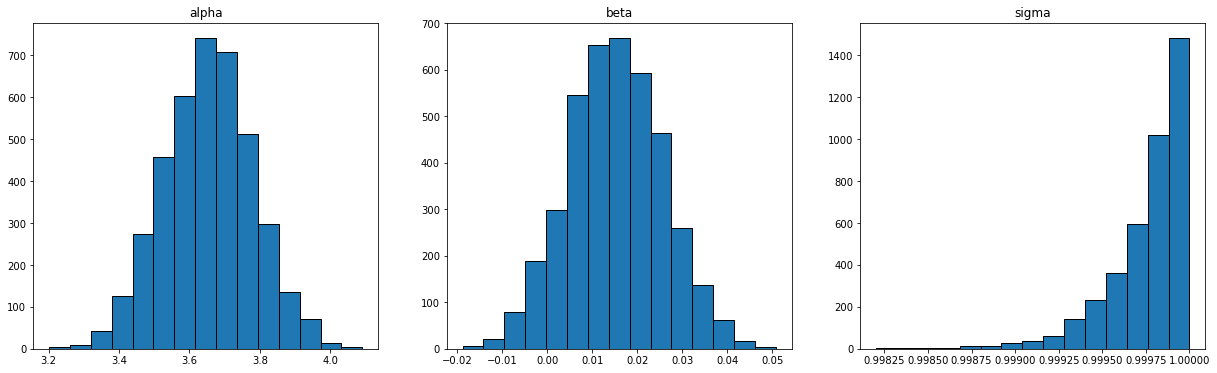

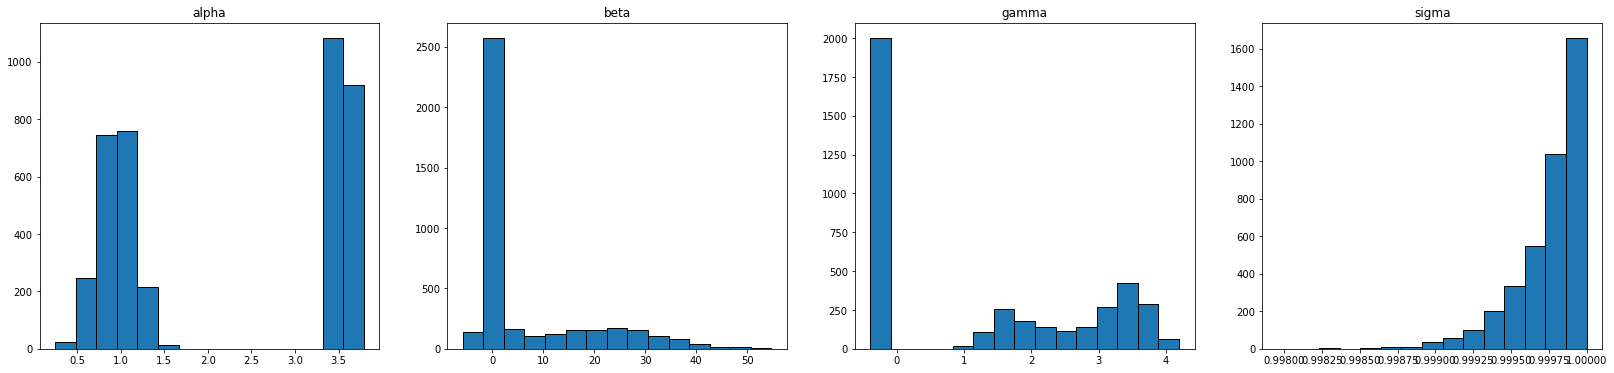

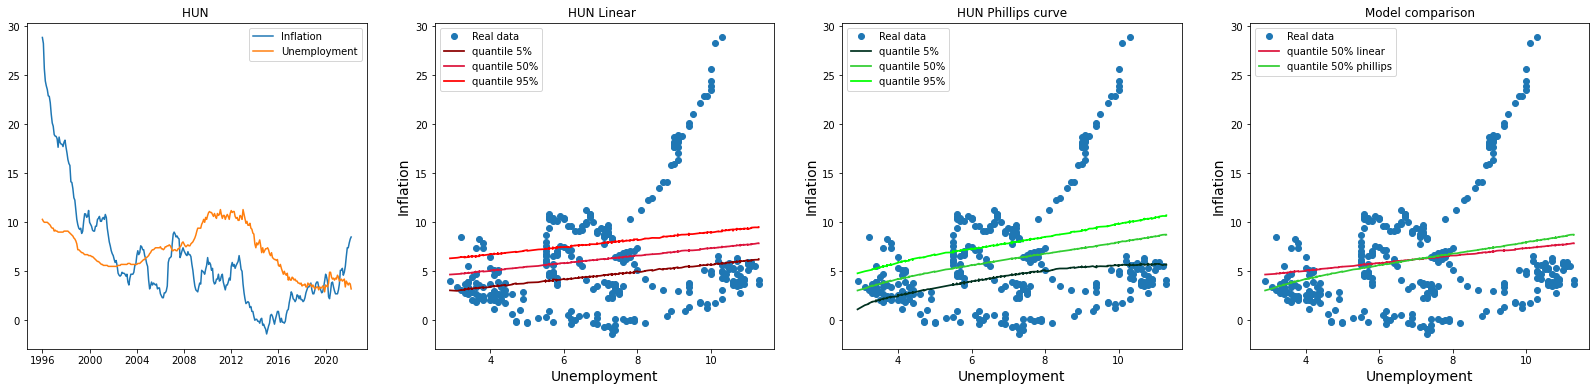

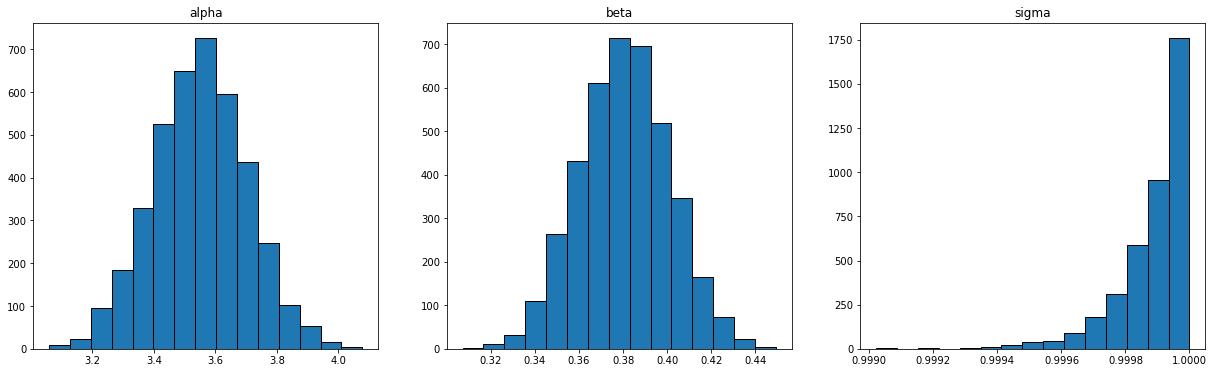

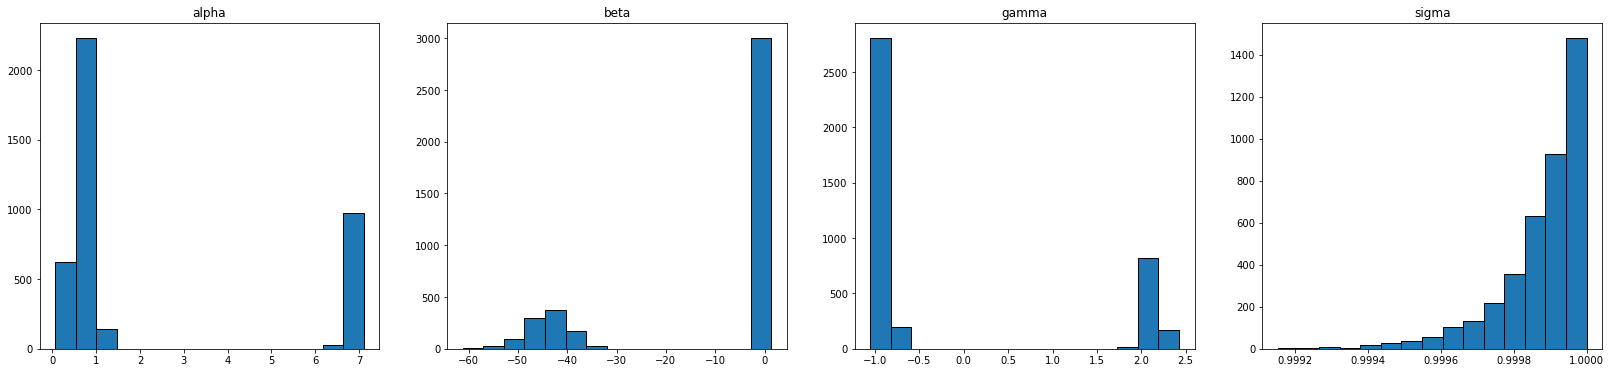

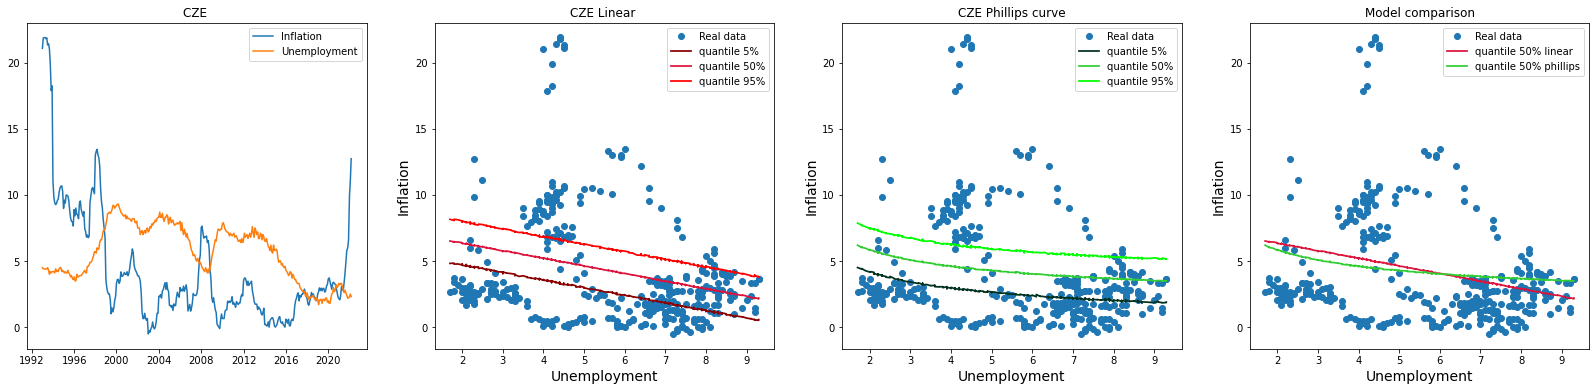

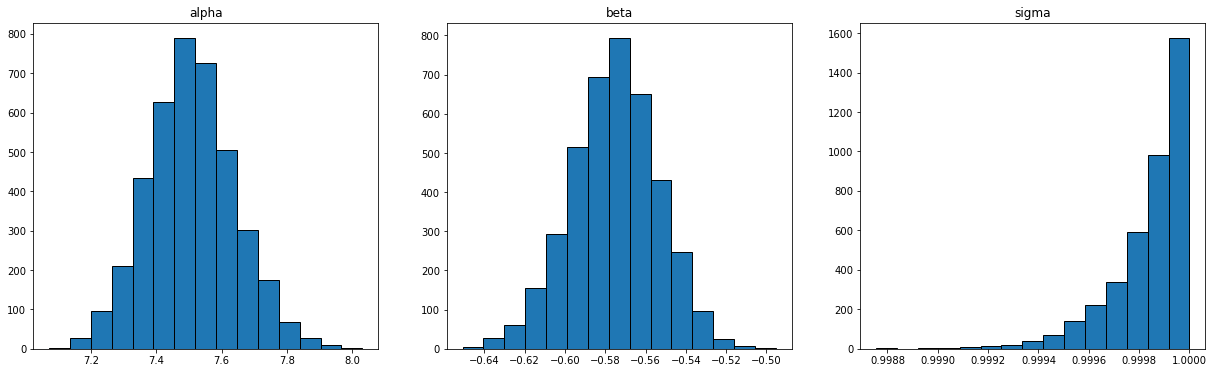

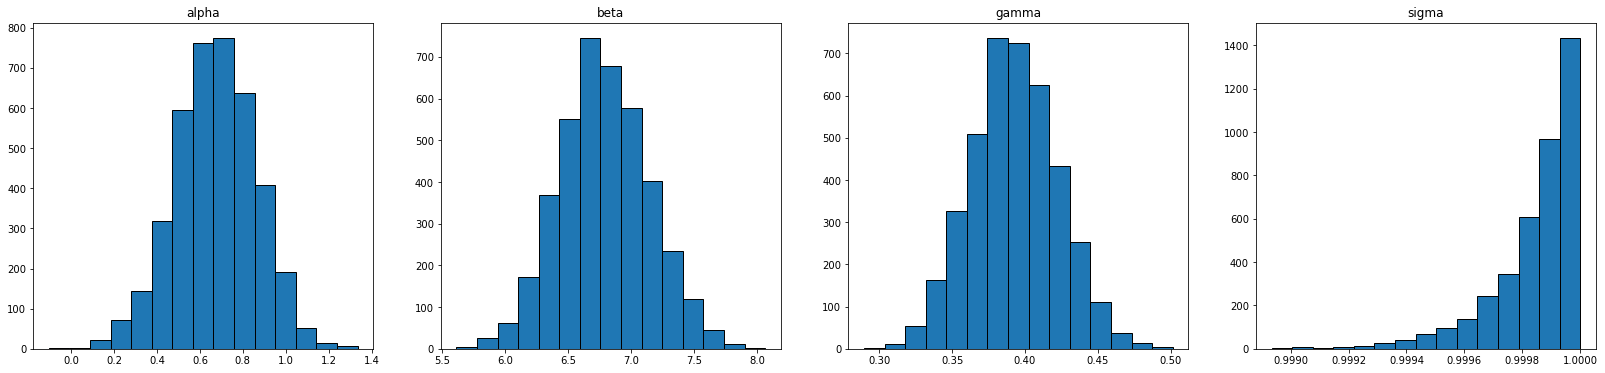

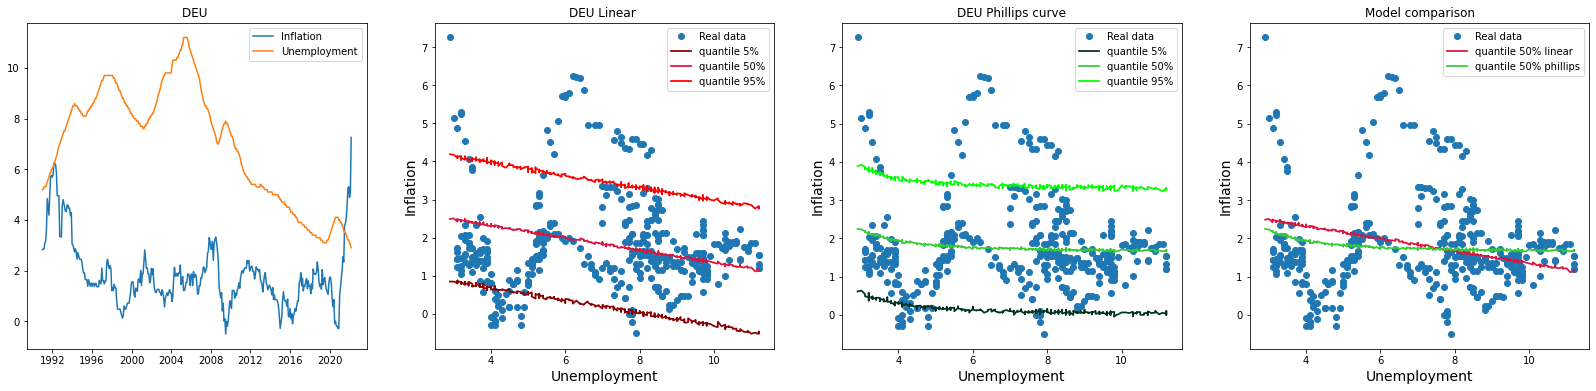

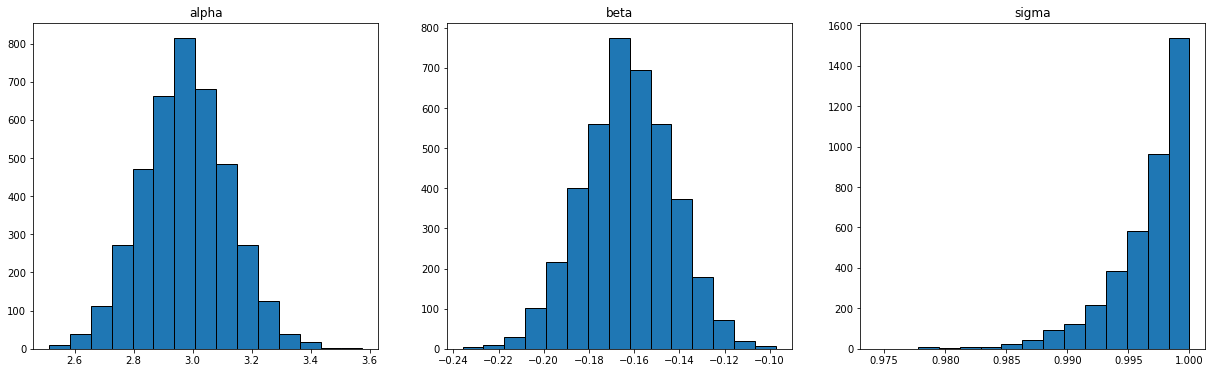

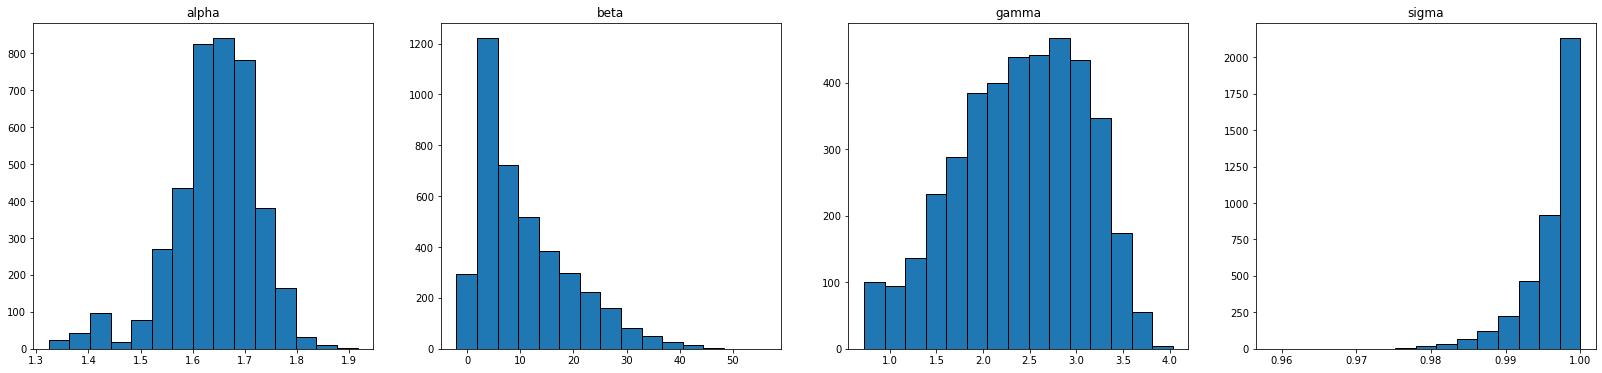

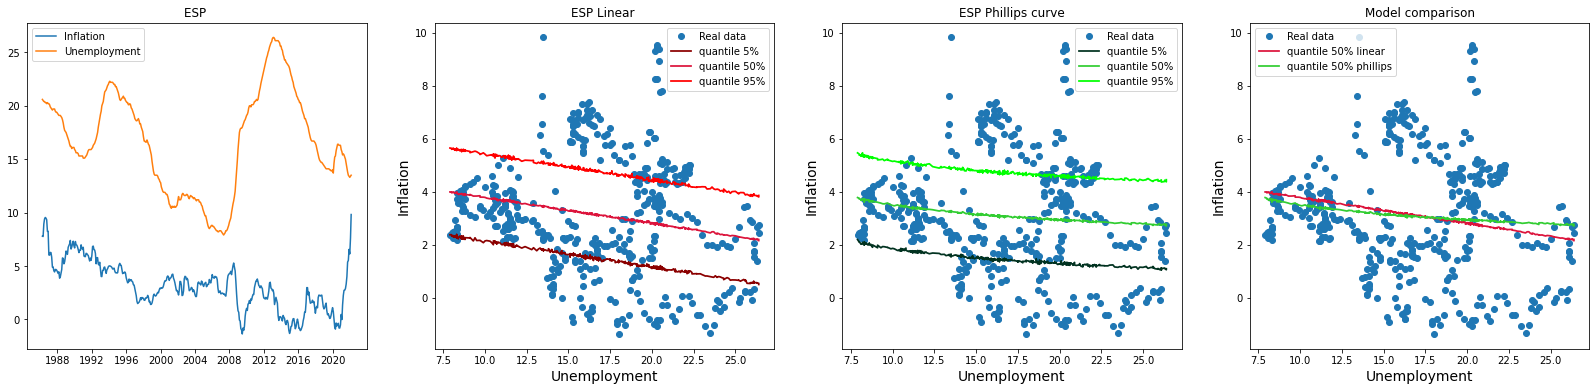

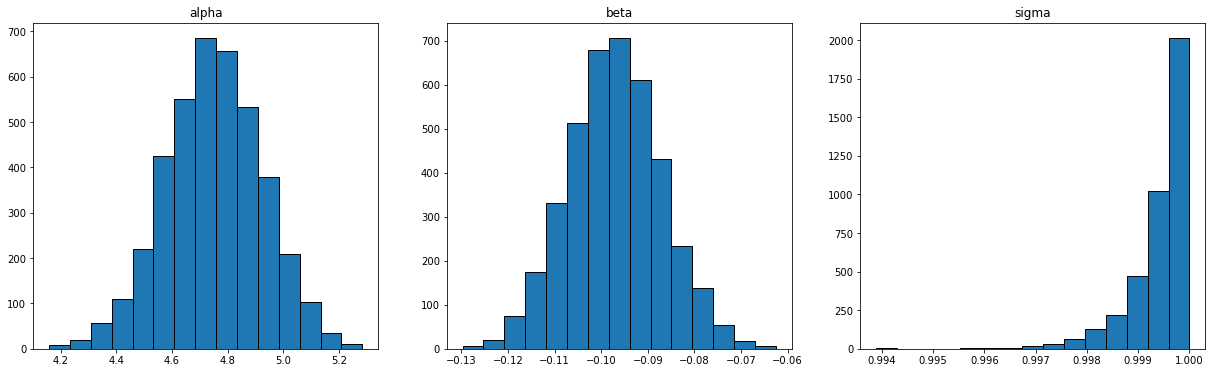

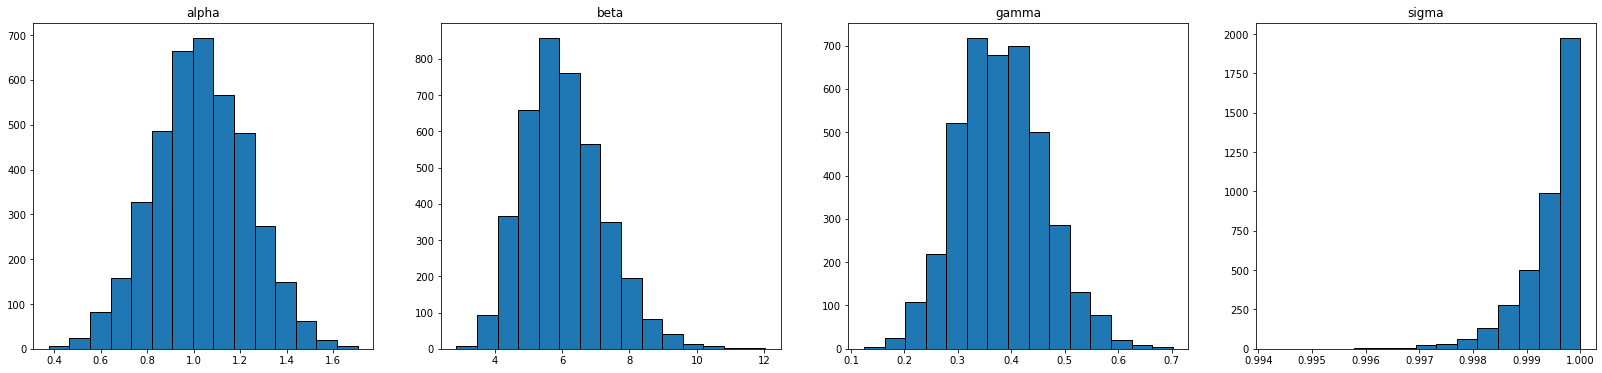

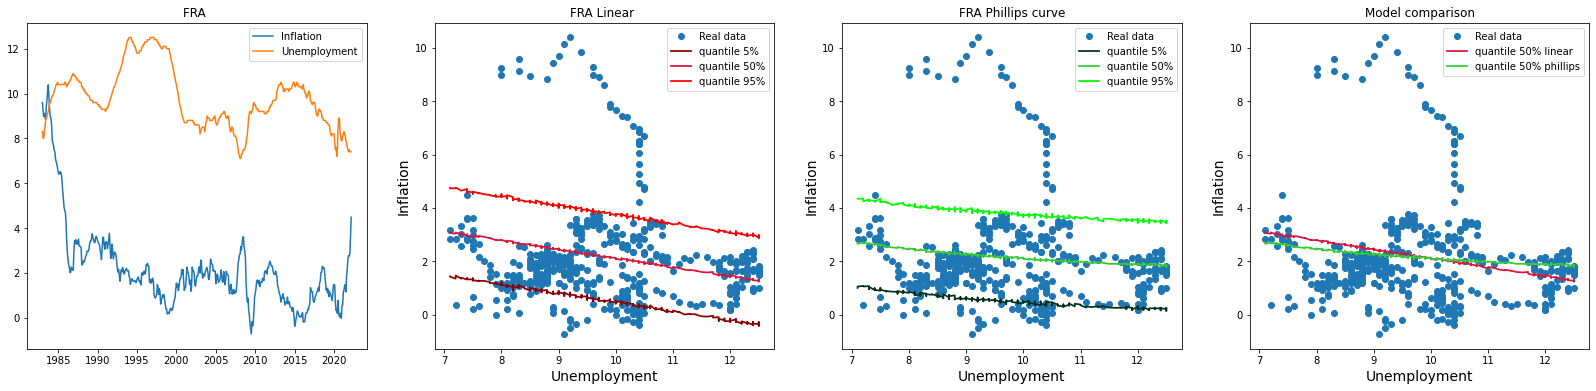

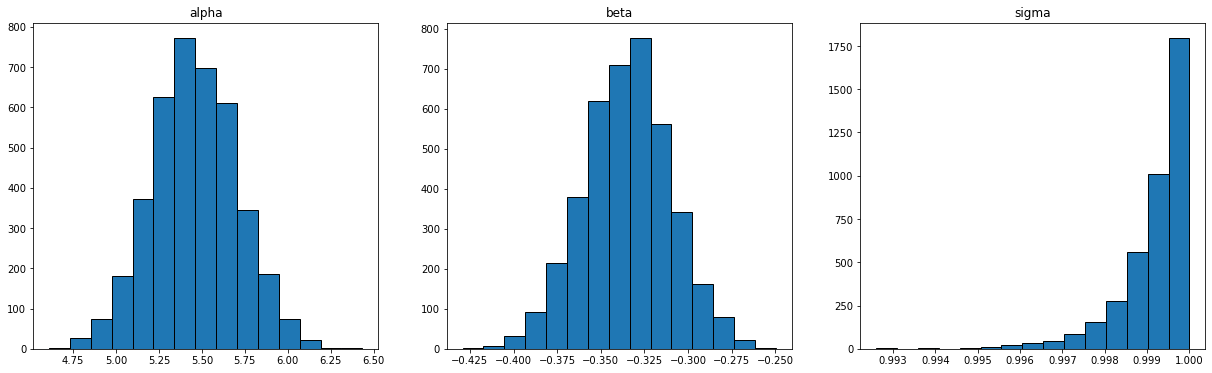

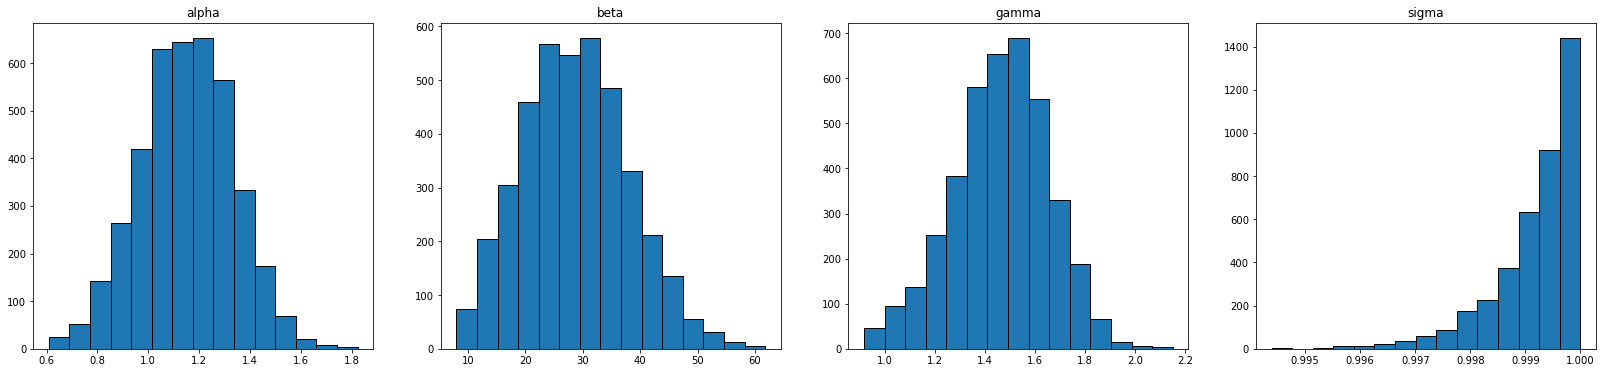

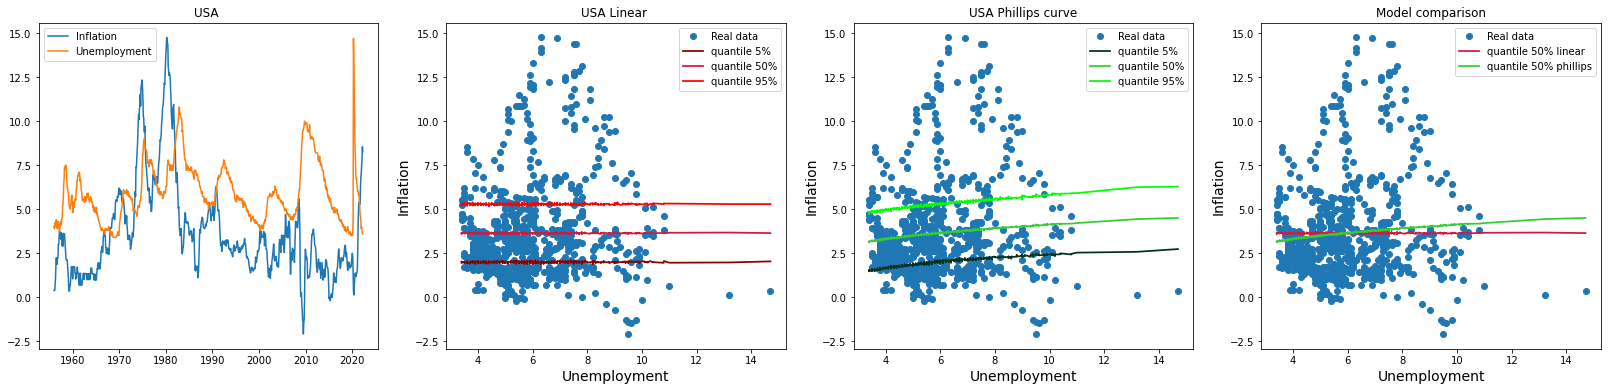

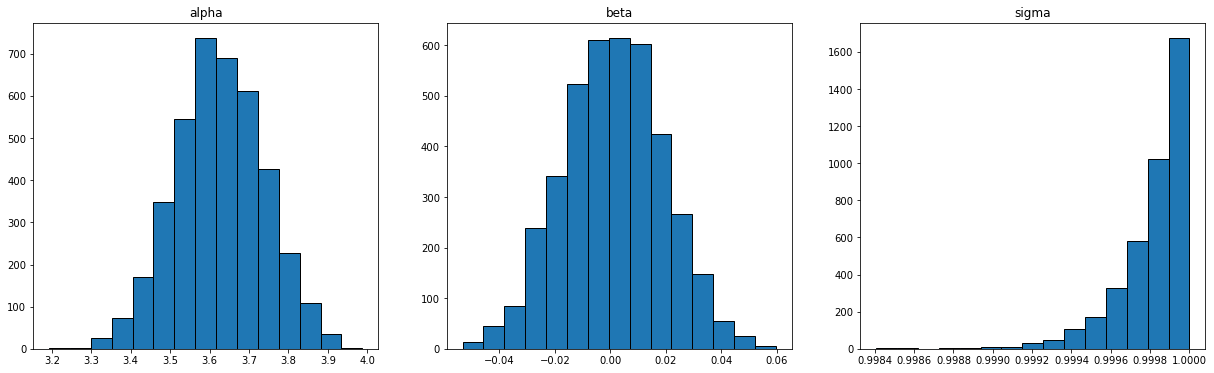

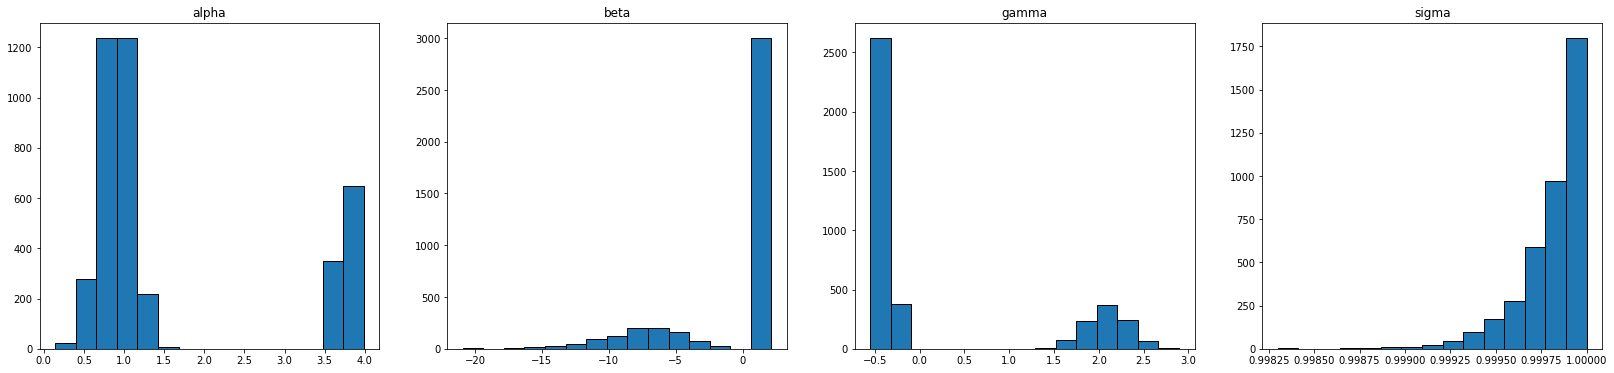

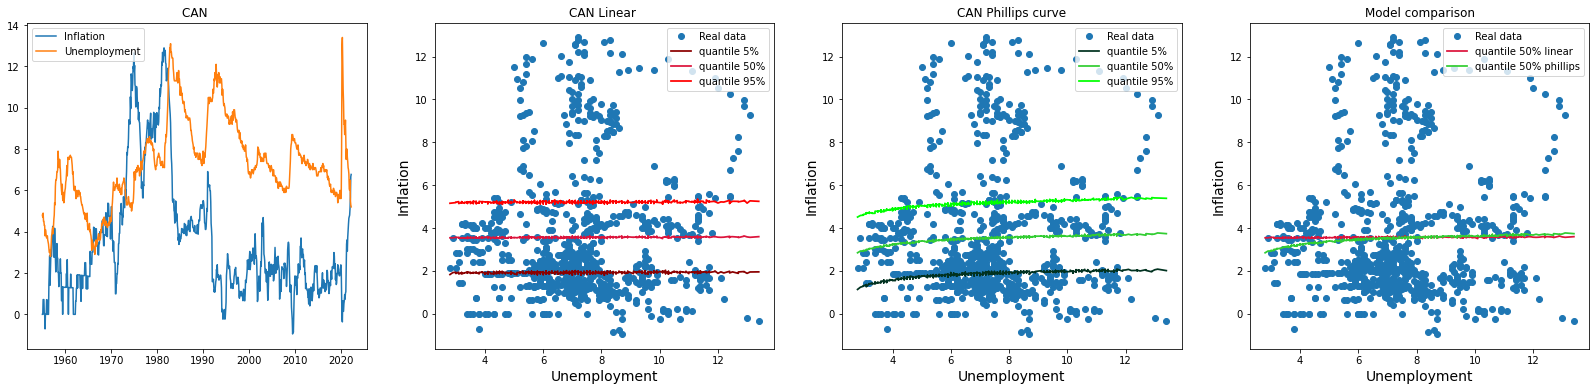

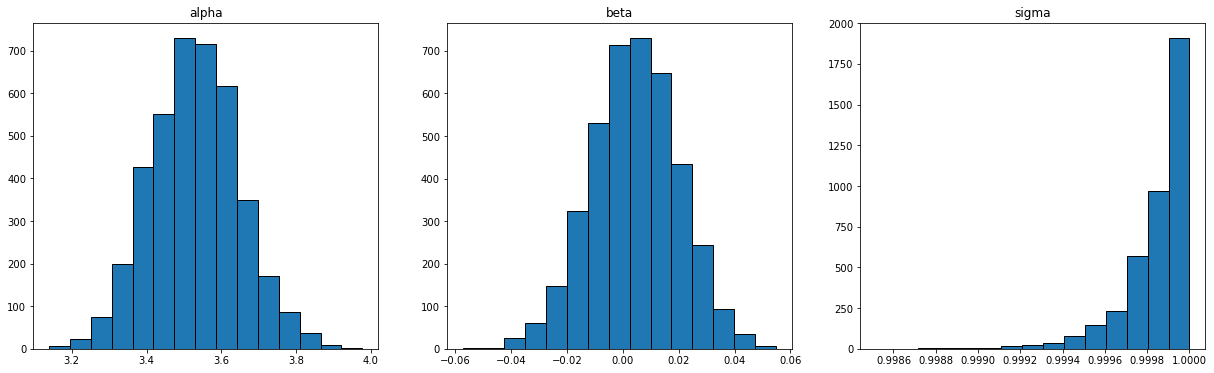

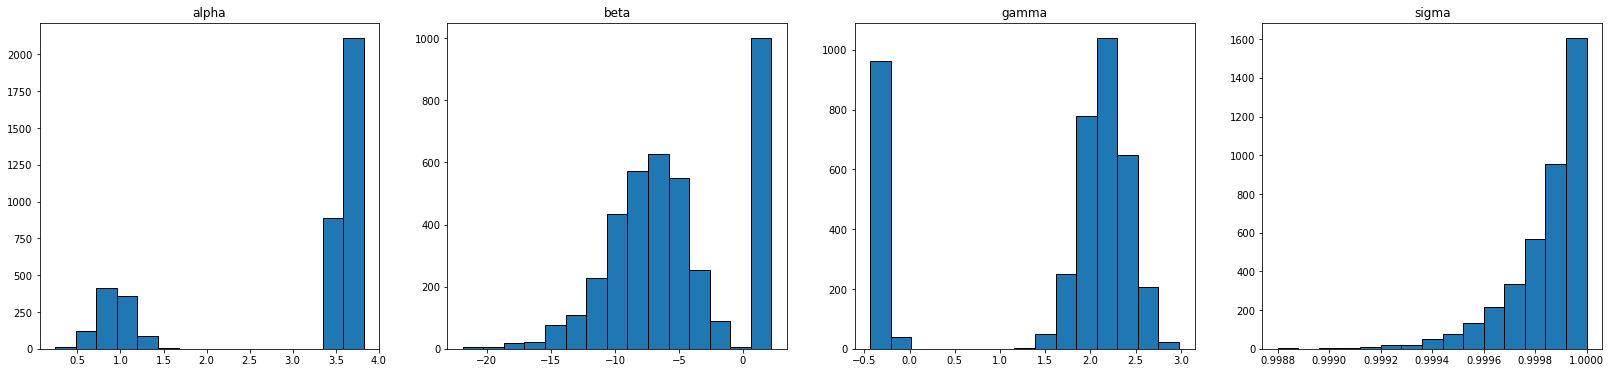

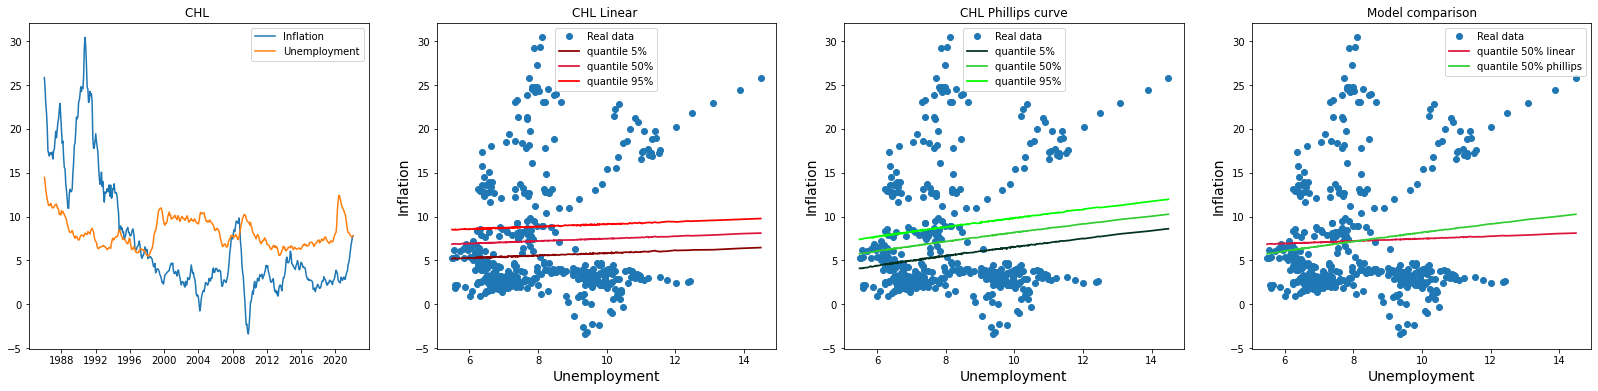

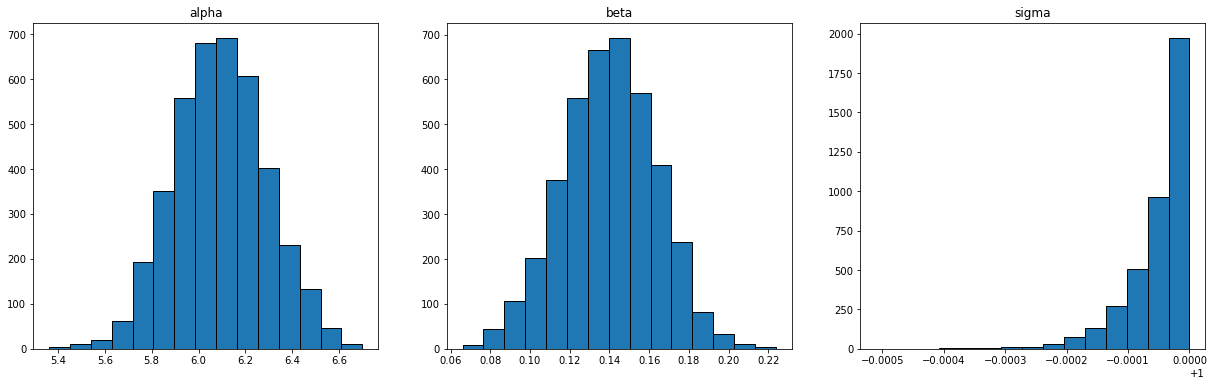

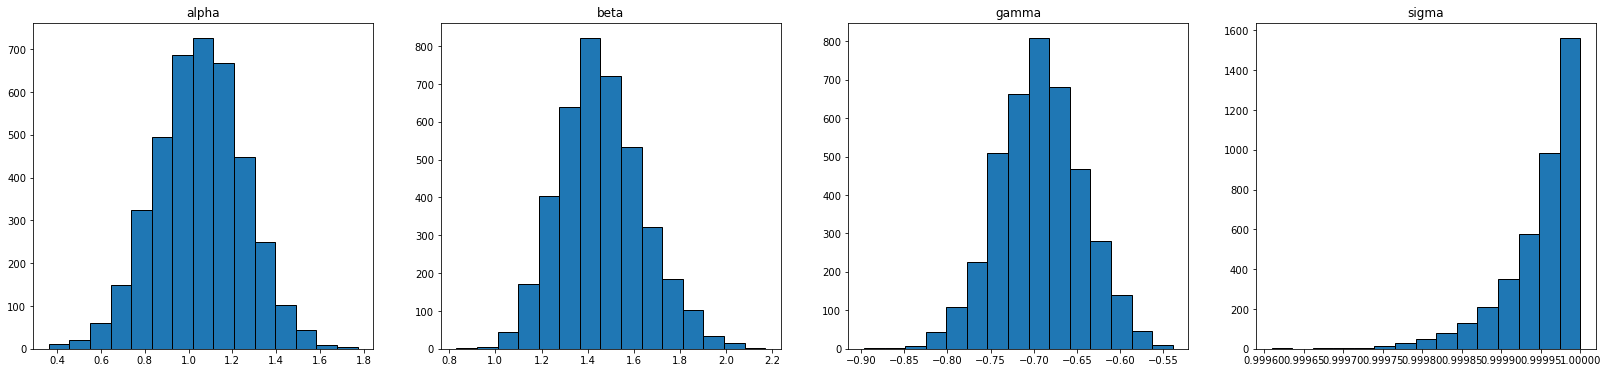

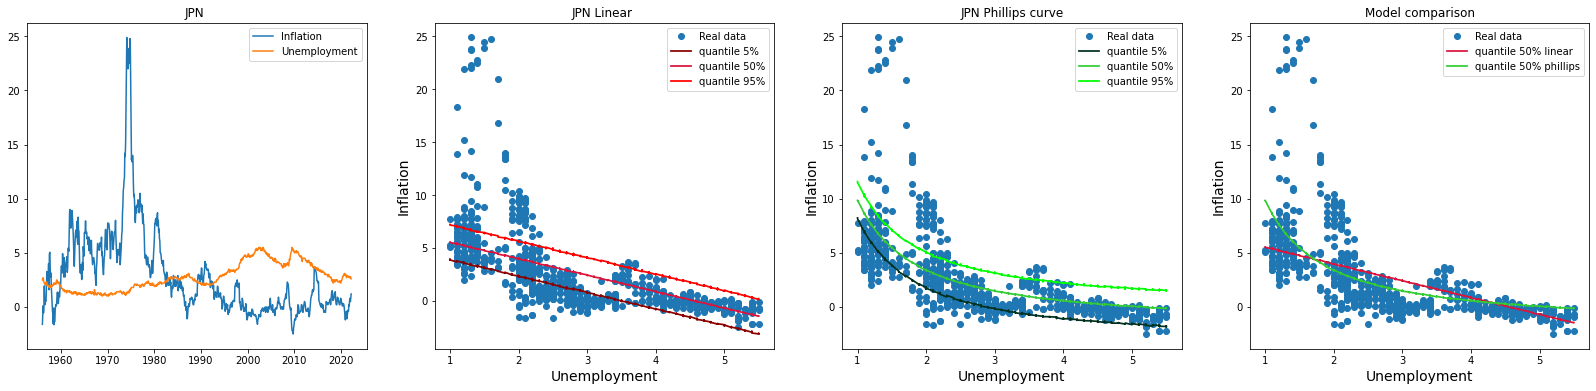

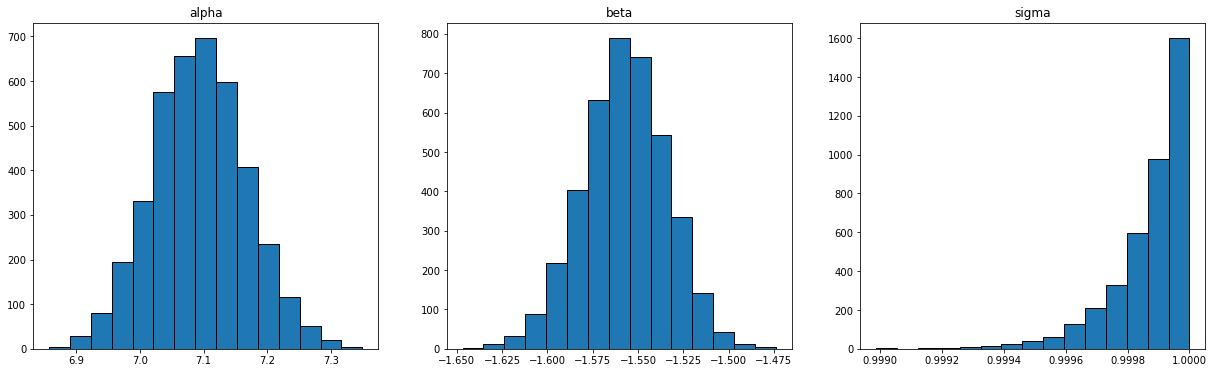

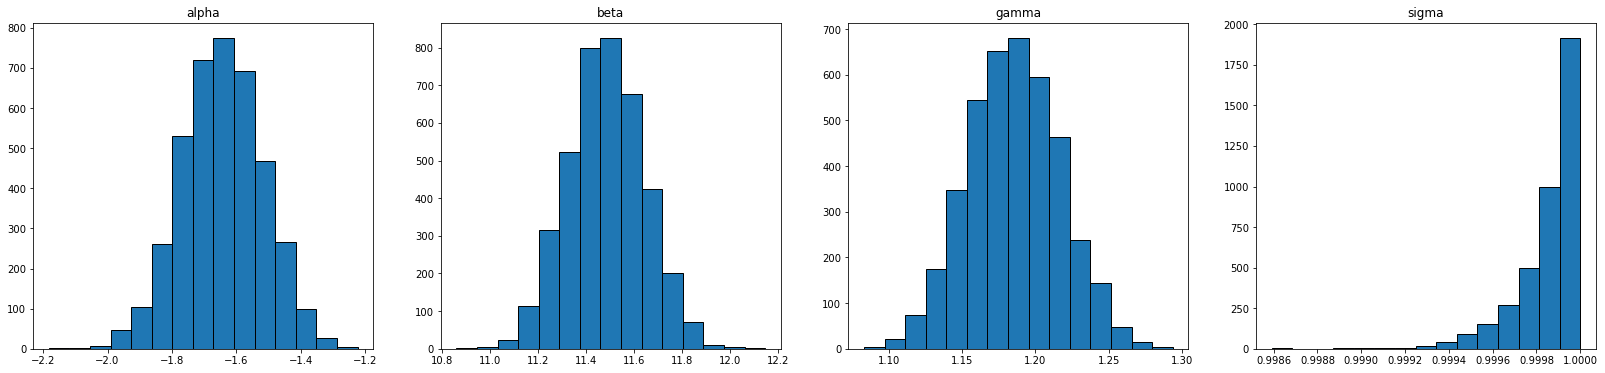

In [51]:
for data in country_and_fits:
    country, fit1, fit2 = data
    plot_results(country=country, fit1=fit1, fit2=fit2, fig_nr=0, span=len(country[0]))

In [55]:
for data in country_and_fits:
    _, fit1, fit2 = data
    print(fit1.summary())
    print(fit2.summary())

                Mean      MCSE   StdDev         5%       50%       95%  \
name                                                                     
lp__       -2400.000  0.043000  1.30000 -2400.0000 -2400.000 -2400.000   
alpha          3.700  0.003800  0.13000     3.4000     3.700     3.900   
beta           0.015  0.000330  0.01100    -0.0021     0.015     0.033   
sigma          1.000  0.000005  0.00023     1.0000     1.000     1.000   
y_gen[1]       3.700  0.018000  1.00000     2.1000     3.700     5.400   
...              ...       ...      ...        ...       ...       ...   
y_gen[299]     4.000  0.016000  1.00000     2.3000     4.000     5.600   
y_gen[300]     4.000  0.015000  1.00000     2.3000     3.900     5.600   
y_gen[301]     4.000  0.016000  1.00000     2.3000     4.000     5.600   
y_gen[302]     3.900  0.015000  1.00000     2.3000     3.900     5.600   
y_gen[303]     4.000  0.015000  0.99000     2.3000     4.000     5.600   

             N_Eff  N_Eff/s  R_hat  


In [52]:
country = country_list[0]
span_start_idx = 0
span = 60
fit1, fit2 = sample_models(country=country, span=span, span_start_idx=span_start_idx, model1=model_linear, model2=model_phillips)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration:  700 / 1500 [ 46%]  (Sampling)




chain 1 |█████████▍| 00:00 Iteration: 1300 / 1500 [ 86%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)
chain 1 |█▊        | 00:00 Iteration:  100 / 1500 [  6%]  (Warmup)


chain 1 |███▌      | 00:00 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |█████▎    | 00:00 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |██████▍   | 00:00 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▊ | 00:01 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |██████████| 00:01 Iteration: 1400 / 1500 [ 93%]  (Sampling)


chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


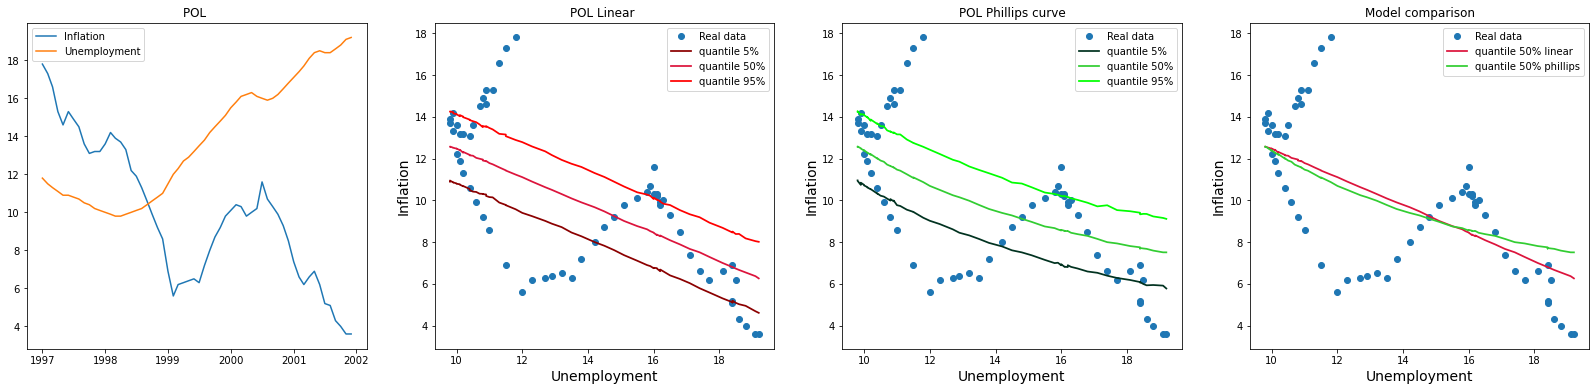

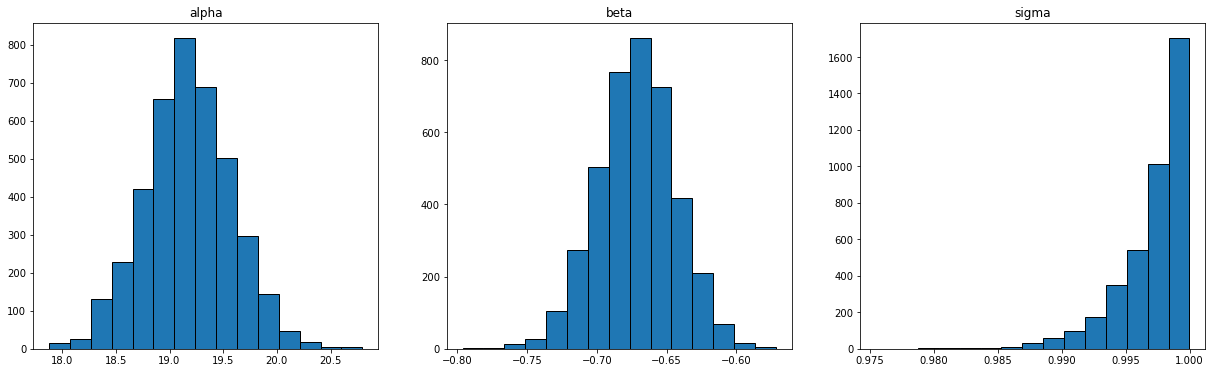

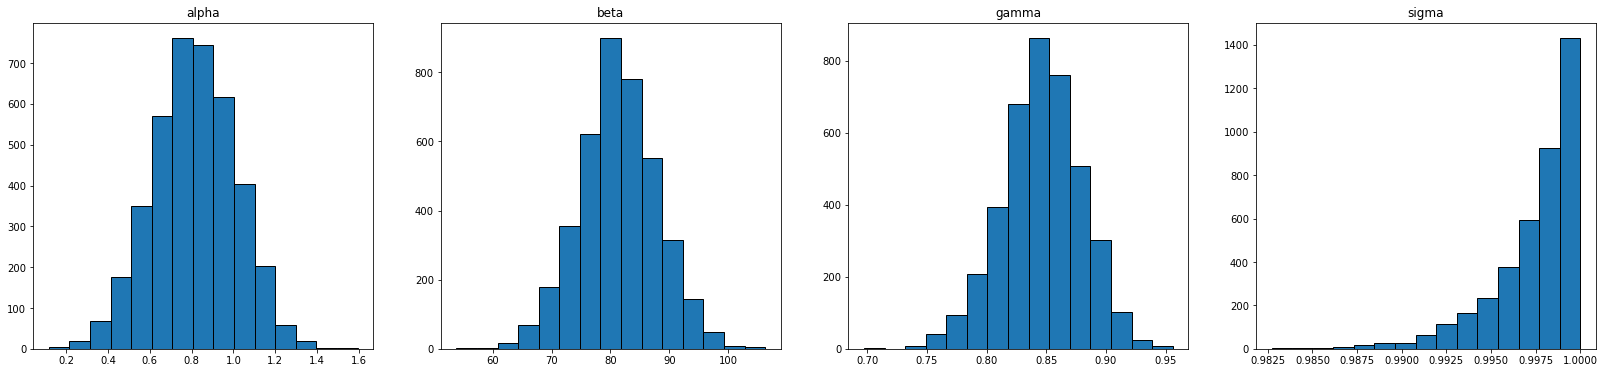

In [53]:
plot_results(country = country_list[0], fit1 = fit1, fit2 = fit2, fig_nr = 0, span = span)

In [54]:
fit2.summary()

Mean      MCSE  StdDev      5%     50%    95%   N_Eff  N_Eff/s  \
name                                                                          
lp__      -240.00  0.042000  1.5000 -250.00 -240.00 -240.0  1200.0    450.0   
alpha        0.81  0.004100  0.2000    0.48    0.81    1.1  2300.0    830.0   
beta        81.00  0.180000  6.6000   70.00   81.00   92.0  1300.0    480.0   
gamma        0.85  0.000900  0.0330    0.79    0.85    0.9  1400.0    500.0   
sigma        1.00  0.000046  0.0025    0.99    1.00    1.0  2900.0   1100.0   
...           ...       ...     ...     ...     ...    ...     ...      ...   
y_gen[56]    7.70  0.016000  1.0000    6.00    7.70    9.4  4109.0   1502.0   
y_gen[57]    7.70  0.017000  1.0000    5.90    7.70    9.3  3587.0   1311.0   
y_gen[58]    7.60  0.016000  1.0000    5.90    7.60    9.2  3850.0   1407.0   
y_gen[59]    7.50  0.016000  1.0000    5.90    7.50    9.2  3963.0   1449.0   
y_gen[60]    7.50  0.016000  1.0000    5.80    7.50    9.1  3990.0   1458.0   

           R_hat  
name              
lp__         1.0  
alpha        1.0  
beta         1.0  
gamma        1.0  
sigma        1.0  
...          ...  
y_gen[56]    1.0  
y_gen[57]    1.0  
y_gen[58]    1.0  
y_gen[59]    1.0  
y_gen[60]    1.0  

[65 rows x 9 columns]

chain 1 |          | 00:00 Status





chain 1 |█▊        | 00:00 Iteration:  100 / 1500 [  6%]  (Warmup)


chain 1 |█████▎    | 00:00 Iteration:  600 / 1500 [ 40%]  (Sampling)



chain 1 |███████▋  | 00:00 Iteration: 1000 / 1500 [ 66%]  (Sampling)

chain 1 |██████████| 00:00 Iteration: 1400 / 1500 [ 93%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

chain 1 |          | 00:00 Status




chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  100 / 1500 [  6%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  200 / 1500 [ 13%]  (Warmup)


chain 1 |██▉       | 00:01 Iteration:  300 / 1500 [ 20%]  (Warmup)


chain 1 |███▌      | 00:01 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |████▋     | 00:01 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:02 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |█████▉    | 00:02 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:02 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:02 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:03 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:03 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:03 Iteration: 1200 / 1500 [ 80%]  (Sampling)




chain 1 |█████████▍| 00:04 Iteration: 1300 / 15

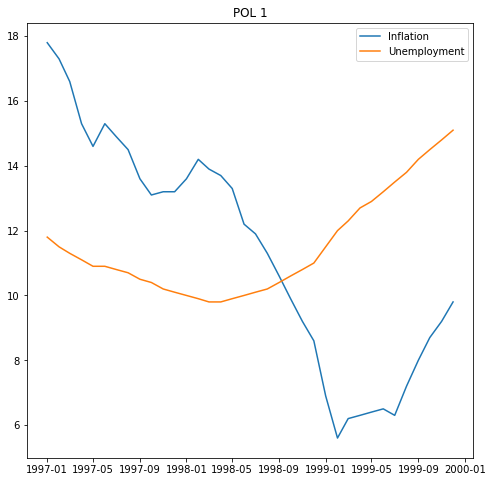

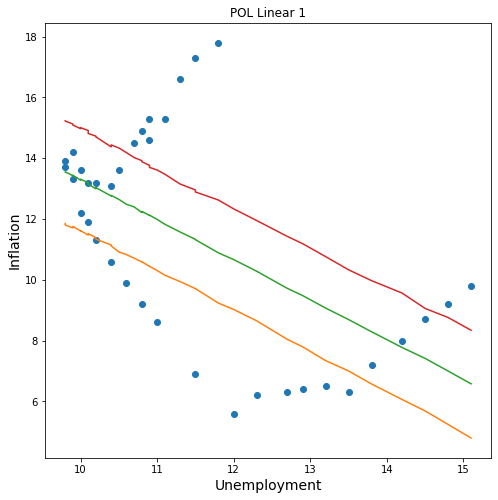

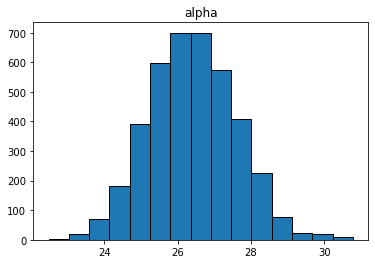

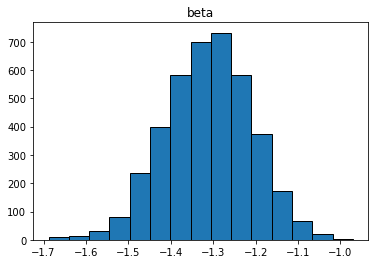

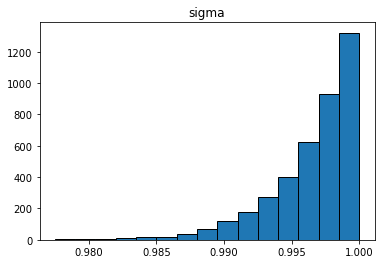

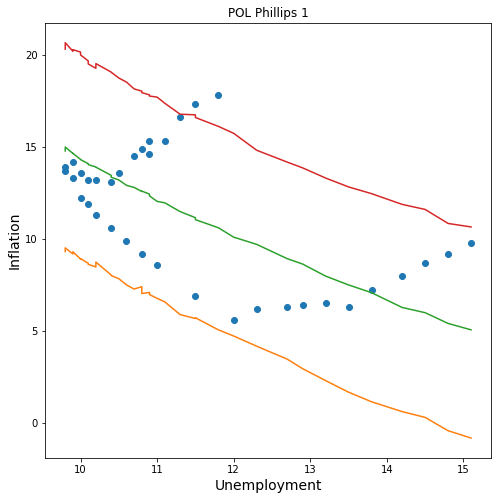

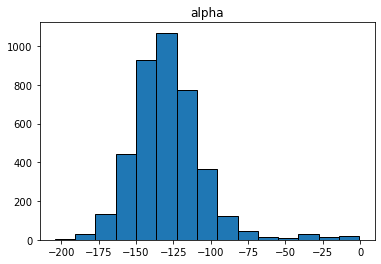

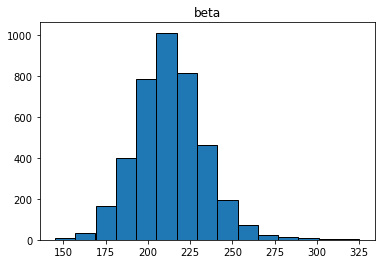

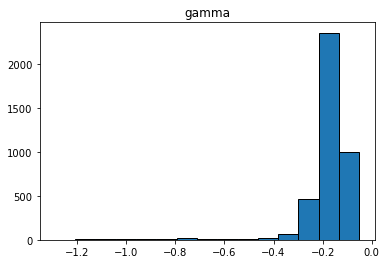

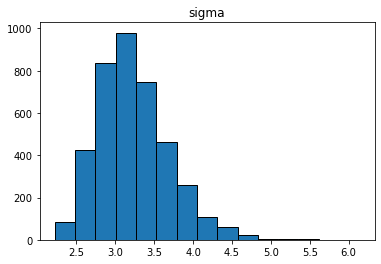

chain 1 |          | 00:00 Status




chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |███▌      | 00:00 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration:  700 / 1500 [ 46%]  (Sampling)
chain 1 |███████▋  | 00:00 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |█████████▍| 00:00 Iteration: 1300 / 1500 [ 86%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

chain 1 |          | 00:00 Status


chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)





chain 1 |█▊        | 00:01 Iteration:  100 / 1500 [  6%]  (Warmup)


chain 1 |██▉       | 00:02 Iteration:  300 / 1500 [ 20%]  (Warmup)


chain 1 |███▌      | 00:03 Iteration:  400 / 1500 [ 26%]  (Warmup)




chain 1 |████▋     | 00:04 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:05 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |█████▉    | 00:06 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:07 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:08 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:09 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:10 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:11 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |█████████▍| 00:12 Iteration: 1300 / 1500 [ 86%]  (Sampling)


chain 1 |██████████| 00:13 Iteration: 1400 /

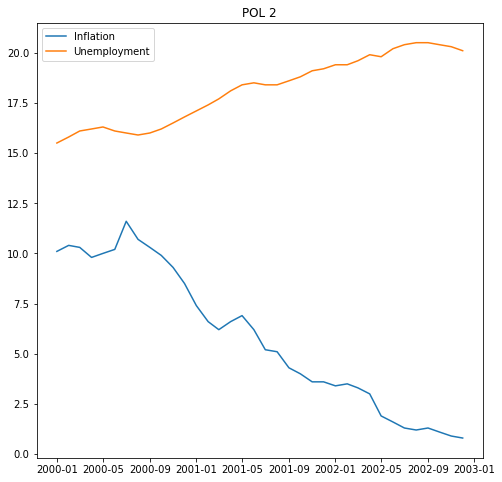

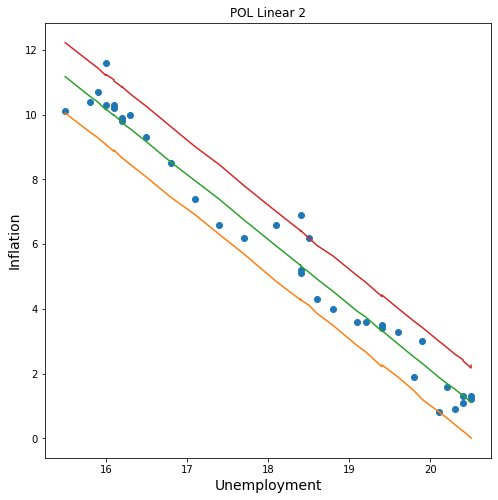

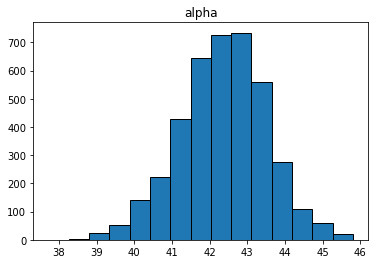

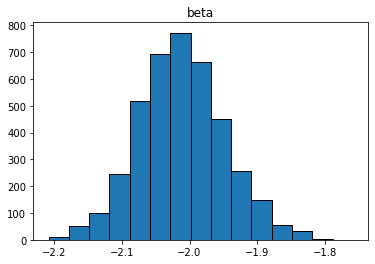

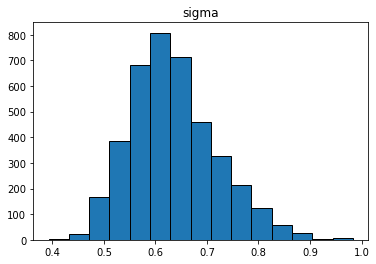

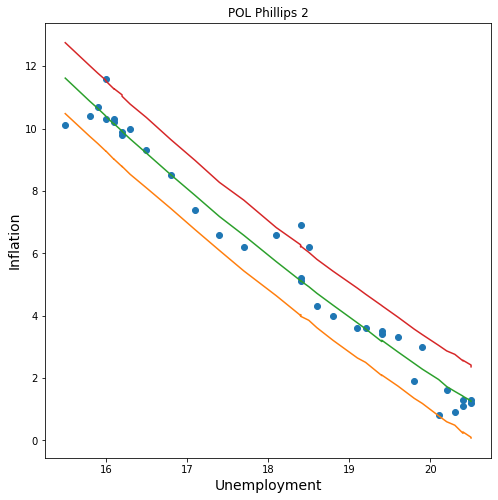

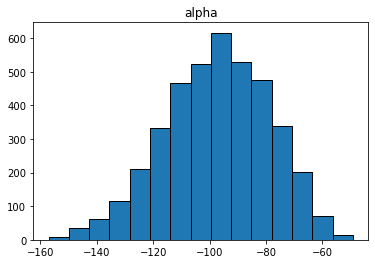

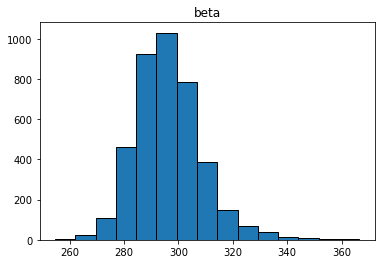

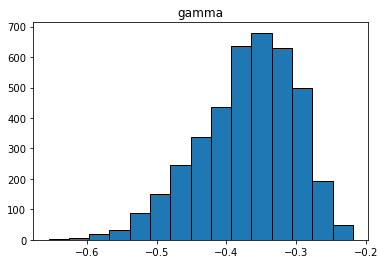

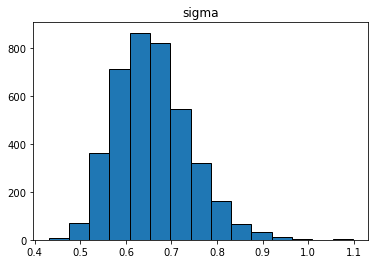

chain 1 |          | 00:00 Status





chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |██▉       | 00:00 Iteration:  300 / 1500 [ 20%]  (Warmup)


chain 1 |█████▎    | 00:00 Iteration:  600 / 1500 [ 40%]  (Sampling)
chain 1 |███████   | 00:00 Iteration:  900 / 1500 [ 60%]  (Sampling)




chain 1 |████████▊ | 00:00 Iteration: 1200 / 1500 [ 80%]  (Sampling)



chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       

chain 1 |          | 00:00 Status


chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)

chain 1 |█▊        | 00:00 Iteration:  100 / 1500 [  6%]  (Warmup)
chain 1 |██▎       | 00:01 Iteration:  200 / 1500 [ 13%]  (Warmup)




chain 1 |██▉       | 00:02 Iteration:  300 / 1500 [ 20%]  (Warmup)



chain 1 |███▌      | 00:02 Iteration:  400 / 1500 [ 26%]  (Warmup)





chain 1 |████▋     | 00:04 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:05 Iteration:  600 / 1500 [ 40%]  (Sampling)



chain 1 |█████▉    | 00:06 Iteration:  700 / 1500 [ 46%]  (Sampling)



chain 1 |██████▍   | 00:07 Iteration:  800 / 1500 [ 53%]  (Sampling)



chain 1 |███████   | 00:09 Iteration:  900 / 1500 [ 60%]  (Sampling)



chain 1 |███████▋  | 00:10 Iteration: 1000 / 1500 [ 66%]  (Sampling)

chain 1 |████████▏ | 00:11 Iteration: 1100 / 1500 [ 73%]  (Sampling)

chain 1 |████████▊ | 00:12 Iteration: 1200 / 1500 [ 80%]  (Sampling)

chain 1 |█████████▍| 00:13 Iteration: 1300 / 15

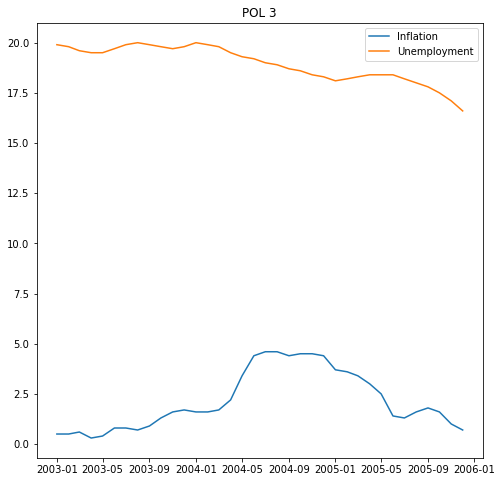

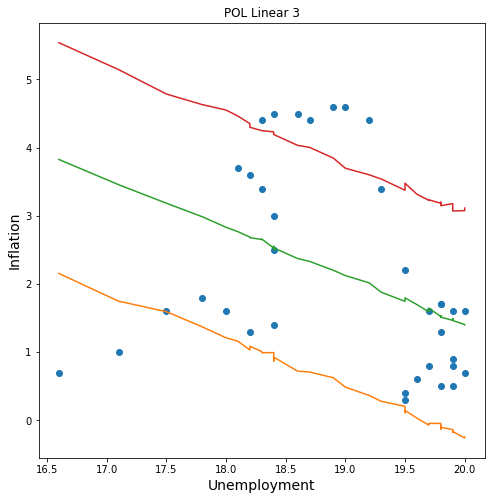

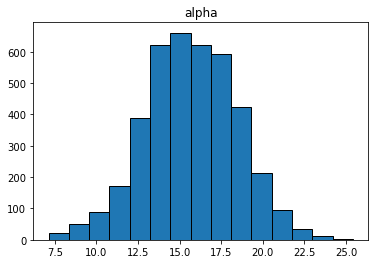

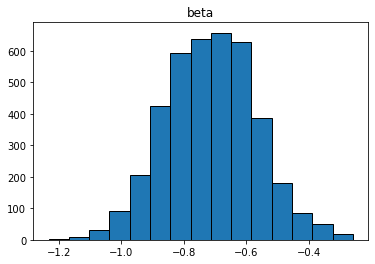

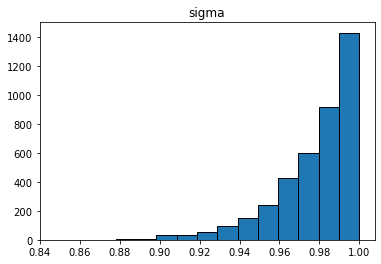

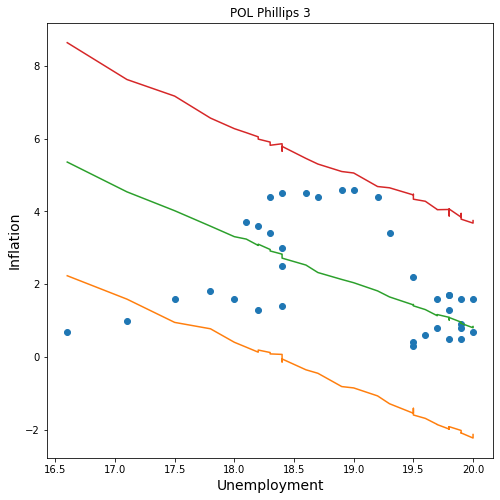

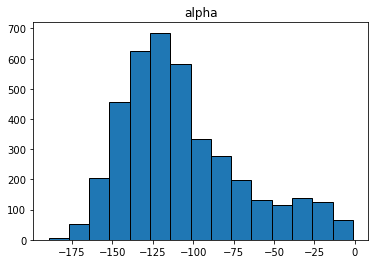

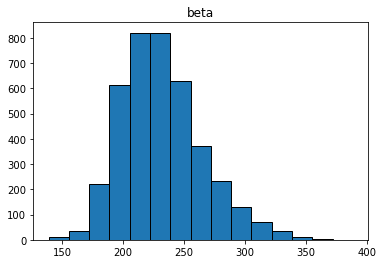

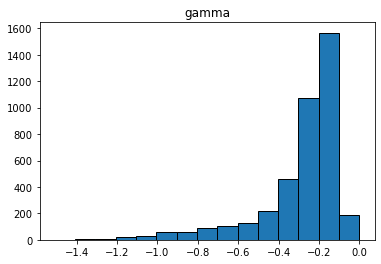

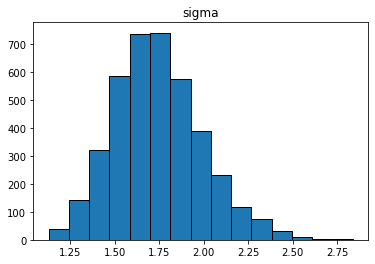

chain 1 |          | 00:00 Status


chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |████████▊ | 00:00 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

chain 1 |          | 00:00 Status








chain 1 |█▏        | 00:01 Iteration:    1 / 1500 [  0%]  (Warmup)














chain 1 |██████████| 00:11 Sampling completed                       
chain 2 |██████████| 00:11 Sampling completed                       
chain 3 |██████████| 00:11 Sampling completed                       
chain 4 |██████████| 00:11 Sampling completed                       

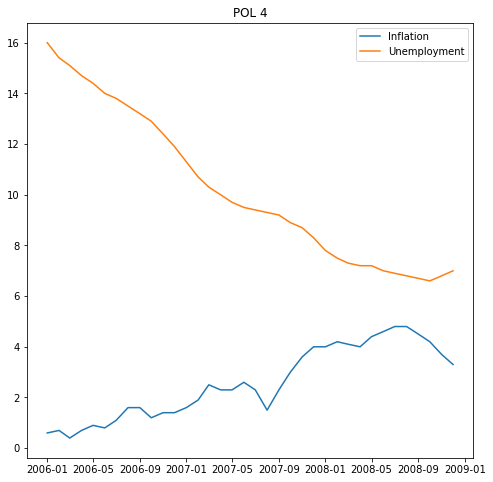

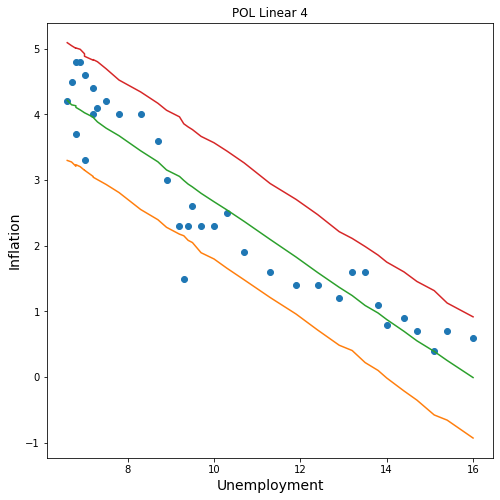

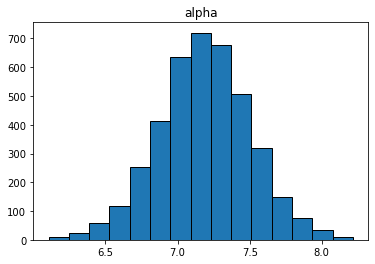

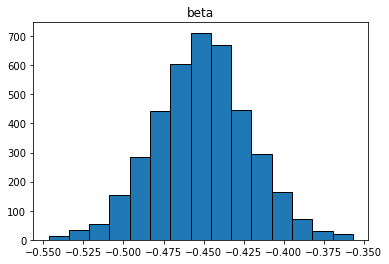

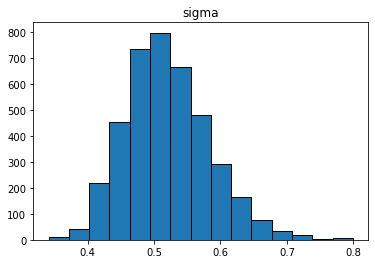

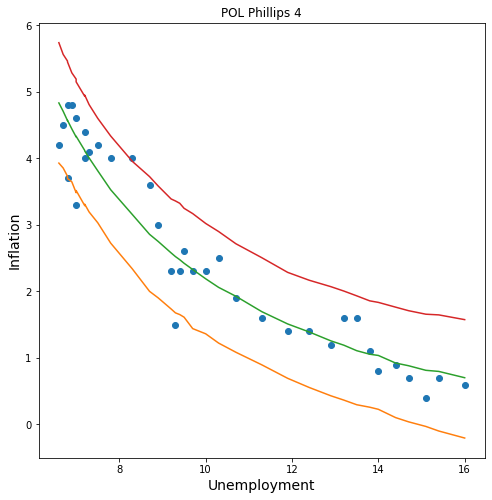

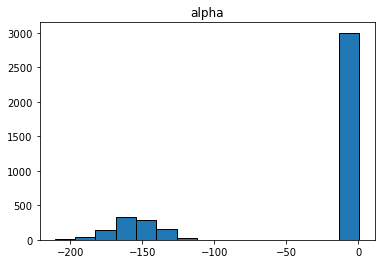

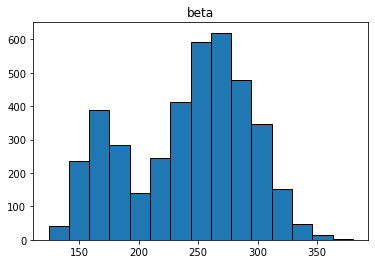

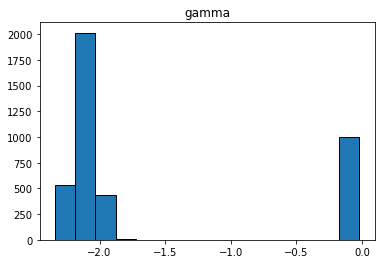

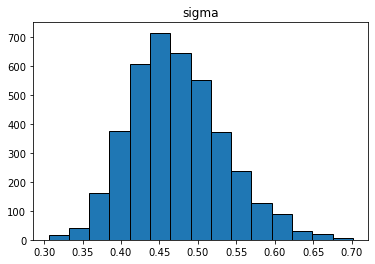

             Mean     MCSE  StdDev       5%      50%      95%   N_Eff  \
name                                                                    
lp__       -13.00   4.1000   5.900  -19.000  -16.000   -2.000     2.1   
alpha      -39.00  48.0000  68.000 -170.000   -0.033    0.350     2.0   
beta       240.00  31.0000  51.000  150.000  250.000  310.000     2.8   
gamma       -1.60   0.6400   0.900   -2.200   -2.100   -0.027     2.0   
sigma        0.47   0.0051   0.061    0.380    0.470    0.580   140.0   
y_gen[1]     4.80   0.1600   0.550    3.900    4.800    5.700    12.0   
y_gen[2]     4.70   0.1300   0.530    3.900    4.700    5.600    16.0   
y_gen[3]     4.60   0.1200   0.530    3.700    4.600    5.500    19.0   
y_gen[4]     4.60   0.1300   0.530    3.700    4.600    5.400    17.0   
y_gen[5]     4.50   0.0810   0.510    3.600    4.400    5.300    40.0   
y_gen[6]     4.30   0.0660   0.510    3.500    4.300    5.200    61.0   
y_gen[7]     4.30   0.0430   0.500    3.500    4.30

chain 1 |          | 00:00 Status


chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |███▌      | 00:00 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |███████▋  | 00:00 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |█████████▍| 00:00 Iteration: 1300 / 1500 [ 86%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

chain 1 |          | 00:00 Status






chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)
chain 1 |█▊        | 00:00 Iteration:  100 / 1500 [  6%]  (Warmup)
chain 1 |███▌      | 00:00 Iteration:  400 / 1500 [ 26%]  (Warmup)
chain 1 |█████▉    | 00:00 Iteration:  700 / 1500 [ 46%]  (Sampling)
chain 1 |██████████| 00:01 Iteration: 1400 / 1500 [ 93%]  (Sampling)



























chain 1 |██████████| 00:08 Sampling completed                       
chain 2 |██████████| 00:08 Sampling completed                       

chain 3 |██████████| 00:08 Sampling completed
chain 4 |██████████| 00:08 Sampling completed                       

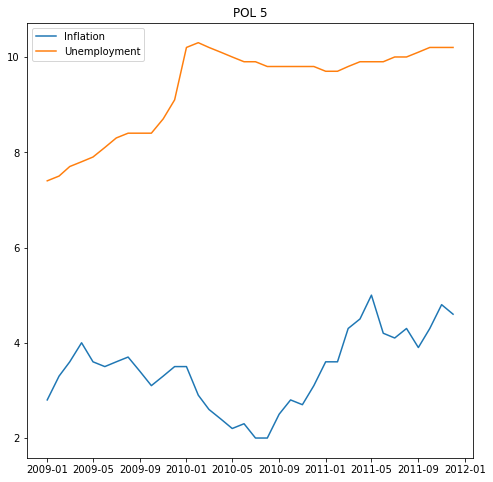

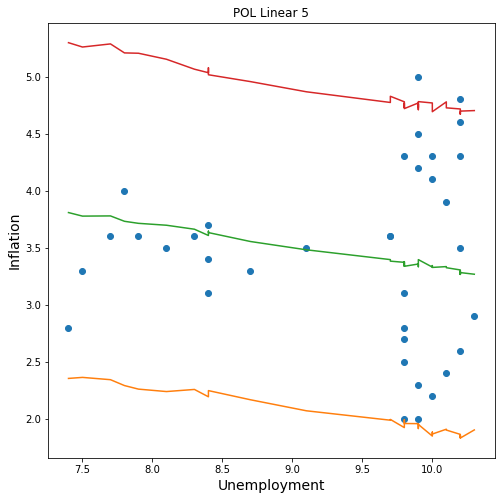

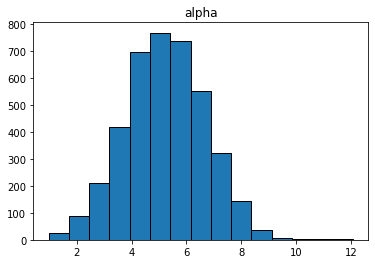

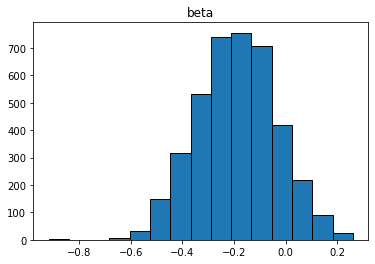

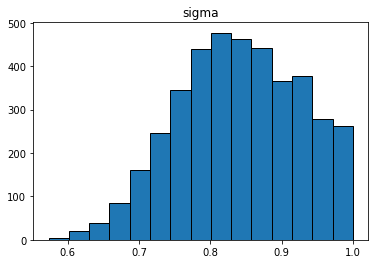

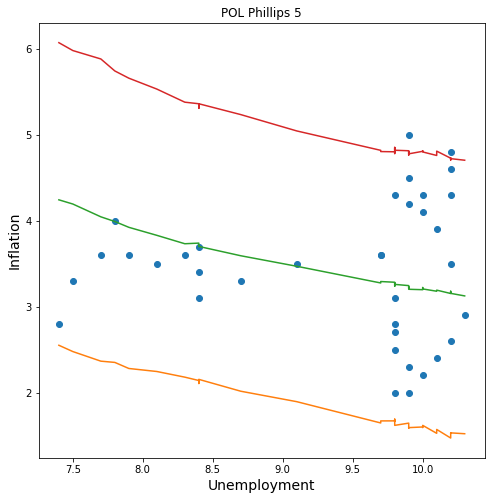

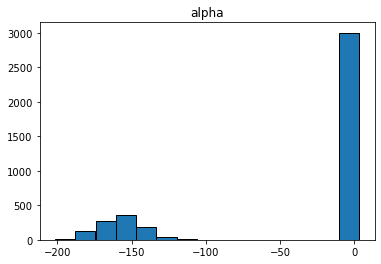

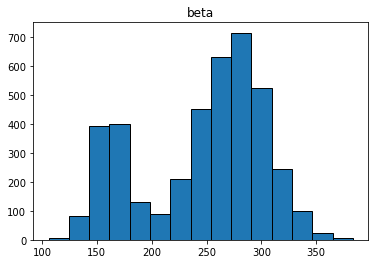

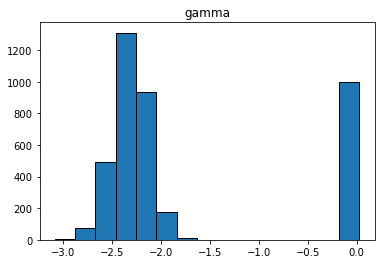

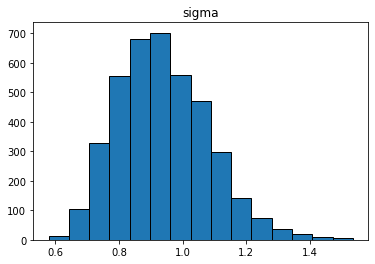

             Mean    MCSE  StdDev      5%     50%       95%   N_Eff  N_Eff/s  \
name                                                                           
lp__       -40.00   5.300    7.60  -46.00  -43.00  -25.0000     2.1     0.30   
alpha      -38.00  49.000   70.00 -170.00    1.50    2.6000     2.0     0.30   
beta       250.00  35.000   56.00  150.00  260.00  320.0000     2.5     0.37   
gamma       -1.70   0.710    1.00   -2.60   -2.20    0.0037     2.0     0.30   
sigma        0.94   0.039    0.14    0.73    0.93    1.2000    14.0     2.00   
y_gen[1]     4.30   0.310    1.10    2.60    4.20    6.1000    12.0     1.70   
y_gen[2]     4.20   0.280    1.10    2.50    4.20    6.0000    14.0     2.10   
y_gen[3]     4.10   0.240    1.10    2.40    4.00    5.9000    20.0     2.90   
y_gen[4]     4.00   0.220    1.10    2.30    4.00    5.7000    24.0     3.50   
y_gen[5]     3.90   0.190    1.00    2.30    3.90    5.7000    28.0     4.10   
y_gen[6]     3.80   0.120    1.00    2.2

chain 1 |          | 00:00 Status


chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |██▉       | 00:00 Iteration:  300 / 1500 [ 20%]  (Warmup)


chain 1 |█████▎    | 00:00 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |███████   | 00:00 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |████████▊ | 00:00 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

chain 1 |          | 00:00 Status








chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)






chain 1 |█▊        | 00:01 Iteration:  100 / 1500 [  6%]  (Warmup)
chain 1 |██▎       | 00:02 Iteration:  200 / 1500 [ 13%]  (Warmup)
chain 1 |██▉       | 00:02 Iteration:  300 / 1500 [ 20%]  (Warmup)
chain 1 |███▌      | 00:02 Iteration:  400 / 1500 [ 26%]  (Warmup)
chain 1 |████▋     | 00:03 Iteration:  501 / 1500 [ 33%]  (Sampling)
chain 1 |█████▎    | 00:03 Iteration:  600 / 1500 [ 40%]  (Sampling)
chain 1 |█████▉    | 00:04 Iteration:  700 / 1500 [ 46%]  (Sampling)
chain 1 |██████▍   | 00:04 Iteration:  800 / 1500 [ 53%]  (Sampling)
chain 1 |███████   | 00:05 Iteration:  900 / 1500 [ 60%]  (Sampling)
chain 1 |███████▋  | 00:05 Iteration: 1000 / 1500 [ 66%]  (Sampling)
chain 1 |████████▊ | 00:06 Iteration: 1200 / 1500 [ 80%]  (Sampling)
chain 1 |█████████▍| 00:06 Iteration: 1300 / 1500 [ 86%]  (Sampling)
chain 1 |██████████| 00:07 Iteration: 1400 / 1500 [ 93%]  (Sampli

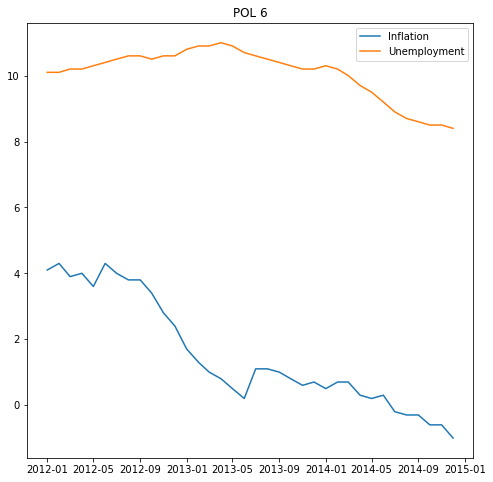

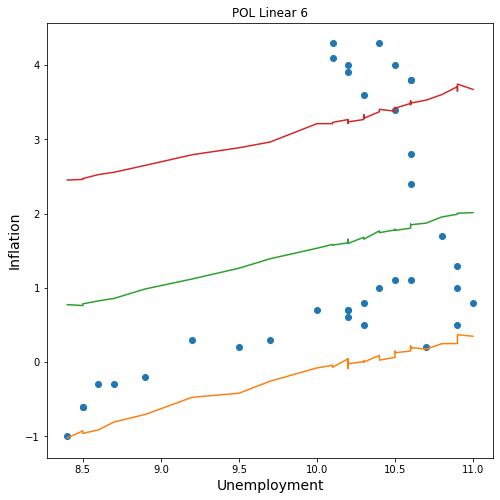

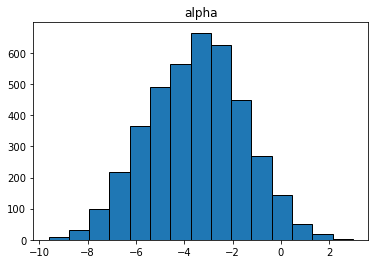

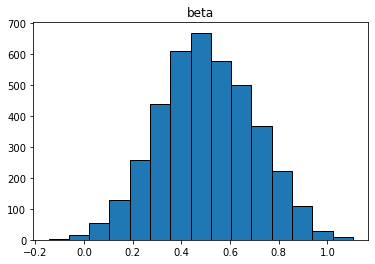

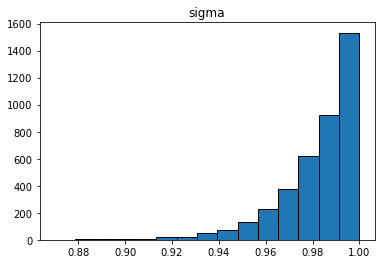

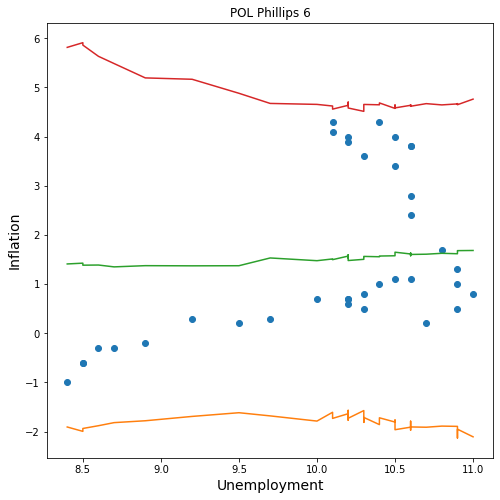

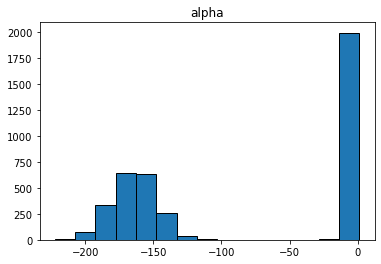

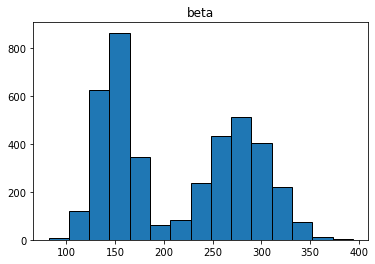

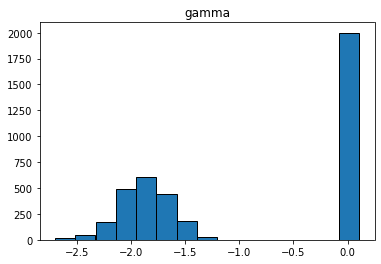

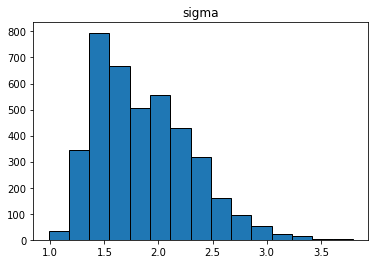

             Mean    MCSE  StdDev     5%      50%      95%   N_Eff  N_Eff/s  \
name                                                                          
lp__       -58.00   5.500    7.90  -68.0  -59.000  -49.000     2.1     0.20   
alpha      -84.00  57.000   82.00 -190.0  -15.000   -0.440     2.0     0.19   
beta       210.00  46.000   69.00  130.0  200.000  320.000     2.2     0.21   
gamma       -0.91   0.680    0.97   -2.2   -0.035    0.071     2.1     0.20   
sigma        1.90   0.240    0.44    1.3    1.800    2.700     3.2     0.31   
y_gen[1]     1.60   1.000    2.40   -1.9    1.400    5.800     5.8     0.55   
y_gen[2]     1.60   0.960    2.40   -2.0    1.400    5.900     6.3     0.59   
y_gen[3]     1.60   0.990    2.40   -1.9    1.400    5.900     5.9     0.56   
y_gen[4]     1.60   0.840    2.30   -1.9    1.400    5.600     7.6     0.72   
y_gen[5]     1.50   0.820    2.20   -1.8    1.400    5.500     7.3     0.70   
y_gen[6]     1.50   0.660    2.10   -1.8    1.400   

chain 1 |          | 00:00 Status





chain 1 |█▊        | 00:00 Iteration:  100 / 1500 [  6%]  (Warmup)


chain 1 |█████▎    | 00:00 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

chain 1 |          | 00:00 Status








chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)



chain 1 |█▊        | 00:01 Iteration:  100 / 1500 [  6%]  (Warmup)

chain 1 |██▎       | 00:02 Iteration:  200 / 1500 [ 13%]  (Warmup)

chain 1 |██▉       | 00:03 Iteration:  300 / 1500 [ 20%]  (Warmup)

chain 1 |███▌      | 00:03 Iteration:  400 / 1500 [ 26%]  (Warmup)

chain 1 |████▋     | 00:04 Iteration:  501 / 1500 [ 33%]  (Sampling)

chain 1 |█████▎    | 00:05 Iteration:  600 / 1500 [ 40%]  (Sampling)

chain 1 |█████▉    | 00:06 Iteration:  700 / 1500 [ 46%]  (Sampling)

chain 1 |██████▍   | 00:07 Iteration:  800 / 1500 [ 53%]  (Sampling)

chain 1 |███████   | 00:08 Iteration:  900 / 1500 [ 60%]  (Sampling)

chain 1 |███████▋  | 00:09 Iteration: 1000 / 1500 [ 66%]  (Sampling)

chain 1 |████████▏ | 00:09 Iteration: 1100 / 1500 [ 73%]  (Sampling)

chain 1 |████████▊ | 00:10 Iteration: 1200 / 1500 [ 80%]  (Sampling)

chain 1 |█████████▍| 00:11 Iteration: 1300 / 1500 [ 86%]

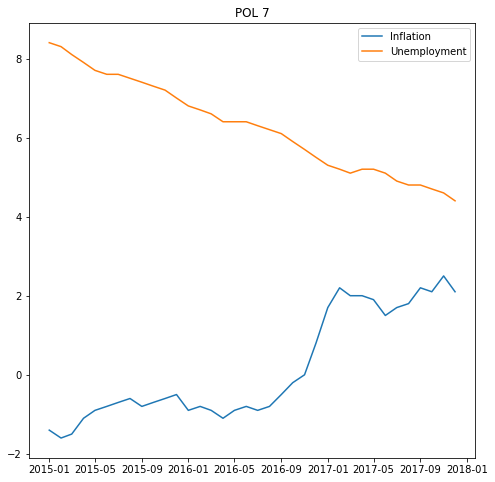

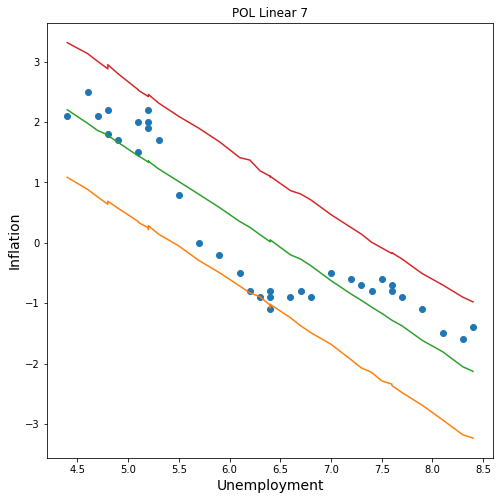

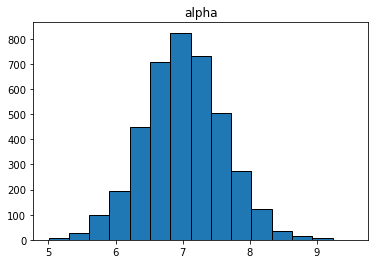

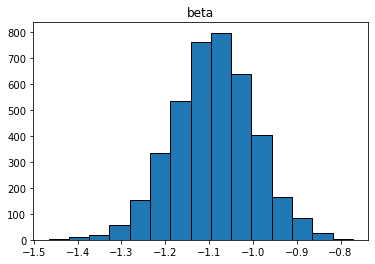

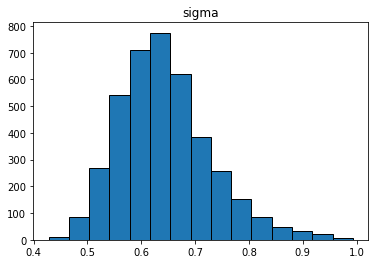

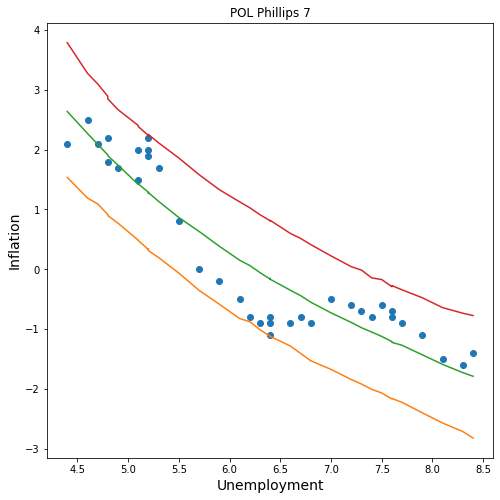

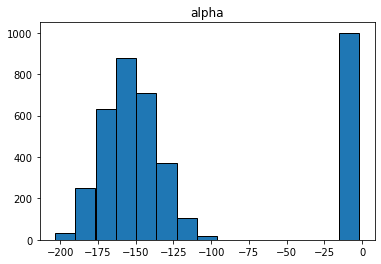

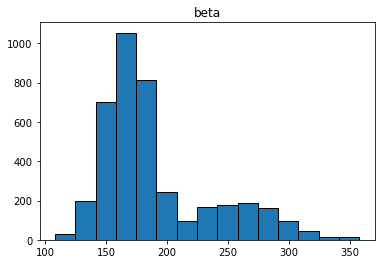

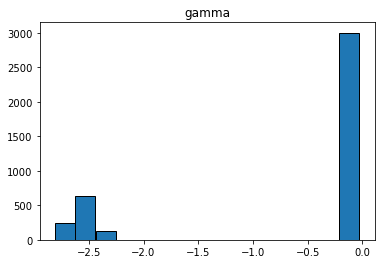

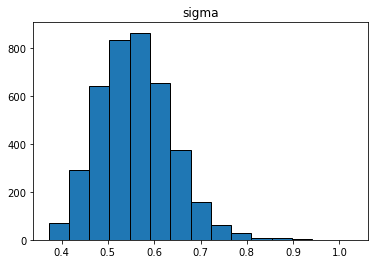

              Mean     MCSE  StdDev       5%      50%      95%   N_Eff  \
name                                                                     
lp__       -15.000   3.7000   5.400  -25.000  -12.000  -10.000     2.1   
alpha     -120.000  46.0000  67.000 -180.000 -150.000   -2.400     2.1   
beta       190.000  29.0000  46.000  140.000  170.000  290.000     2.5   
gamma       -0.670   0.7700   1.100   -2.600   -0.046   -0.036     2.0   
sigma        0.560   0.0230   0.079    0.440    0.550    0.690    12.0   
y_gen[1]     2.600   0.2700   0.690    1.500    2.600    3.800     6.5   
y_gen[2]     2.300   0.1500   0.640    1.200    2.300    3.300    17.0   
y_gen[3]     2.100   0.1000   0.610    1.100    2.100    3.100    34.0   
y_gen[4]     1.900   0.0580   0.600    0.920    1.900    2.900   108.0   
y_gen[5]     1.900   0.0360   0.600    0.900    1.900    2.800   277.0   
y_gen[6]     1.700   0.0110   0.590    0.770    1.700    2.700  2653.0   
y_gen[7]     1.400   0.0092   0.580   

chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  100 / 1500 [  6%]  (Warmup)



chain 1 |████▋     | 00:00 Iteration:  501 / 1500 [ 33%]  (Sampling)



chain 1 |███████   | 00:00 Iteration:  900 / 1500 [ 60%]  (Sampling)

chain 1 |█████████▍| 00:00 Iteration: 1300 / 1500 [ 86%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

chain 1 |          | 00:00 Status




chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  100 / 1500 [  6%]  (Warmup)
chain 1 |██▎       | 00:02 Iteration:  200 / 1500 [ 13%]  (Warmup)


chain 1 |██▉       | 00:03 Iteration:  300 / 1500 [ 20%]  (Warmup)


chain 1 |███▌      | 00:03 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |████▋     | 00:04 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:05 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |█████▉    | 00:06 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:07 Iteration:  800 / 1500 [ 53%]  (Sampling)
chain 1 |███████   | 00:08 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:09 Iteration: 1000 / 1500 [ 66%]  (Sampling)

chain 1 |████████▏ | 00:10 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:12 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |█████████▍| 00:13 Iteration: 1300 / 1500 [ 86

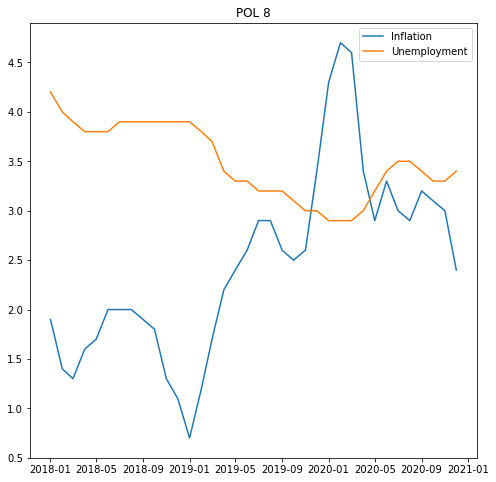

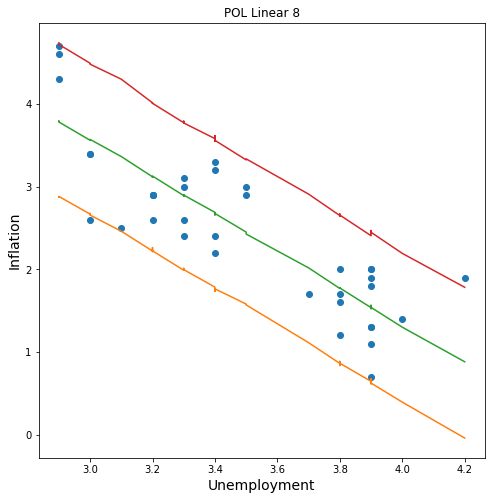

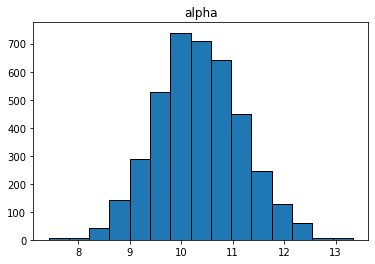

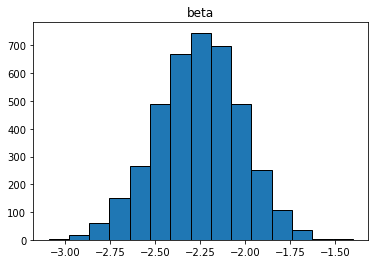

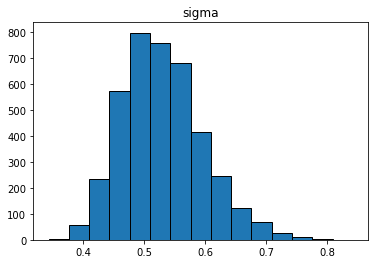

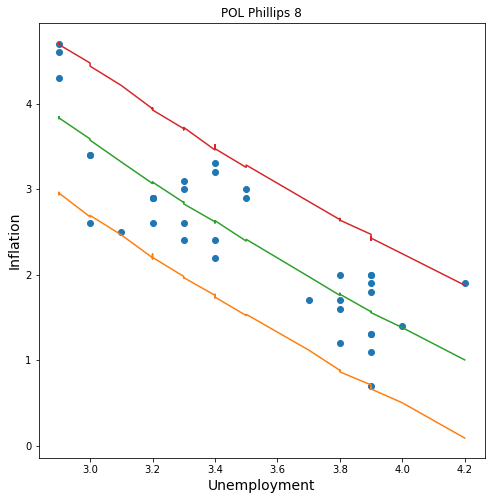

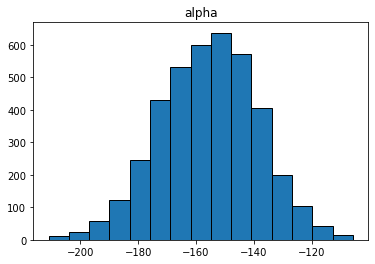

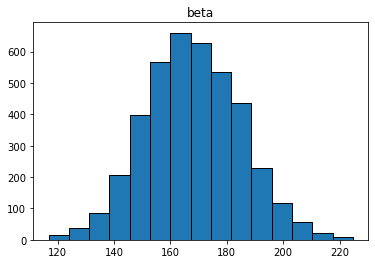

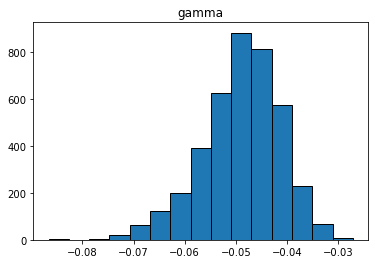

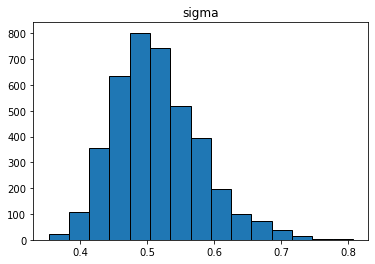

In [320]:
country = country_list[0]
for i in range(int(len(country[0])/36)):
    span_start_idx = i*36
    create_two_plots(country=country, span_start_idx=span_start_idx, model1=model_linear, model2=model_phillips, fig_nr=i)

In [297]:
df_gen = fit_gen_quant.draws_pd()
df_gen = df_gen[:][df_gen[:] != 0]
df_gen.dropna(subset = ["alpha_l"], inplace=True)
df_gen

lp__  accept_stat__  alpha_l    beta_l   sigma_l   y_l[1]   y_l[2]  \
0      NaN            NaN  19.4177 -0.607264  1.017570  16.5302  17.8805   
1      NaN            NaN  22.6649 -0.581601  1.652680  18.6913  19.2353   
2      NaN            NaN  17.0201 -0.523130  1.352240  14.7018  12.9828   
3      NaN            NaN  16.2074 -0.507525  0.691319  14.0438  15.7673   
4      NaN            NaN  20.7562 -0.543683  1.547660  21.5312  21.7973   
...    ...            ...      ...       ...       ...      ...      ...   
3995   NaN            NaN  14.4591 -0.566105  0.491085  13.6207  13.4713   
3996   NaN            NaN  13.7720 -0.532212  1.097670  13.0045  14.0272   
3997   NaN            NaN  17.9806 -0.593699  1.335850  16.9862  16.3713   
3998   NaN            NaN  19.5648 -0.527480  1.460710  18.7782  16.1691   
3999   NaN            NaN  16.5982 -0.501818  0.417186  15.5473  14.9767   

       y_l[3]   y_l[4]   y_l[5]  ...  y_p[991]  y_p[992]  y_p[993]  y_p[994]  \
0     19.5634  18.0258  18.2399  ...  0.991152  1.753250  2.485820  1.508300   
1     21.4896  20.8812  22.7652  ...  1.538560  1.403470  1.836590  2.167500   
2     17.3830  15.5374  14.5952  ...  2.103660  1.589990  1.205480  2.135100   
3     15.7127  15.8634  14.2258  ...  2.431720  2.659380  3.183410  3.130330   
4     18.8077  19.5540  20.9872  ...  1.855020  0.206533  2.467140 -0.223613   
...       ...      ...      ...  ...       ...       ...       ...       ...   
3995  12.8974  13.9405  13.1918  ...  0.956207  0.599172  0.660441  0.579417   
3996  12.8859  13.2327  12.8095  ...  0.387186  0.797152  1.320520  1.208410   
3997  16.7704  17.1347  17.6011  ...  2.640170  1.447500 -0.693237  0.014277   
3998  15.4232  18.9713  18.8486  ...  0.715207  0.900605  0.375543  1.457970   
3999  16.1251  15.3435  16.0083  ...  1.533740  1.607020  1.384630  2.017450   

      y_p[995]  y_p[996]  y_p[997]  y_p[998]  y_p[999]  y_p[1000]  
0    -0.016568   1.19019  1.080200  2.600980  2.014500   1.561980  
1    -0.322154   1.52208  0.752781  1.320770  1.956560   0.904113  
2     1.492840   2.11067  2.095990  1.890480  1.000050   1.482980  
3     2.652650   2.96718  3.141970  2.692270  2.611070   2.918560  
4     2.664530   1.86589  0.776652  2.038840 -0.231206   2.273730  
...        ...       ...       ...       ...       ...        ...  
3995  0.558060   1.23291  1.422640  1.570900 -0.112683   0.095897  
3996  1.753730   0.04930  2.098840  1.729950 -1.064200   1.276970  
3997  2.497610   3.13488  1.407040  0.916618  1.557070   1.755900  
3998  0.162567   1.42810  0.501556  2.006020  1.313530   1.169930  
3999  1.688260   1.38826  1.930990  0.637795  0.791641   1.280980  

[3821 rows x 2009 columns]

In [298]:
y_lin_05 = np.array([])
y_lin_50 = np.array([])
y_lin_95 = np.array([])
y_phil_05 = np.array([])
y_phil_50 = np.array([])
y_phil_95 = np.array([])
for i in range(1, 1001):
    y_lin_05 = np.append(y_lin_05, np.quantile(df_gen.loc[:, "y_l[" + str(i) + "]"], 0.05))
    y_lin_50 = np.append(y_lin_50, np.quantile(df_gen.loc[:, "y_l[" + str(i) + "]"], 0.5))
    y_lin_95 = np.append(y_lin_95, np.quantile(df_gen.loc[:, "y_l[" + str(i) + "]"], 0.95))
    y_phil_05 = np.append(y_phil_05, np.quantile(df_gen.loc[:, "y_p[" + str(i) + "]"], 0.05))
    y_phil_50 = np.append(y_phil_50, np.quantile(df_gen.loc[:, "y_p[" + str(i) + "]"], 0.5))
    y_phil_95 = np.append(y_phil_95, np.quantile(df_gen.loc[:, "y_p[" + str(i) + "]"], 0.95))



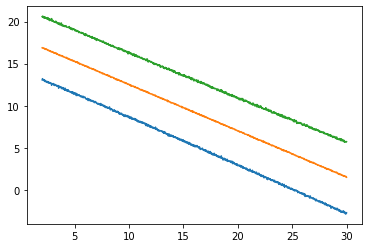

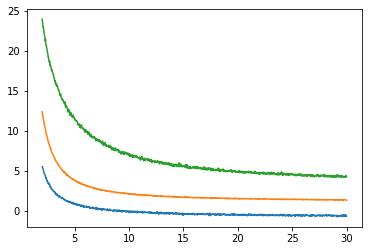

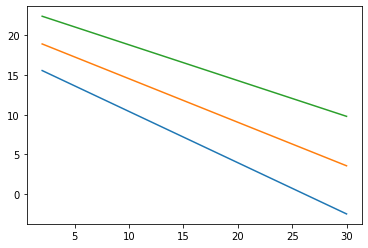

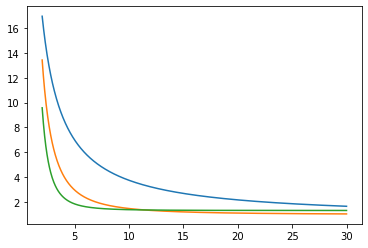

In [252]:
alpha_l_05 = np.quantile(df_gen.loc[:, "alpha_l"], 0.05)
alpha_l_50 = np.quantile(df_gen.loc[:, "alpha_l"], 0.50)
alpha_l_95 = np.quantile(df_gen.loc[:, "alpha_l"], 0.95)

beta_l_05 = np.quantile(df_gen.loc[:, "beta_l"], 0.05)
beta_l_50 = np.quantile(df_gen.loc[:, "beta_l"], 0.50)
beta_l_95 = np.quantile(df_gen.loc[:, "beta_l"], 0.95)


alpha_p_05 = np.quantile(df_gen.loc[:, "alpha_p"], 0.05)
alpha_p_50 = np.quantile(df_gen.loc[:, "alpha_p"], 0.50)
alpha_p_95 = np.quantile(df_gen.loc[:, "alpha_p"], 0.95)

beta_p_05 = np.quantile(df_gen.loc[:, "beta_p"], 0.05)
beta_p_50 = np.quantile(df_gen.loc[:, "beta_p"], 0.50)
beta_p_95 = np.quantile(df_gen.loc[:, "beta_p"], 0.95)

gamma_p_05 = np.quantile(df_gen.loc[:, "gamma"], 0.05)
gamma_p_50 = np.quantile(df_gen.loc[:, "gamma"], 0.50)
gamma_p_95 = np.quantile(df_gen.loc[:, "gamma"], 0.95)

x = np.linspace(2, 30, 1000)

y1_l = alpha_l_05 + beta_l_05 * x
y2_l = alpha_l_50 + beta_l_50 * x
y3_l = alpha_l_95 + beta_l_95 * x

y1_p = alpha_p_05 + beta_p_05 / (x ** gamma_p_05)
y2_p = alpha_p_50 + beta_p_50 / (x ** gamma_p_50)
y3_p = alpha_p_95 + beta_p_95 / (x ** gamma_p_95)


plt.plot(x, y1_l, x, y2_l, x, y3_l)
plt.show()

plt.plot(x, y1_p, x, y2_p, x, y3_p)
plt.show()